## Capstone Project - NBA Active Players Injury Prediction and Performance Assessment
### by Murali Balasubramanian
#### Aug-Sep'2025
#### Course: QM640
#### Program: DBA AI/ML, Walsh College, MI, USA

## Data ingestion with NBA API Endpoints

In [1]:
headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

In [12]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats, commonplayerinfo, playergamelog
from nba_api.stats.endpoints import scheduleleaguev2, boxscoreadvancedv2, boxscoreplayertrackv2
import pandas as pd
import numpy as np
import mysql.connector
from datetime import datetime
import time
import requests
import random
from typing import List, Dict
import concurrent.futures

### First Endpoints are for Active players and their Game Logs from a season

In [33]:
### This is extract Player game logs for a season 
### Filtering Players with atleast 24 mpg
#
class NBATimeoutHandler:
    def __init__(self, max_retries: int = 5, initial_delay: float = 2.0):
        self.max_retries = max_retries
        self.initial_delay = initial_delay
            
    def exponential_backoff(self, attempt: int) -> float:
        """Calculate delay with exponential backoff"""
        delay = self.initial_delay * (2 ** attempt)
        jitter = random.uniform(0, 1)
        return delay + jitter
        
    def safe_request(self, player_id: int, season: str) -> pd.DataFrame:
        """Handle API requests with retry logic"""
        for attempt in range(self.max_retries):
            try:
                # Make API request
                game_log = playergamelog.PlayerGameLog(
                    player_id=player_id,
                    season=season,
                    #headers={'User-Agent': 'Mozilla/5.0'}
                )
                
                # Convert to DataFrame and remove VIDEO_AVAILABLE column
                df = game_log.get_data_frames()[0].drop(columns=['VIDEO_AVAILABLE'], errors='ignore')
                
                if not df.empty:
                    return df
                    
            except Exception as e:
                if attempt == self.max_retries - 1:
                    raise Exception(f"All retries failed for player_id={player_id}: {str(e)}")
                    
                delay = self.exponential_backoff(attempt)
                time.sleep(delay)
                
            except KeyboardInterrupt:
                raise

def get_active_player_gamelogs(min_minutes: float = 24.0) -> pd.DataFrame:
    """Get game logs for active players averaging more than min_minutes per game"""
    nba_players = players.get_active_players()
    handler = NBATimeoutHandler(max_retries=5, initial_delay=2.0)
    
    # Process players in batches
    batch_size = 3
    qualifying_players = []
    all_game_logs = []
    failed_players = []
    
    for i in range(0, len(nba_players), batch_size):
        batch = nba_players[i:i + batch_size]
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            futures = []
            for player in batch:
                futures.append(
                    executor.submit(
                        process_player,
                        handler,
                        player['id'],
                        player['full_name'],
                        '2023-24',
                        min_minutes
                    )
                )
            
            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                if result:
                    player_name, df = result
                    qualifying_players.append(player_name)
                    all_game_logs.append(df)
                else:
                    failed_players.append(player['full_name'])
        
        time.sleep(5)
    
    # Process failed players individually with longer delays
    failed_game_logs = []
    for player_name in failed_players:
        player = next(p for p in nba_players if p['full_name'] == player_name)
        try:
            handler = NBATimeoutHandler(max_retries=8, initial_delay=5.0)
            df = handler.safe_request(player['id'], '2023-24')
            
            if not df.empty:
                avg_minutes = df['MIN'].mean()
                if avg_minutes > min_minutes:
                    qualifying_players.append(player_name)
                    failed_game_logs.append(df)
                    print(f"Successfully processed {player_name} in second attempt")
                    
        except Exception as e:
            print(f"Failed to process {player_name} even after individual attempt: {str(e)}")
            continue
    
    # Combine all successful game logs
    main_df = pd.concat(all_game_logs, ignore_index=True) if all_game_logs else pd.DataFrame()
    failed_df = pd.concat(failed_game_logs, ignore_index=True) if failed_game_logs else pd.DataFrame()
    
    if not main_df.empty or not failed_df.empty:
        return pd.concat([main_df, failed_df], ignore_index=True)
    return pd.DataFrame()

def process_player(handler: NBATimeoutHandler, player_id: int, player_name: str, 
                  season: str, min_minutes: float) -> tuple:
    """Process a single player's game log"""
    try:
        df = handler.safe_request(player_id, season)
        
        if not df.empty:
            avg_minutes = df['MIN'].mean()
            if avg_minutes > min_minutes:
                return (player_name, df)
                
    except Exception as e:
        print(f"Error processing {player_name}: {str(e)}")
        return None

# Usage
result_df = get_active_player_gamelogs()
print(f"\nNumber of qualifying players: {len(result_df_202['Player_ID'].unique())}")
print("\nSample of results:")
print(result_df_2023_24.head())

Error processing Steven Adams: 'NoneType' object has no attribute 'empty'
Error processing Trey Alexander: 'NoneType' object has no attribute 'empty'
Error processing Taran Armstrong: 'NoneType' object has no attribute 'empty'
Error processing Marcus Bagley: 'NoneType' object has no attribute 'empty'
Error processing Lonzo Ball: 'NoneType' object has no attribute 'empty'
Error processing Jamison Battle: 'NoneType' object has no attribute 'empty'
Error processing Damion Baugh: 'NoneType' object has no attribute 'empty'
Error processing Reece Beekman: 'NoneType' object has no attribute 'empty'
Error processing Adem Bona: 'NoneType' object has no attribute 'empty'
Error processing Tony Bradley: 'NoneType' object has no attribute 'empty'
Error processing Jalen Bridges: 'NoneType' object has no attribute 'empty'
Error processing Keion Brooks Jr.: 'NoneType' object has no attribute 'empty'
Error processing Matas Buzelis: 'NoneType' object has no attribute 'empty'
Error processing Bub Carring

In [35]:
result_df_2023_24.shape

(17427, 26)

In [36]:
df_gamelog_2023_24 = result_df_2023_24.copy()

In [9]:
df_gamelog_2024_25 = result_df.copy()

In [42]:
df_2024_25.to_excel("NBA_Game_log_2024_25.xlsx", index=False)

In [44]:
# Convert GAME_DATE to datetime and then to YYYY-MM-DD format
df_2023_24['GAME_DATE'] = pd.to_datetime(df_2023_24['GAME_DATE']).dt.strftime('%Y-%m-%d')

# Verify the conversion
print("\nSample of results after conversion:")
print(df_2023_24[['GAME_DATE', 'SEASON_ID', 'Player_ID', 'Game_ID', 'MATCHUP', 'WL', 'MIN', 'FGM']].head())


Sample of results after conversion:
    GAME_DATE SEASON_ID  Player_ID     Game_ID      MATCHUP WL  MIN  FGM
0  2024-04-14     22023    1628389  0022301189  MIA vs. TOR  W   19    8
1  2024-04-12     22023    1628389  0022301176  MIA vs. TOR  W   25    8
2  2024-04-10     22023    1628389  0022301161  MIA vs. DAL  L   30    3
3  2024-04-09     22023    1628389  0022301147    MIA @ ATL  W   48    4
4  2024-04-07     22023    1628389  0022301133    MIA @ IND  L   37    8


In [46]:
df_2023_24['Player_ID'].nunique()

193

### The Game log data is stored in df_2024_25, df_2023_24

In [48]:
df_2023_24.shape

(17427, 28)

In [49]:
df_2024_25.shape

(20200, 28)

In [52]:
df_2024_25.GAME_DATE[1]

'2025-04-11'

In [47]:
df_2024_25['Player_ID'].nunique()

204

### Read Injury Data For merging - 2024-25 Data is shown here and same is repeated for 2023-24

In [61]:
df_NBA_injury_2024_25 = pd.read_excel('NBA_Injury_Report_2024_25-cleaned.xlsx')

In [62]:
df_NBA_injury_2024_25.head(10)

,GAME_DATE,last Name,first Name,Injury_Status,Reason
0,2024-10-25,Bogdanovic,Bojan,Out,Injury/Illness-LeftFoot;Injury\nRecovery
1,2024-10-25,Sharpe,Day'Ron,Out,Injury/Illness-LeftHamstring;Strain
2,2024-10-25,Watford,Trendon,Out,Injury/Illness-LeftHamstring;Strain
3,2024-10-25,Isaac,Jonathan,Questionable,Injury/Illness-LeftHip;Contusion
4,2024-10-25,Embiid,Joel,Out,Injury/Illness-LeftKnee;Injury\nManagement
5,2024-10-25,George,Paul,Out,Injury/Illness-LeftKnee;BoneBruise
6,2024-10-25,Martin,Caleb,Probable,Injury/Illness-RightCalf;Contusion
7,2024-10-25,Barrett,RJ,Doubtful,Injury/Illness-RightShoulder;AC\nJoint;Sprain
8,2024-10-25,Brown,Bruce,Out,Injury/Illness-RightKnee;\nArthroscopicSurgica...
9,2024-10-25,Olynyk,Kelly,Out,Injury/Illness-Back;Lumbar;Strain


In [60]:
df_2024_25.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS
0,1630534,Agbaji,Ochai,22024,0022401197,2025-04-13,TOR @ SAS,L,38,6,...,1,1,2,1,4,1,1,5,14,-10
1,1630534,Agbaji,Ochai,22024,0022401178,2025-04-11,TOR @ DAL,L,36,9,...,4,2,6,0,3,0,0,1,24,-7
2,1630534,Agbaji,Ochai,22024,0022401134,2025-04-06,TOR @ BKN,W,30,6,...,1,2,3,2,2,0,4,3,15,8
3,1630534,Agbaji,Ochai,22024,0022401116,2025-04-03,TOR vs. POR,L,21,6,...,1,2,3,1,2,0,0,1,15,-8
4,1630534,Agbaji,Ochai,22024,0022401087,2025-03-30,TOR @ PHI,W,25,4,...,0,3,3,2,1,0,2,1,9,16


### Cleanup to segregate the team played for and opponent for each player and game

In [63]:
# Create function to handle both 'vs.' and '@' formats
def split_matchup(matchup: str) -> tuple:
    """Split matchup string into home and away teams"""
    if 'vs.' in matchup:
        return tuple(matchup.split(' vs. '))
    elif '@' in matchup:
        return tuple(matchup.split(' @ '))
    else:
        return (None, None)

# Apply the function to create new columns
df_2023_24[['Team', 'Opp']] = df_2023_24['MATCHUP'].apply(lambda x: pd.Series(split_matchup(x)))

# Reorder columns to put Team and Opp after MATCHUP
cols = df_2023_24.columns.tolist()
matchup_index = cols.index('MATCHUP')
cols.insert(matchup_index + 1, cols.pop(cols.index('Team')))
cols.insert(matchup_index + 2, cols.pop(cols.index('Opp')))
df_2023_24 = df_2023_24[cols]

# Display results
print("\nSample of results after splitting MATCHUP:")
print(df_2023_24[['GAME_DATE', 'SEASON_ID', 'Player_ID', 'Game_ID', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM']].head())


Sample of results after splitting MATCHUP:
    GAME_DATE SEASON_ID  Player_ID     Game_ID      MATCHUP Team  Opp WL  MIN  \
0  2024-04-14     22023    1628389  0022301189  MIA vs. TOR  MIA  TOR  W   19   
1  2024-04-12     22023    1628389  0022301176  MIA vs. TOR  MIA  TOR  W   25   
2  2024-04-10     22023    1628389  0022301161  MIA vs. DAL  MIA  DAL  L   30   
3  2024-04-09     22023    1628389  0022301147    MIA @ ATL  MIA  ATL  W   48   
4  2024-04-07     22023    1628389  0022301133    MIA @ IND  MIA  IND  L   37   

   FGM  
0    8  
1    8  
2    3  
3    4  
4    8  


In [64]:
# Create function to handle both 'vs.' and '@' formats
def split_matchup(matchup: str) -> tuple:
    """Split matchup string into home and away teams"""
    if 'vs.' in matchup:
        return tuple(matchup.split(' vs. '))
    elif '@' in matchup:
        return tuple(matchup.split(' @ '))
    else:
        return (None, None)

# Apply the function to create new columns
df_2024_25[['Team', 'Opp']] = df_2024_25['MATCHUP'].apply(lambda x: pd.Series(split_matchup(x)))

# Reorder columns to put Team and Opp after MATCHUP
cols = df_2024_25.columns.tolist()
matchup_index = cols.index('MATCHUP')
cols.insert(matchup_index + 1, cols.pop(cols.index('Team')))
cols.insert(matchup_index + 2, cols.pop(cols.index('Opp')))
df_2024_25 = df_2024_25[cols]

# Display results
print("\nSample of results after splitting MATCHUP:")
print(df_2024_25[['GAME_DATE', 'SEASON_ID', 'Player_ID', 'Game_ID', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM']].head())


Sample of results after splitting MATCHUP:
    GAME_DATE SEASON_ID  Player_ID     Game_ID      MATCHUP Team  Opp WL  MIN  \
0  2025-04-13     22024    1630534  0022401197    TOR @ SAS  TOR  SAS  L   38   
1  2025-04-11     22024    1630534  0022401178    TOR @ DAL  TOR  DAL  L   36   
2  2025-04-06     22024    1630534  0022401134    TOR @ BKN  TOR  BKN  W   30   
3  2025-04-03     22024    1630534  0022401116  TOR vs. POR  TOR  POR  L   21   
4  2025-03-30     22024    1630534  0022401087    TOR @ PHI  TOR  PHI  W   25   

   FGM  
0    6  
1    9  
2    6  
3    6  
4    4  


In [55]:
df_NBA_injury_2024_25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20200 entries, 0 to 20199
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Player_ID   20200 non-null  int64  
 1   last_name   20200 non-null  object 
 2   first_name  20200 non-null  object 
 3   SEASON_ID   20200 non-null  int64  
 4   Game_ID     20200 non-null  int64  
 5   GAME_DATE   20200 non-null  object 
 6   MATCHUP     20200 non-null  object 
 7   WL          20200 non-null  object 
 8   MIN         20200 non-null  int64  
 9   FGM         20200 non-null  int64  
 10  FGA         20200 non-null  int64  
 11  FG_PCT      20200 non-null  float64
 12  FG3M        20200 non-null  int64  
 13  FG3A        20200 non-null  int64  
 14  FG3_PCT     20200 non-null  float64
 15  FTM         20200 non-null  int64  
 16  FTA         20200 non-null  int64  
 17  FT_PCT      20200 non-null  float64
 18  OREB        20200 non-null  int64  
 19  DREB        20200 non-nul

### Convert GAME DATE to datetime format

In [45]:
# Convert GAME_DATE to datetime and then to YYYY-MM-DD format
df_2024_25['GAME_DATE'] = pd.to_datetime(df_2024_25['GAME_DATE']).dt.strftime('%Y-%m-%d')

# Verify the conversion
print("\nSample of results after conversion:")
print(df_2024_25[['GAME_DATE', 'SEASON_ID', 'Player_ID', 'Game_ID', 'MATCHUP', 'WL', 'MIN', 'FGM']].head())


Sample of results after conversion:
    GAME_DATE SEASON_ID  Player_ID     Game_ID      MATCHUP WL  MIN  FGM
0  2025-04-13     22024    1630534  0022401197    TOR @ SAS  L   38    6
1  2025-04-11     22024    1630534  0022401178    TOR @ DAL  L   36    9
2  2025-04-06     22024    1630534  0022401134    TOR @ BKN  W   30    6
3  2025-04-03     22024    1630534  0022401116  TOR vs. POR  L   21    6
4  2025-03-30     22024    1630534  0022401087    TOR @ PHI  W   25    4


In [43]:
df_2023_24.to_excel("NBA_Game_log_2023_24.xlsx", index=False)

### Add the Player names for each row

In [40]:
from nba_api.stats.static import players
import pandas as pd

def add_player_names(df: pd.DataFrame) -> pd.DataFrame:
    """Add last_name and first_name columns to the dataframe"""
    # Get active players
    nba_players = players.get_active_players()
    
    # Create a dictionary mapping player IDs to names
    player_dict = {player['id']: {
        'last_name': player['last_name'],
        'first_name': player['first_name']
    } for player in nba_players}
    
    # Add the name columns
    df['last_name'] = df['Player_ID'].map(lambda x: player_dict.get(x, {}).get('last_name', 'Unknown'))
    df['first_name'] = df['Player_ID'].map(lambda x: player_dict.get(x, {}).get('first_name', 'Unknown'))
    
    # Reorder columns to put name columns after Player_ID
    cols = ['Player_ID', 'last_name', 'first_name'] + [col for col in df.columns if col not in ['Player_ID', 'last_name', 'first_name']]
    return df[cols]

# Apply to both dataframes
df_2024_25 = add_player_names(df_gamelog_2024_25)
df_2023_24 = add_player_names(df_gamelog_2023_24)

# Verify the results
print("2024-25 Season Sample:")
print(df_2024_25[['Player_ID', 'last_name', 'first_name']].head())

print("\n2022-23 Season Sample:")
print(df_2023_24[['Player_ID', 'last_name', 'first_name']].head())

2024-25 Season Sample:
   Player_ID last_name first_name
0    1630534    Agbaji      Ochai
1    1630534    Agbaji      Ochai
2    1630534    Agbaji      Ochai
3    1630534    Agbaji      Ochai
4    1630534    Agbaji      Ochai

2022-23 Season Sample:
   Player_ID last_name first_name
0    1628389   Adebayo        Bam
1    1628389   Adebayo        Bam
2    1628389   Adebayo        Bam
3    1628389   Adebayo        Bam
4    1628389   Adebayo        Bam


In [8]:
print(f"\nNumber of qualifying players: {len(result_df['Player_ID'].unique())}")


Number of qualifying players: 204


In [65]:
df_2024_25.shape

(20200, 30)

In [67]:
df_2024_25.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,Team,Opp,WL,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS
0,1630534,Agbaji,Ochai,22024,0022401197,2025-04-13,TOR @ SAS,TOR,SAS,L,...,1,1,2,1,4,1,1,5,14,-10
1,1630534,Agbaji,Ochai,22024,0022401178,2025-04-11,TOR @ DAL,TOR,DAL,L,...,4,2,6,0,3,0,0,1,24,-7
2,1630534,Agbaji,Ochai,22024,0022401134,2025-04-06,TOR @ BKN,TOR,BKN,W,...,1,2,3,2,2,0,4,3,15,8
3,1630534,Agbaji,Ochai,22024,0022401116,2025-04-03,TOR vs. POR,TOR,POR,L,...,1,2,3,1,2,0,0,1,15,-8
4,1630534,Agbaji,Ochai,22024,0022401087,2025-03-30,TOR @ PHI,TOR,PHI,W,...,0,3,3,2,1,0,2,1,9,16


In [66]:
df_2023_24.shape

(17427, 30)

In [80]:
df_injury_24_25 = pd.read_excel("NBA_Injury_Report_2024_25-cleaned.xlsx")

In [81]:
df_injury_23_24 = pd.read_excel("NBA_Injury_Report_2023_24_cleaned.xlsx")

In [82]:
df_injury_24_25.head(2)

,GAME_DATE,last_name,first_name,Injury_Status,Reason
0,2024-10-25,Bogdanovic,Bojan,Out,Injury/Illness-LeftFoot;Injury\nRecovery
1,2024-10-25,Sharpe,Day'Ron,Out,Injury/Illness-LeftHamstring;Strain


### Merged injury data and game log

In [83]:
injury_filtered = df_injury_24_25.merge(
    df_2024_25[['GAME_DATE', 'last_name', 'first_name']],
    on=['GAME_DATE', 'last_name', 'first_name'],
    how='inner'
)

In [86]:
df_2024_25 = df_2024_25.merge(
    injury_filtered[['GAME_DATE', 'last_name', 'first_name', 'Injury_Status', 'Reason']],
    on=['GAME_DATE', 'last_name', 'first_name'],
    how='left'
)

In [92]:
# Create a set of valid player combinations from df_2024_25
valid_players = set(zip(df_2024_25['last_name'], df_2024_25['first_name']))

# Filter df_injury_24_25 to only include players that exist in df_2024_25
filtered_df_injury = df_injury_24_25[
    df_injury_24_25.apply(lambda x: (x['last_name'], x['first_name']) in valid_players, axis=1)
].copy()

# Verify the filtering worked
print("\nOriginal df_injury_24_25 shape:", df_injury_24_25.shape)
print("Filtered df_injury_24_25 shape:", filtered_df_injury.shape)

# Display unique players in each dataframe to confirm
print("\nUnique players in df_2024_25:")
print(df_2024_25.groupby(['last_name', 'first_name']).size().head())

print("\nUnique players in filtered_df_injury:")
print(filtered_df_injury.groupby(['last_name', 'first_name']).size().head())


Original df_injury_24_25 shape: (7721, 5)
Filtered df_injury_24_25 shape: (3638, 5)

Unique players in df_2024_25:
last_name         first_name
Adebayo           Bam            78
Agbaji            Ochai          64
Aldama            Santi         219
Alexander-Walker  Nickeil        82
Allen             Grayson        64
dtype: int64

Unique players in filtered_df_injury:
last_name  first_name
Adebayo    Bam           14
Agbaji     Ochai         16
Aldama     Santi         15
Allen      Grayson       14
           Jarrett        3
dtype: int64


### Injured Players filtered for sample count

In [93]:
# Filter for 'Out' injuries and sort chronologically
out_injuries = filtered_df_injury[
    filtered_df_injury['Injury_Status'] == 'Out'
].sort_values('GAME_DATE')

# Export to Excel with formatting
with pd.ExcelWriter('player_out_injuries.xlsx', engine='openpyxl') as writer:
    out_injuries.to_excel(
        writer,
        sheet_name='Player Out Injuries',
        index=False,
        freeze_panes=(1, 1)  # Freeze header row and first column
    )

# Print summary of exported data
print(f"\nExported {len(out_injuries)} players with 'Out' injuries")
print("\nSample of exported data:")
print(out_injuries.head())


Exported 1964 players with 'Out' injuries

Sample of exported data:
     GAME_DATE last_name first_name Injury_Status  \
4   2024-10-25    Embiid       Joel           Out   
5   2024-10-25    George       Paul           Out   
14  2024-10-25    Miller    Brandon           Out   
16  2024-10-25  Williams       Mark           Out   
23  2024-10-25     Strus        Max           Out   

                                        Reason  
4   Injury/Illness-LeftKnee;Injury\nManagement  
5           Injury/Illness-LeftKnee;BoneBruise  
14             Injury/Illness-LeftGlute;Strain  
16      Injury/Illness-LeftFoot;Tendon\nStrain  
23            Injury/Illness-RightAnkle;Sprain  


In [87]:
df_2024_25.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,Team,Opp,WL,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,Injury_Status,Reason
0,1630534,Agbaji,Ochai,22024,0022401197,2025-04-13,TOR @ SAS,TOR,SAS,L,...,2,1,4,1,1,5,14,-10,NaN,NaN
1,1630534,Agbaji,Ochai,22024,0022401178,2025-04-11,TOR @ DAL,TOR,DAL,L,...,6,0,3,0,0,1,24,-7,NaN,NaN
2,1630534,Agbaji,Ochai,22024,0022401134,2025-04-06,TOR @ BKN,TOR,BKN,W,...,3,2,2,0,4,3,15,8,NaN,NaN
3,1630534,Agbaji,Ochai,22024,0022401116,2025-04-03,TOR vs. POR,TOR,POR,L,...,3,1,2,0,0,1,15,-8,NaN,NaN
4,1630534,Agbaji,Ochai,22024,0022401087,2025-03-30,TOR @ PHI,TOR,PHI,W,...,3,2,1,0,2,1,9,16,NaN,NaN


In [88]:
df_2024_25.to_excel("NBA_Game_log_2024_25.xlsx", index=False)

In [108]:
df_2024_25['Game_ID'] = df_2024_25['Game_ID'].astype('int32')

In [111]:
# Convert GAME_DATE to datetime
df_2024_25['GAME_DATE'] = pd.to_datetime(df_2024_25['GAME_DATE'])

In [112]:
df_2024_25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22294 entries, 0 to 22293
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Player_ID      22294 non-null  int64         
 1   last_name      22294 non-null  object        
 2   first_name     22294 non-null  object        
 3   SEASON_ID      22294 non-null  object        
 4   Game_ID        22294 non-null  int32         
 5   GAME_DATE      22294 non-null  datetime64[ns]
 6   MATCHUP        22294 non-null  object        
 7   Team           22294 non-null  object        
 8   Opp            22294 non-null  object        
 9   WL             22294 non-null  object        
 10  MIN            22294 non-null  int64         
 11  FGM            22294 non-null  int64         
 12  FGA            22294 non-null  int64         
 13  FG_PCT         22294 non-null  float64       
 14  FG3M           22294 non-null  int64         
 15  FG3A           2229

In [114]:
df_2023_24['GAME_DATE'] = pd.to_datetime(df_2023_24['GAME_DATE'])

In [113]:
df_2024_25.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,Team,Opp,WL,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,Injury_Status,Reason
0,1630534,Agbaji,Ochai,22024,22401197,2025-04-13,TOR @ SAS,TOR,SAS,L,...,2,1,4,1,1,5,14,-10,NaN,NaN
1,1630534,Agbaji,Ochai,22024,22401178,2025-04-11,TOR @ DAL,TOR,DAL,L,...,6,0,3,0,0,1,24,-7,NaN,NaN
2,1630534,Agbaji,Ochai,22024,22401134,2025-04-06,TOR @ BKN,TOR,BKN,W,...,3,2,2,0,4,3,15,8,NaN,NaN
3,1630534,Agbaji,Ochai,22024,22401116,2025-04-03,TOR vs. POR,TOR,POR,L,...,3,1,2,0,0,1,15,-8,NaN,NaN
4,1630534,Agbaji,Ochai,22024,22401087,2025-03-30,TOR @ PHI,TOR,PHI,W,...,3,2,1,0,2,1,9,16,NaN,NaN


In [109]:
df_2023_24['Game_ID'] = df_2023_24['Game_ID'].astype('int32')

In [115]:
Player_list = df_2024_25.Player_ID.unique()

In [119]:
Player_list

array([1630534, 1628389, 1630583, 1628960, 1629638, 1628386, 1630631,
        203507, 1628384, 1630542, 1630166, 1629028, 1630163, 1631094,
       1630217,  203084, 1630567, 1629628, 1641878, 1627736,  203078,
       1641710,  203992, 1626164, 1631128, 1628969, 1628970, 1628415,
       1627759, 1628973,  202710,  203484, 1641739, 1642267, 1628976,
       1642264, 1631108,  203903, 1629651, 1629599, 1628381, 1642268,
        201144, 1641731, 1630595,  201939, 1630700,  203076,  201942,
       1641711, 1628978, 1629029,  203915, 1629652, 1630245, 1627739,
        201142, 1631105, 1631106, 1630162, 1642348,  203954, 1631165,
       1627827, 1628368, 1629636, 1642273, 1641718,  202331, 1628983,
       1630581,  203497,  203932,  203924,  203110, 1630224, 1629656,
       1630182, 1629060, 1630169,  203501,  201935,  202699, 1628404,
       1628392, 1630165, 1630703, 1629639, 1641707, 1629312,  201950,
       1631096,  201143, 1628989, 1629631, 1627742,  202681, 1631093,
       1628991,    2

### Read Player profile data from another NBA API Endpoint: commonplayerinfo

In [122]:
import pandas as pd
from nba_api.stats.endpoints import commonplayerinfo
import time
from functools import wraps

def retry_with_delay(max_retries=3, delay=5):
    """Decorator to retry function with specified delay"""
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for attempt in range(max_retries):
                try:
                    return func(*args, **kwargs)
                except Exception as e:
                    if attempt == max_retries - 1:
                        raise
                    print(f"Attempt {attempt + 1} failed for {args[0]}: {str(e)}")
                    print(f"Retrying in {delay} seconds...")
                    time.sleep(delay)
        return wrapper
    return decorator

@retry_with_delay(max_retries=3, delay=5)
def get_player_info(player_id):
    """Get player info with retry functionality"""
    return commonplayerinfo.CommonPlayerInfo(
        player_id=player_id
    ).get_data_frames()[0]

def get_player_profiles(player_list):
    """
    Extract player profile information from NBA API for a list of players.
    Tracks failed players and attempts one final retry.
    
    Args:
        player_list (list): List of player IDs to fetch profiles for
        
    Returns:
        pd.DataFrame: DataFrame containing player profile information
    """
    try:
        # Initialize lists to store data and track failures
        successful_data = []
        failed_players = []
        
        # First pass: Try to fetch all players
        for player_id in player_list:
            try:
                # Get player info with retry functionality
                df = get_player_info(player_id)
                
                # Filter required columns
                required_columns = [
                    'PERSON_ID', 'COUNTRY', 'LAST_AFFILIATION', 'HEIGHT', 
                    'WEIGHT', 'SEASON_EXP', 'POSITION', 'ROSTERSTATUS', 
                    'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYERCODE',
                    'FROM_YEAR', 'TO_YEAR'
                ]
                
                # Filter columns and append to successful data
                successful_data.append(df[required_columns])
                
            except Exception as e:
                print(f"Error processing player {player_id}: {str(e)}")
                failed_players.append(player_id)
                continue
        
        # Second pass: Final attempt for failed players
        if failed_players:
            print("\nAttempting final retry for failed players...")
            final_retry_data = []
            
            for player_id in failed_players:
                try:
                    # One final attempt with retry functionality
                    df = get_player_info(player_id)
                    
                    # Filter required columns
                    df = df[required_columns]
                    final_retry_data.append(df)
                    
                    print(f"Successfully retrieved {player_id} on final retry")
                    
                except Exception as e:
                    print(f"Final retry failed for {player_id}: {str(e)}")
                    continue
            
            # Combine all data (successful and final retry)
            if successful_data:
                df_player_profile = pd.concat(successful_data, ignore_index=True)
            else:
                df_player_profile = pd.DataFrame()
                
            if final_retry_data:
                df_final_retry = pd.concat(final_retry_data, ignore_index=True)
                df_player_profile = pd.concat([df_player_profile, df_final_retry], 
                                           ignore_index=True)
            
            return df_player_profile
        
        # If no failed players, return successful data
        return pd.concat(successful_data, ignore_index=True)
    
    except Exception as e:
        print(f"Error fetching player profiles: {str(e)}")
        return None

# Example usage
#player_list = ['2544']  # Example with LeBron James' ID
df_player_profile = get_player_profiles(Player_list)

if df_player_profile is not None:
    print("\nFinal Player Profile Data:")
    print(df_player_profile)

Attempt 1 failed for 203078: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Retrying in 5 seconds...
Attempt 2 failed for 203078: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Retrying in 5 seconds...
Error processing player 203078: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Attempt 1 failed for 1641710: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Retrying in 5 seconds...
Attempt 2 failed for 1641710: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Retrying in 5 seconds...
Attempt 1 failed for 1628978: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Retrying in 5 seconds...
Attempt 2 failed for 1628978: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Retrying in 5 seconds...
Error processing player 1628978

In [123]:
df_player_profile.head()

,PERSON_ID,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,POSITION,ROSTERSTATUS,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR
0,1630534,USA,Kansas/USA,6-5,215,3,Guard,Active,1610612761,TOR,Toronto,ochai_agbaji,2022,2025
1,1628389,USA,Kentucky/USA,6-9,255,8,Center-Forward,Active,1610612748,MIA,Miami,bam_adebayo,2017,2025
2,1630583,Spain,Loyola-Maryland/Spain,7-0,215,4,Forward-Center,Active,1610612763,MEM,Memphis,santi_aldama,2021,2025
3,1628960,USA,Duke/USA,6-4,198,7,Guard,Active,1610612756,PHX,Phoenix,grayson_allen,2018,2025
4,1629638,Canada,Virginia Tech/Canada,6-5,205,6,Guard,Active,1610612737,ATL,Atlanta,nickeil_alexander-walker,2019,2025


### Merge the player profile info with main dataframe

In [124]:
def merge_player_profiles(df_2024_25, df_player_profile):
    """
    Merge player profile information into the 2024-25 season data.
    
    Args:
        df_2024_25 (DataFrame): 2024-25 season data
        df_player_profile (DataFrame): Player profile information
        
    Returns:
        DataFrame: Merged DataFrame with player profile information
    """
    try:
        # Define columns to merge
        columns_to_merge = ['COUNTRY', 'HEIGHT', 'WEIGHT', 'SEASON_EXP', 'POSITION']
        
        # Perform left merge to preserve all rows from df_2024_25
        merged_df = pd.merge(
            df_2024_25,
            df_player_profile[columns_to_merge],
            left_on='Player_ID',
            right_on='PERSON_ID',
            how='left'
        )
        
        # Drop PERSON_ID as it's no longer needed
        merged_df = merged_df.drop('PERSON_ID', axis=1)
        #
        total_players = len(df_2024_25)
        matched_players = len(merged_df[merged_df['PERSON_ID'].notna()])
        print(f"\nMerge Summary:")
        print(f"Total players in df_2024_25: {total_players}")
        print(f"Players matched with profiles: {matched_players}")
        print(f"Players without matches: {total_players - matched_players}")
        
        return merged_df
    
    except Exception as e:
        print(f"Error merging dataframes: {str(e)}")
        return None
#
df_2024_25_updated=merge_player_profiles(df_2024_25, df_player_profile)

Error merging dataframes: 'PERSON_ID'


In [127]:
df_player_profile.head()

,PERSON_ID,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,POSITION,ROSTERSTATUS,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR
0,1630534,USA,Kansas/USA,6-5,215,3,Guard,Active,1610612761,TOR,Toronto,ochai_agbaji,2022,2025
1,1628389,USA,Kentucky/USA,6-9,255,8,Center-Forward,Active,1610612748,MIA,Miami,bam_adebayo,2017,2025
2,1630583,Spain,Loyola-Maryland/Spain,7-0,215,4,Forward-Center,Active,1610612763,MEM,Memphis,santi_aldama,2021,2025
3,1628960,USA,Duke/USA,6-4,198,7,Guard,Active,1610612756,PHX,Phoenix,grayson_allen,2018,2025
4,1629638,Canada,Virginia Tech/Canada,6-5,205,6,Guard,Active,1610612737,ATL,Atlanta,nickeil_alexander-walker,2019,2025


In [129]:
df_player_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   PERSON_ID          204 non-null    int64 
 1   COUNTRY            204 non-null    object
 2   LAST_AFFILIATION   204 non-null    object
 3   HEIGHT             204 non-null    object
 4   WEIGHT             204 non-null    object
 5   SEASON_EXP         204 non-null    int64 
 6   POSITION           204 non-null    object
 7   ROSTERSTATUS       204 non-null    object
 8   TEAM_ID            204 non-null    int64 
 9   TEAM_ABBREVIATION  204 non-null    object
 10  TEAM_CITY          204 non-null    object
 11  PLAYERCODE         204 non-null    object
 12  FROM_YEAR          204 non-null    int64 
 13  TO_YEAR            204 non-null    int64 
dtypes: int64(5), object(9)
memory usage: 22.4+ KB


In [130]:
df_2024_25.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22294 entries, 0 to 22293
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Player_ID      22294 non-null  int64         
 1   last_name      22294 non-null  object        
 2   first_name     22294 non-null  object        
 3   SEASON_ID      22294 non-null  object        
 4   Game_ID        22294 non-null  int32         
 5   GAME_DATE      22294 non-null  datetime64[ns]
 6   MATCHUP        22294 non-null  object        
 7   Team           22294 non-null  object        
 8   Opp            22294 non-null  object        
 9   WL             22294 non-null  object        
 10  MIN            22294 non-null  int64         
 11  FGM            22294 non-null  int64         
 12  FGA            22294 non-null  int64         
 13  FG_PCT         22294 non-null  float64       
 14  FG3M           22294 non-null  int64         
 15  FG3A           2229

In [128]:
df_2024_25.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,Team,Opp,WL,...,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,Injury_Status,Reason
0,1630534,Agbaji,Ochai,22024,22401197,2025-04-13,TOR @ SAS,TOR,SAS,L,...,2,1,4,1,1,5,14,-10,NaN,NaN
1,1630534,Agbaji,Ochai,22024,22401178,2025-04-11,TOR @ DAL,TOR,DAL,L,...,6,0,3,0,0,1,24,-7,NaN,NaN
2,1630534,Agbaji,Ochai,22024,22401134,2025-04-06,TOR @ BKN,TOR,BKN,W,...,3,2,2,0,4,3,15,8,NaN,NaN
3,1630534,Agbaji,Ochai,22024,22401116,2025-04-03,TOR vs. POR,TOR,POR,L,...,3,1,2,0,0,1,15,-8,NaN,NaN
4,1630534,Agbaji,Ochai,22024,22401087,2025-03-30,TOR @ PHI,TOR,PHI,W,...,3,2,1,0,2,1,9,16,NaN,NaN


In [132]:
# Define columns to merge
columns_to_merge = ['COUNTRY', 'HEIGHT', 'WEIGHT', 'SEASON_EXP', 'POSITION']
        
# Verify required columns exist in df_player_profile
if not all(col in df_player_profile.columns for col in columns_to_merge + ['PERSON_ID']):
    missing_cols = [col for col in columns_to_merge + ['PERSON_ID'] 
                if col not in df_player_profile.columns]
    raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Perform left merge to preserve all rows from df_2024_25
merged_df = pd.merge(
    df_2024_25,
    df_player_profile[columns_to_merge + ['PERSON_ID']],  # Include PERSON_ID in selection
        left_on='Player_ID',
        right_on='PERSON_ID',
         how='left'
     )
        
# Drop PERSON_ID as it's no longer needed
merged_df = merged_df.drop('PERSON_ID', axis=1)

In [133]:
merged_df.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,Team,Opp,WL,...,PF,PTS,PLUS_MINUS,Injury_Status,Reason,COUNTRY,HEIGHT,WEIGHT,SEASON_EXP,POSITION
0,1630534,Agbaji,Ochai,22024,22401197,2025-04-13,TOR @ SAS,TOR,SAS,L,...,5,14,-10,NaN,NaN,USA,6-5,215,3,Guard
1,1630534,Agbaji,Ochai,22024,22401178,2025-04-11,TOR @ DAL,TOR,DAL,L,...,1,24,-7,NaN,NaN,USA,6-5,215,3,Guard
2,1630534,Agbaji,Ochai,22024,22401134,2025-04-06,TOR @ BKN,TOR,BKN,W,...,3,15,8,NaN,NaN,USA,6-5,215,3,Guard
3,1630534,Agbaji,Ochai,22024,22401116,2025-04-03,TOR vs. POR,TOR,POR,L,...,1,15,-8,NaN,NaN,USA,6-5,215,3,Guard
4,1630534,Agbaji,Ochai,22024,22401087,2025-03-30,TOR @ PHI,TOR,PHI,W,...,1,9,16,NaN,NaN,USA,6-5,215,3,Guard


### Convert height to cm and weight to Kg

In [135]:
def convert_height_to_cm(height_str):
    """Convert height from ft-in format to centimeters"""
    try:
        # Split height string into feet and inches
        feet, inches = map(int, height_str.split('-'))
        # Convert to centimeters: (feet * 12 + inches) * 2.54
        return round((feet * 12 + inches) * 2.54, 1)
    except (ValueError, AttributeError):
        return None

def convert_weight_to_kg(weight_str):
    """Convert weight from lbs to kilograms"""
    try:
        # Convert weight to kilograms: weight * 0.45359237
        return round(float(weight_str) * 0.45359237, 1)
    except (ValueError, AttributeError):
        return None

In [136]:
# Convert HEIGHT to cm
merged_df['HEIGHT'] = merged_df['HEIGHT'].apply(convert_height_to_cm)
        
# Convert WEIGHT to kg
merged_df['WEIGHT'] = merged_df['WEIGHT'].apply(convert_weight_to_kg)

In [138]:
merged_df.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'Injury_Status', 'Reason', 'COUNTRY', 'HEIGHT', 'WEIGHT', 'SEASON_EXP',
       'POSITION'],
      dtype='object')

In [137]:
merged_df.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,Team,Opp,WL,...,PF,PTS,PLUS_MINUS,Injury_Status,Reason,COUNTRY,HEIGHT,WEIGHT,SEASON_EXP,POSITION
0,1630534,Agbaji,Ochai,22024,22401197,2025-04-13,TOR @ SAS,TOR,SAS,L,...,5,14,-10,NaN,NaN,USA,195.6,97.5,3,Guard
1,1630534,Agbaji,Ochai,22024,22401178,2025-04-11,TOR @ DAL,TOR,DAL,L,...,1,24,-7,NaN,NaN,USA,195.6,97.5,3,Guard
2,1630534,Agbaji,Ochai,22024,22401134,2025-04-06,TOR @ BKN,TOR,BKN,W,...,3,15,8,NaN,NaN,USA,195.6,97.5,3,Guard
3,1630534,Agbaji,Ochai,22024,22401116,2025-04-03,TOR vs. POR,TOR,POR,L,...,1,15,-8,NaN,NaN,USA,195.6,97.5,3,Guard
4,1630534,Agbaji,Ochai,22024,22401087,2025-03-30,TOR @ PHI,TOR,PHI,W,...,1,9,16,NaN,NaN,USA,195.6,97.5,3,Guard


### Read Player boxscore, player movement and advanced performance metrics from NBA API Endpoints

In [97]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import boxscoreadvancedv2, boxscoreplayertrackv2
import pandas as pd
import time
import random
from typing import List, Dict
import concurrent.futures

class NBATimeoutHandler:
    def __init__(self, max_retries: int = 3, initial_delay: float = 1.5):
        self.max_retries = max_retries
        self.initial_delay = initial_delay
            
    def exponential_backoff(self, attempt: int) -> float:
        """Calculate delay with exponential backoff"""
        delay = self.initial_delay * (2 ** attempt)
        jitter = random.uniform(0, 1)
        return delay + jitter
        
    def safe_request(self, endpoint, game_id: str) -> pd.DataFrame:
        """Handle API requests with retry logic"""
        for attempt in range(self.max_retries):
            try:
                # Make API request
                if endpoint == 'advanced':
                    # Changed: Removed season_type_all_star parameter from BoxScoreAdvancedV2
                    game_log = boxscoreadvancedv2.BoxScoreAdvancedV2(
                        game_id=game_id
                    )
                else:  # tracking
                    # Changed: Removed season_type_all_star parameter from BoxScorePlayerTrackV2
                    game_log = boxscoreplayertrackv2.BoxScorePlayerTrackV2(
                        game_id=game_id
                    )
                
                # Convert to DataFrame and remove VIDEO_AVAILABLE column
                df = game_log.get_data_frames()[0].drop(columns=['VIDEO_AVAILABLE'], errors='ignore')
                
                if not df.empty:
                    return df
                    
            except Exception as e:
                if attempt == self.max_retries - 1:
                    raise Exception(f"All retries failed for game_id={game_id}: {str(e)}")
                    
                delay = self.exponential_backoff(attempt)
                time.sleep(delay)
                
            except KeyboardInterrupt:
                raise

def get_game_data(game_ids: List[str]) -> Dict:
    """Get box score data for games"""
    handler = NBATimeoutHandler(max_retries=3, initial_delay=1.5)
    
    # Process games in batches
    batch_size = 3
    results = {
        'advanced': pd.DataFrame(),
        'tracking': pd.DataFrame()
    }
    
    for i in range(0, len(game_ids), batch_size):
        batch = game_ids[i:i + batch_size]
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            futures = {}
            for game_id in batch:
                for endpoint in ['advanced', 'tracking']:
                    futures[executor.submit(
                        handler.safe_request,
                        endpoint,
                        game_id
                    )] = (game_id, endpoint)
            
            for future in concurrent.futures.as_completed(futures):
                game_id, endpoint = futures[future]
                try:
                    df = future.result()
                    results[endpoint] = pd.concat([
                        results[endpoint],
                        df.assign(Game_ID=game_id)
                    ], ignore_index=True)
                except Exception as e:
                    print(f"Error processing game_id={game_id}, endpoint={endpoint}: {str(e)}")
        
        time.sleep(5)
    
    return results

def main():
    # Use games from df_2024_25
    unique_game_ids = df_2024_25['Game_ID'].unique()
    
    # Process data
    results = get_game_data(unique_game_ids)
    
    # Save the dataframes
    for endpoint in ['advanced', 'tracking']:
        filename = f"2024_25_{endpoint}_data.csv"
        results[endpoint].to_csv(filename, index=False)
        print(f"\nSaved {filename}")

if __name__ == '__main__':
    main()

Error processing game_id=0022400518, endpoint=tracking: All retries failed for game_id=0022400518: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game_id=0022400513, endpoint=tracking: All retries failed for game_id=0022400513: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game_id=0022400513, endpoint=advanced: All retries failed for game_id=0022400513: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game_id=0022400469, endpoint=advanced: All retries failed for game_id=0022400469: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game_id=0022400455, endpoint=advanced: All retries failed for game_id=0022400455: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)
Error processing game_id=0022400469, endpoint=tracking: All retries fa

### Retries for failed retreivals

In [106]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import boxscoreadvancedv2, boxscoreplayertrackv2
import pandas as pd
import time
import random
from typing import List, Dict
import concurrent.futures
import re

class NBATimeoutHandler:
    def __init__(self, max_retries: int = 5, initial_delay: float = 2.0):
        self.max_retries = max_retries
        self.initial_delay = initial_delay
            
    def exponential_backoff(self, attempt: int) -> float:
        """Calculate delay with exponential backoff"""
        delay = self.initial_delay * (2 ** attempt)
        jitter = random.uniform(0, 1)
        return delay + jitter
        
    def safe_request(self, endpoint, game_id: str) -> pd.DataFrame:
        """Handle API requests with retry logic"""
        for attempt in range(self.max_retries):
            try:
                # Make API request
                if endpoint == 'advanced':
                    game_log = boxscoreadvancedv2.BoxScoreAdvancedV2(
                        game_id=game_id
                    )
                else:  # tracking
                    game_log = boxscoreplayertrackv2.BoxScorePlayerTrackV2(
                        game_id=game_id
                    )
                
                # Convert to DataFrame and remove VIDEO_AVAILABLE column
                df = game_log.get_data_frames()[0].drop(columns=['VIDEO_AVAILABLE'], errors='ignore')
                
                if not df.empty:
                    return df
                    
            except Exception as e:
                if attempt == self.max_retries - 1:
                    raise Exception(f"All retries failed for game_id={game_id}: {str(e)}")
                    
                delay = self.exponential_backoff(attempt)
                time.sleep(delay)
                
            except KeyboardInterrupt:
                raise

def get_failed_game_ids(error_messages: List[str]) -> List[str]:
    """Extract failed game_ids from error messages"""
    failed_games = set()
    for message in error_messages:
        match = re.search(r'game_id=([0-9]+)', message)
        if match:
            failed_games.add(match.group(1))
    return list(failed_games)

def retry_failed_games(failed_game_ids: List[str]) -> Dict:
    """Retry failed game data extraction"""
    handler = NBATimeoutHandler(max_retries=5, initial_delay=2.0)
    
    # Process games in batches
    batch_size = 3
    results = {
        'advanced': pd.DataFrame(),
        'tracking': pd.DataFrame()
    }
    
    for i in range(0, len(failed_game_ids), batch_size):
        batch = failed_game_ids[i:i + batch_size]
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            futures = {}
            for game_id in batch:
                for endpoint in ['advanced', 'tracking']:
                    futures[executor.submit(
                        handler.safe_request,
                        endpoint,
                        game_id
                    )] = (game_id, endpoint)
            
            for future in concurrent.futures.as_completed(futures):
                game_id, endpoint = futures[future]
                try:
                    df = future.result()
                    results[endpoint] = pd.concat([
                        results[endpoint],
                        df.assign(Game_ID=game_id)
                    ], ignore_index=True)
                except Exception as e:
                    print(f"Error processing game_id={game_id}, endpoint={endpoint}: {str(e)}")
        
        time.sleep(5)
    
    return results

def main():
    # Extract failed game_ids from error messages
    failed_game_ids = get_failed_game_ids(all_error_messages)
    
    # Retry failed games
    results = retry_failed_games(failed_game_ids)
    
    # Save the dataframes
    for endpoint in ['advanced', 'tracking']:
        filename = f"2024_25_{endpoint}_failed_retry.csv"
        results[endpoint].to_csv(filename, index=False)
        print(f"\nSaved {filename}")

if __name__ == '__main__':
    main()


Saved 2024_25_advanced_failed_retry.csv

Saved 2024_25_tracking_failed_retry.csv


In [139]:
df_advanced_metrics = pd.read_excel('2024_25_advanced_metrics.xlsx')

In [143]:
df_advanced_metrics.shape

(26326, 27)

In [144]:
df_advanced_metrics.columns

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'Player_ID', 'PLAYER_NAME',
       'MINS', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING',
       'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO',
       'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT',
       'USG_PCT', 'PACE', 'PACE_PER40', 'POSS', 'PIE', 'Game_ID'],
      dtype='object')

In [151]:
df_movement_metrics = pd.read_excel('2024_25_movement_tracking.xlsx')

In [152]:
df_movement_metrics.columns

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'Player_ID', 'PLAYER_NAME',
       'MINS', 'SPD', 'DIST', 'TCHS', 'PASS', 'CFGA', 'UFGA', 'DFGA',
       'Game_ID'],
      dtype='object')

## Merge the performance and movement metrics with main dataframe

In [148]:
def merge_advanced_metrics(merged_df, df_advanced_metrics):
    """
    Merge advanced metrics into merged_df while tracking unmatched rows.
    
    Args:
        merged_df (DataFrame): Main dataframe with player game data
        df_advanced_metrics (DataFrame): Advanced metrics data
        
    Returns:
        tuple: (merged_df, unmatched_rows)
    """
    try:
        # Verify required columns exist
        required_columns = ['Player_ID', 'Game_ID']
        if not all(col in merged_df.columns for col in required_columns):
            raise ValueError(f"Missing required columns in merged_df: {required_columns}")
        if not all(col in df_advanced_metrics.columns for col in required_columns):
            raise ValueError(f"Missing required columns in df_advanced_metrics: {required_columns}")
        
        # Define columns to merge from df_advanced_metrics
        columns_to_merge = [
            'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV',
            'AST_RATIO', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
            'PACE', 'PACE_PER40', 'POSS', 'PIE'
        ]
        
        # Perform left merge with indicator to track matches
        merged_df_24_25 = pd.merge(
            merged_df,
            df_advanced_metrics[columns_to_merge + required_columns],
            on=['Player_ID', 'Game_ID'],
            how='left',
            indicator=True
        )
        
        # Create DataFrame of unmatched rows
        unmatched_rows = merged_df_24_25[merged_df_24_25['_merge'] == 'left_only'][['Player_ID', 'Game_ID']]
        
        # Print summary of matches
        total_rows = len(merged_df_24_25)
        matched_rows = len(merged_df_24_25[merged_df_24_25['_merge'] == 'both'])
        print(f"\nMerge Summary:")
        print(f"Total rows in merged_df: {total_rows}")
        print(f"Rows matched with advanced metrics: {matched_rows}")
        print(f"Rows without matches: {total_rows - matched_rows}")
        
        return merged_df_24_25, unmatched_rows
    
    except Exception as e:
        print(f"Error merging dataframes: {str(e)}")
        return None, None

    
merged_df_24_25, unmatched_rows = merge_advanced_metrics(merged_df, df_advanced_metrics)
    
if merged_df_24_25 is not None:
    print("\nMerged DataFrame:")
    print(merged_df_24_25)
        
    print("\nUnmatched Rows:")
    print(unmatched_rows)


Merge Summary:
Total rows in merged_df: 22305
Rows matched with advanced metrics: 22305
Rows without matches: 0

Merged DataFrame:
       Player_ID last_name first_name SEASON_ID   Game_ID  GAME_DATE  \
0        1630534    Agbaji      Ochai     22024  22401197 2025-04-13   
1        1630534    Agbaji      Ochai     22024  22401178 2025-04-11   
2        1630534    Agbaji      Ochai     22024  22401134 2025-04-06   
3        1630534    Agbaji      Ochai     22024  22401116 2025-04-03   
4        1630534    Agbaji      Ochai     22024  22401087 2025-03-30   
...          ...       ...        ...       ...       ...        ...   
22300    1627824  Yabusele  Guerschon     22024  22400142 2024-11-02   
22301    1627824  Yabusele  Guerschon     22024  22400120 2024-10-30   
22302    1627824  Yabusele  Guerschon     22024  22400097 2024-10-27   
22303    1627824  Yabusele  Guerschon     22024  22400078 2024-10-25   
22304    1627824  Yabusele  Guerschon     22024  22400066 2024-10-23   

   

In [149]:
merged_df_24_25.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'Injury_Status', 'Reason', 'COUNTRY', 'HEIGHT', 'WEIGHT', 'SEASON_EXP',
       'POSITION', 'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_PCT',
       'AST_TOV', 'AST_RATIO', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'PACE', 'PACE_PER40', 'POSS', 'PIE', '_merge'],
      dtype='object')

In [154]:
def merge_movement_metrics(merged_df_24_25, df_movement_metrics):
    """
    Merge movement metrics into merged_df_24_25 while tracking unmatched rows.
    
    Args:
        merged_df_24_25 (DataFrame): Main dataframe with player game data
        df_movement_metrics (DataFrame): Movement metrics data
        
    Returns:
        tuple: (merged_df, unmatched_rows)
    """
    try:
        # Verify required columns exist
        required_columns = ['Player_ID', 'Game_ID']
        if not all(col in merged_df_24_25.columns for col in required_columns):
            raise ValueError(f"Missing required columns in merged_df_24_25: {required_columns}")
        if not all(col in df_movement_metrics.columns for col in required_columns):
            raise ValueError(f"Missing required columns in df_movement_metrics: {required_columns}")
        
        # Define columns to merge from df_movement_metrics
        columns_to_merge = [
            'TEAM_CITY','SPD', 'DIST', 'TCHS', 'PASS', 'CFGA', 'UFGA', 'DFGA'
        ]
        
        # Perform left merge with indicator column named '_movement_match' instead of default '_merge'
        merged_df_24_25_upd1 = pd.merge(
            merged_df_24_25,
            df_movement_metrics[columns_to_merge + required_columns],
            on=['Player_ID', 'Game_ID'],
            how='left',
            indicator='_movement_match'  # Changed from indicator=True to avoid conflict
        )
        
        # Create DataFrame of unmatched rows
        unmatched_rows = merged_df_24_25_upd1[merged_df_24_25_upd1['_movement_match'] == 'left_only'][['Player_ID', 'Game_ID']]
        
        # Print summary of matches
        total_rows = len(merged_df_24_25)
        matched_rows = len(merged_df_24_25_upd1[merged_df_24_25_upd1['_movement_match'] == 'both'])
        print(f"\nMerge Summary:")
        print(f"Total rows in merged_df_24_25: {total_rows}")
        print(f"Rows matched with movement metrics: {matched_rows}")
        print(f"Rows without matches: {total_rows - matched_rows}")
        
        return merged_df_24_25_upd1, unmatched_rows
    
    except Exception as e:
        print(f"Error merging dataframes: {str(e)}")
        return None, None

# Example usage
merged_df_24_25_upd1, unmatched_rows = merge_movement_metrics(merged_df_24_25, df_movement_metrics)

if merged_df_24_25_upd1 is not None:
    print("\nMerged DataFrame:")
    print(merged_df_24_25_upd1)
        
    print("\nUnmatched Rows:")
    print(unmatched_rows)


Merge Summary:
Total rows in merged_df_24_25: 22305
Rows matched with movement metrics: 22344
Rows without matches: -39

Merged DataFrame:
       Player_ID last_name first_name SEASON_ID   Game_ID  GAME_DATE  \
0        1630534    Agbaji      Ochai     22024  22401197 2025-04-13   
1        1630534    Agbaji      Ochai     22024  22401178 2025-04-11   
2        1630534    Agbaji      Ochai     22024  22401134 2025-04-06   
3        1630534    Agbaji      Ochai     22024  22401116 2025-04-03   
4        1630534    Agbaji      Ochai     22024  22401087 2025-03-30   
...          ...       ...        ...       ...       ...        ...   
22339    1627824  Yabusele  Guerschon     22024  22400142 2024-11-02   
22340    1627824  Yabusele  Guerschon     22024  22400120 2024-10-30   
22341    1627824  Yabusele  Guerschon     22024  22400097 2024-10-27   
22342    1627824  Yabusele  Guerschon     22024  22400078 2024-10-25   
22343    1627824  Yabusele  Guerschon     22024  22400066 2024-10-23

In [155]:
merged_df_24_25_upd1.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'Injury_Status', 'Reason', 'COUNTRY', 'HEIGHT', 'WEIGHT', 'SEASON_EXP',
       'POSITION', 'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_PCT',
       'AST_TOV', 'AST_RATIO', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'PACE', 'PACE_PER40', 'POSS', 'PIE', '_merge', 'TEAM_CITY', 'SPD',
       'DIST', 'TCHS', 'PASS', 'CFGA', 'UFGA', 'DFGA', '_movement_match'],
      dtype='object')

In [156]:
df_travel_transition = pd.read_excel('NBA_Travel_transition_data_2024_25.xlsx')

In [157]:
# Extract unique games data from the merged DataFrame
unique_games_df = merged_df_24_25_upd1[['Game_ID', 'GAME_DATE', 'MATCHUP', 'Team', 'Opp']].drop_duplicates()

# Display the resulting DataFrame
print("\nUnique Games DataFrame:")
print(unique_games_df)


Unique Games DataFrame:
        Game_ID  GAME_DATE      MATCHUP Team  Opp
0      22401197 2025-04-13    TOR @ SAS  TOR  SAS
1      22401178 2025-04-11    TOR @ DAL  TOR  DAL
2      22401134 2025-04-06    TOR @ BKN  TOR  BKN
3      22401116 2025-04-03  TOR vs. POR  TOR  POR
4      22401087 2025-03-30    TOR @ PHI  TOR  PHI
...         ...        ...          ...  ...  ...
10561  22400525 2025-01-10    GSW @ IND  GSW  IND
12301  22401110 2025-04-02  DEN vs. SAS  DEN  SAS
12467  22400886 2025-03-04  CHI vs. CLE  CHI  CLE
12780  22401147 2025-04-08    CHI @ CLE  CHI  CLE
12968  22400959 2025-03-14  PHI vs. IND  PHI  IND

[2453 rows x 5 columns]


In [158]:
unique_games_df.columns

Index(['Game_ID', 'GAME_DATE', 'MATCHUP', 'Team', 'Opp'], dtype='object')

In [159]:
df_travel_transition.columns

Index(['GAME_DATE', 'Team', 'Home/Away', 'Opp', 'Venue', 'W/L', 'Team Pts',
       'Opp Pts', 'WL_Delta', 'Transition_percent_O', 'Transition_percent_D',
       'Total_Transition_percent', 'FlightDist_km', 'FlightTime_hr',
       'BusTime_hr', 'TZ_Offset_hr', 'ElevationDelta_ft', 'TotalTravel_hr',
       'NonRest_hr', 'AdjustedRest_hr'],
      dtype='object')

In [160]:
# Add Game_ID to df_travel_transition by merging with unique_games_df
# Using left merge to preserve all rows from df_travel_transition
df_travel_transition = pd.merge(
    df_travel_transition,
    unique_games_df[['Game_ID', 'GAME_DATE', 'Team', 'Opp']],
    on=['GAME_DATE', 'Team', 'Opp'],
    how='left'
)

# Display the updated DataFrame
print("\nUpdated Travel Transition DataFrame:")
print(df_travel_transition)


Updated Travel Transition DataFrame:
      GAME_DATE Team Home/Away  Opp Venue W/L  Team Pts  Opp Pts  WL_Delta  \
0    2024-10-23  ATL      Home  BKN   ATL   W       120      116         4   
1    2024-10-25  ATL      Home  CHA   ATL   W       125      120         5   
2    2024-10-27  ATL      Away  OKC   OKC   L       104      128       -24   
3    2024-10-28  ATL      Home  WAS   ATL   L       119      121        -2   
4    2024-10-30  ATL      Away  WAS   WAS   L       120      133       -13   
...         ...  ...       ...  ...   ...  ..       ...      ...       ...   
2635 2025-04-06  WAS      Away  BOS   BOS   L        90      124       -34   
2636 2025-04-08  WAS      Away  IND   IND   L        98      104        -6   
2637 2025-04-09  WAS      Home  PHI   WAS   L       103      122       -19   
2638 2025-04-11  WAS      Away  CHI   CHI   L        89      119       -30   
2639 2025-04-13  WAS      Away  MIA   MIA   W       119      118         1   

      Transition_percent_

In [161]:
df_travel_transition.columns

Index(['GAME_DATE', 'Team', 'Home/Away', 'Opp', 'Venue', 'W/L', 'Team Pts',
       'Opp Pts', 'WL_Delta', 'Transition_percent_O', 'Transition_percent_D',
       'Total_Transition_percent', 'FlightDist_km', 'FlightTime_hr',
       'BusTime_hr', 'TZ_Offset_hr', 'ElevationDelta_ft', 'TotalTravel_hr',
       'NonRest_hr', 'AdjustedRest_hr', 'Game_ID'],
      dtype='object')

In [166]:
merged_df_24_25_upd1.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'Injury_Status', 'Reason', 'COUNTRY', 'HEIGHT', 'WEIGHT', 'SEASON_EXP',
       'POSITION', 'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_PCT',
       'AST_TOV', 'AST_RATIO', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'PACE', 'PACE_PER40', 'POSS', 'PIE', '_merge', 'TEAM_CITY', 'SPD',
       'DIST', 'TCHS', 'PASS', 'CFGA', 'UFGA', 'DFGA', '_movement_match'],
      dtype='object')

In [179]:
merged_df_24_25_upd1.shape

(22344, 77)

In [180]:
merged_df_24_25_upd1.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'Injury_Status', 'Reason', 'COUNTRY', 'HEIGHT', 'WEIGHT', 'SEASON_EXP',
       'POSITION', 'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_PCT',
       'AST_TOV', 'AST_RATIO', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'PACE', 'PACE_PER40', 'POSS', 'PIE', '_merge', 'TEAM_CITY', 'SPD',
       'DIST', 'TCHS', 'PASS', 'CFGA', 'UFGA', 'DFGA', '_movement_match',
       'Home/Away', 'Venue', 'Team Pts', 'Opp Pts', 'WL_Delta',
       'Transition_percent_O', 'Transition_percent_D',
       'Total_Transition_percent', 'FlightDist_km', 'FlightTime_hr',
       'BusTime_hr', 'TZ_Offset_hr', 'ElevationDelta_ft', 'TotalTravel_hr',
       'NonRest_hr', 'AdjustedRest_hr'],
      dtype='object')

In [178]:
# Update existing rows in merged_df_24_25_upd1 with travel transition data
# Using map to update values without creating duplicate rows
# Added error checking to verify DataFrame existence and handle duplicate Game_IDs
if 'merged_df_24_25_upd1' in locals() and 'df_travel_transition' in locals():
    # Check for duplicate Game_IDs in travel transition data
    if df_travel_transition.duplicated('Game_ID').any():
        print("Warning: Duplicate Game_IDs found in df_travel_transition!")
        print("Keeping only the first occurrence of each Game_ID...")
        df_travel_transition = df_travel_transition.drop_duplicates('Game_ID', keep='first')
    
    # Update columns using map with verified unique Game_IDs
    for column in ['Home/Away', 'Venue', 'Team Pts', 'Opp Pts', 'WL_Delta',
                   'Transition_percent_O', 'Transition_percent_D', 'Total_Transition_percent',
                   'FlightDist_km', 'FlightTime_hr', 'BusTime_hr', 'TZ_Offset_hr',
                   'ElevationDelta_ft', 'TotalTravel_hr', 'NonRest_hr', 'AdjustedRest_hr']:
        merged_df_24_25_upd1[column] = merged_df_24_25_upd1['Game_ID'].map(
            df_travel_transition.set_index('Game_ID')[column]
        )
else:
    print("Error: One or both DataFrames are not defined. Please ensure:")
    print("1. merged_df_24_25_upd1 exists")
    print("2. df_travel_transition exists")
    print("3. Both DataFrames are in the current scope")

# Display the updated DataFrame
print("\nUpdated Main DataFrame:")
print(merged_df_24_25_upd1)

Keeping only the first occurrence of each Game_ID...

Updated Main DataFrame:
       Player_ID last_name first_name SEASON_ID   Game_ID  GAME_DATE  \
0        1630534    Agbaji      Ochai     22024  22401197 2025-04-13   
1        1630534    Agbaji      Ochai     22024  22401178 2025-04-11   
2        1630534    Agbaji      Ochai     22024  22401134 2025-04-06   
3        1630534    Agbaji      Ochai     22024  22401116 2025-04-03   
4        1630534    Agbaji      Ochai     22024  22401087 2025-03-30   
...          ...       ...        ...       ...       ...        ...   
22339    1627824  Yabusele  Guerschon     22024  22400142 2024-11-02   
22340    1627824  Yabusele  Guerschon     22024  22400120 2024-10-30   
22341    1627824  Yabusele  Guerschon     22024  22400097 2024-10-27   
22342    1627824  Yabusele  Guerschon     22024  22400078 2024-10-25   
22343    1627824  Yabusele  Guerschon     22024  22400066 2024-10-23   

           MATCHUP Team  Opp WL  ...  Transition_percent_

## Write the final dataframe for the season (2024_25 season shown here) into excel

In [181]:
# Write merged_df_24_25_upd1 to Excel
# Using ExcelWriter for efficient handling of large datasets
# Adding error handling for file operations
try:
    # Create ExcelWriter object with the desired filename
    with pd.ExcelWriter('merged_data.xlsx', engine='openpyxl') as writer:
        # Write the DataFrame to a sheet named 'Game Data'
        merged_df_24_25_upd1.to_excel(
            writer,
            sheet_name='Game Data',
            index=False  # Don't write row indices
        )
    
    print("Data successfully written to 'merged_data.xlsx'")
except Exception as e:
    print(f"Error writing to Excel file: {str(e)}")

Data successfully written to 'merged_data.xlsx'


In [184]:
NBA_Analysis_Data=pd.read_excel('merged_data.xlsx')

In [185]:
NBA_Analysis_Data.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'Injury_Status', 'Injury_index', 'Reason', 'COUNTRY', 'HEIGHT',
       'WEIGHT', 'SEASON_EXP', 'POSITION', 'OFF_RATING', 'DEF_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'TM_TOV_PCT',
       'EFG_PCT', 'TS_PCT', 'USG_PCT', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'TEAM_CITY', 'SPD', 'DIST', 'TCHS', 'PASS', 'CFGA', 'UFGA', 'DFGA',
       'Home/Away', 'Venue', 'Team Pts', 'Opp Pts', 'WL_Delta',
       'Transition_percent_O', 'Transition_percent_D',
       'Total_Transition_percent', 'FlightDist_km', 'FlightTime_hr',
       'BusTime_hr', 'TZ_Offset_hr', 'ElevationDelta_ft', 'TotalTravel_hr',
       'NonRest_hr', 'AdjustedRest_hr'],
      dtype='object')

In [313]:
NBA_Analysis_Data_1.shape

(12656, 101)

## Creation of Feature Indices: Fatigue Index, Travel Stress Index, Performance Index

### Creation of Injury_index based on injury levels

In [186]:
# Update Injury_index with numeric values based on injury status
# Using map() for efficient value replacement
# Adding error handling for invalid values
try:
    # Create mapping dictionary for injury statuses to numeric values
    injury_mapping = {
        'Available': 0,
        'Ill': 1,
        'Probable': 2,
        'Questionable': 3,
        'Doubtful': 4,
        'Out': 5
    }
    
    # Update Injury_index using map with error handling
    NBA_Analysis_Data['Injury_index'] = NBA_Analysis_Data['Injury_Status'].map(
        injury_mapping,
        na_action='ignore'  # Handle any NaN values
    )
    
    # Verify the mapping worked correctly
    print("\nUnique values in Injury_index:")
    print(NBA_Analysis_Data['Injury_index'].unique())
    
    # Display sample of updated data
    print("\nSample of updated data:")
    print(NBA_Analysis_Data[['Injury_Status', 'Injury_index']].head())
    
except Exception as e:
    print(f"Error updating Injury_index: {str(e)}")


Unique values in Injury_index:
[0 3 2 1 4 5]

Sample of updated data:
  Injury_Status  Injury_index
0     Available             0
1     Available             0
2     Available             0
3     Available             0
4     Available             0


## Creating Player Performance Index (PPI) based on traditional NBA standard and advanced metrics
### Calculating GmSc 1st - a well respected metric used widely in the NBA sports analytics - developed by Dr. John Hollinger

In [189]:
# Add Game Score (GmSc) column to NBA_Analysis_Data
# Using direct arithmetic operations for clarity and efficiency
# Adding error handling for missing values
try:
    # Calculate Game Score using the provided formula
    NBA_Analysis_Data['GmSc'] = (
        NBA_Analysis_Data['PTS'] +  # Points
        0.4 * NBA_Analysis_Data['FGM'] -  # Field Goals Made
        0.7 * NBA_Analysis_Data['FGA'] -  # Field Goals Attempted
        0.4 * (NBA_Analysis_Data['FTA'] - NBA_Analysis_Data['FTM']) +  # Free Throw Differential
        0.7 * NBA_Analysis_Data['OREB'] +  # Offensive Rebounds
        0.3 * NBA_Analysis_Data['DREB'] +  # Defensive Rebounds
        NBA_Analysis_Data['STL'] +  # Steals
        0.7 * NBA_Analysis_Data['AST'] +  # Assists
        0.7 * NBA_Analysis_Data['BLK'] -  # Blocks
        0.4 * NBA_Analysis_Data['PF'] -  # Personal Fouls
        NBA_Analysis_Data['TOV']  # Turnovers
    )
    
    # Display sample of results
    print("\nSample of Game Score calculations:")
    print(NBA_Analysis_Data[['PTS', 'FGM', 'FGA', 'FTA', 'FTM', 'OREB', 'DREB', 
                            'STL', 'AST', 'BLK', 'PF', 'TOV', 'GmSc']].head())
    
except Exception as e:
    print(f"Error calculating Game Score: {str(e)}")


Sample of Game Score calculations:
   PTS  FGM  FGA  FTA  FTM  OREB  DREB  STL  AST  BLK  PF  TOV  GmSc
0   14    6   15    0    0     1     1    4    1    1   5    1   9.3
1   24    9   12    0    0     4     2    3    0    0   1    0  25.2
2   15    6   14    1    1     1     2    2    2    0   3    4   7.1
3   15    6   11    0    0     1     2    2    1    0   1    0  13.3
4    9    4    9    0    0     0     3    1    2    0   1    2   5.2


In [190]:
NBA_Analysis_Data.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'Injury_Status', 'Injury_index', 'Reason', 'COUNTRY', 'HEIGHT',
       'WEIGHT', 'SEASON_EXP', 'POSITION', 'OFF_RATING', 'DEF_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'TM_TOV_PCT',
       'EFG_PCT', 'TS_PCT', 'USG_PCT', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'TEAM_CITY', 'SPD', 'DIST', 'TCHS', 'PASS', 'CFGA', 'UFGA', 'DFGA',
       'Home/Away', 'Venue', 'Team Pts', 'Opp Pts', 'WL_Delta',
       'Transition_percent_O', 'Transition_percent_D',
       'Total_Transition_percent', 'FlightDist_km', 'FlightTime_hr',
       'BusTime_hr', 'TZ_Offset_hr', 'ElevationDelta_ft', 'TotalTravel_hr',
       'NonRest_hr', 'AdjustedRest_hr', 'GmSc'],
      dtype='object')

In [244]:
# 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns
#
#
# Select Relevant Metrics
metrics = ['GmSc', 'PIE', 'TS_PCT', 'AST_TOV',
           'TM_TOV_PCT', 'PACE', 'NET_RATING', 'PLUS_MINUS']

NBA_PPI_metrics = NBA_Analysis_Data[metrics].copy()

# Normalize Metrics (Min-Max Scaling)
scaler = MinMaxScaler()
NBA_PPI_metrics_scaled = pd.DataFrame(scaler.fit_transform(NBA_PPI_metrics), columns=metrics)

# Define Updated Weights
weights = {
    'GmSc': 0.4, 'PIE': 0.05, 'TS_PCT': 0.15, 'AST_TOV': 0.05,
    'TM_TOV_PCT': -0.05, 'PACE': 0.05,
    'NET_RATING': 0.1, 'PLUS_MINUS': 0.15
}

# 
NBA_PPI_metrics_scaled['PPI_linear'] = sum(NBA_PPI_metrics_scaled[col] * weights[col] for col in metrics)*100

In [245]:
NBA_PPI_metrics_scaled.head()

,GmSc,PIE,TS_PCT,AST_TOV,TM_TOV_PCT,PACE,NET_RATING,PLUS_MINUS,PPI_linear
0,0.273463,0.5175,0.311333,0.055556,0.059,0.173436,0.529595,0.362637,29.781482
1,0.530744,0.5840,0.666667,0.000000,0.000,0.174533,0.531326,0.395604,46.269760
2,0.237864,0.5255,0.346000,0.027778,0.200,0.220145,0.606784,0.560440,32.046114
3,0.338188,0.5830,0.454667,0.000000,0.000,0.207783,0.495327,0.384615,35.023923
4,0.207120,0.5325,0.333333,0.055556,0.154,0.173985,0.675666,0.648352,32.806928


C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\3710385696.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


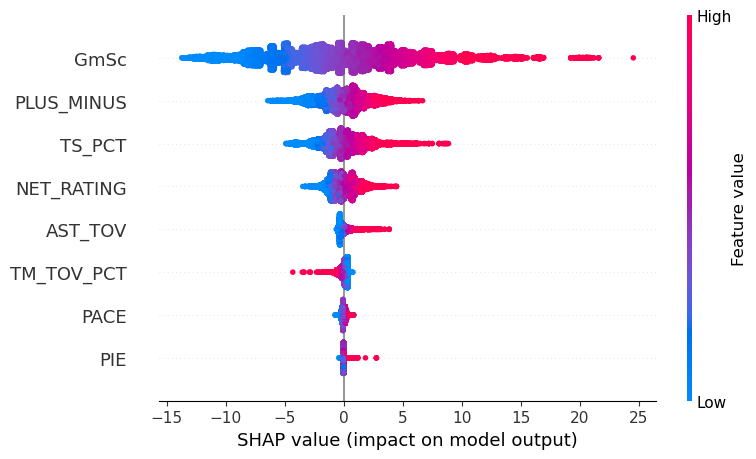

In [246]:
#  Train XGBoost Model to Predict PPI
X = NBA_PPI_metrics_scaled[metrics]
y = NBA_PPI_metrics_scaled['PPI_linear']

model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
model.fit(X, y)

# SHAP Analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# SHAP Summary Plot
shap.summary_plot(shap_values, X)

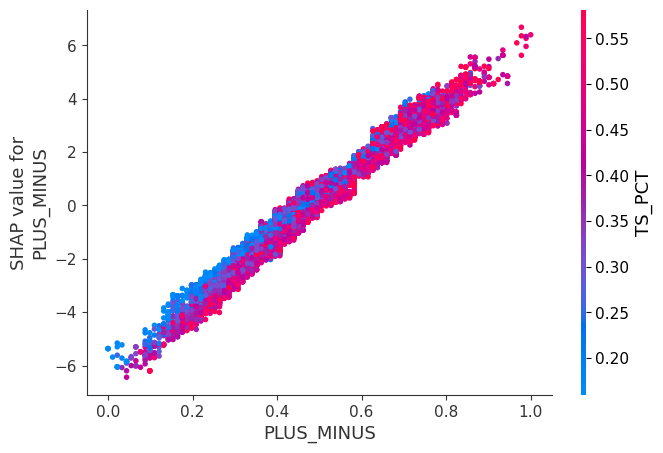

In [247]:
# SHAP Interaction Plot trials
shap.dependence_plot('PLUS_MINUS', shap_values.values, X, interaction_index='TS_PCT')

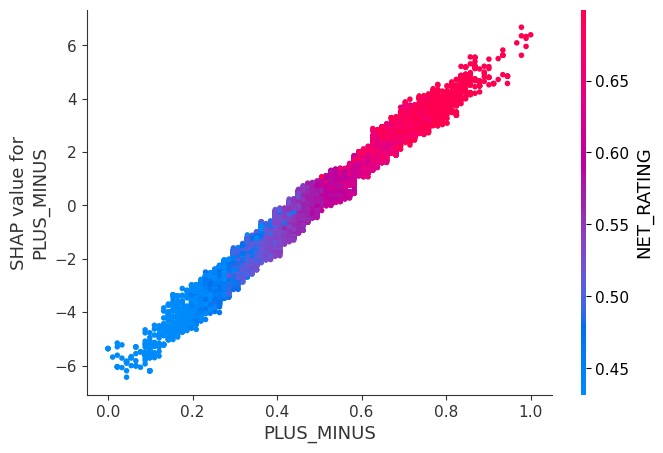

In [248]:
 #SHAP Interaction Plot trials
shap.dependence_plot('PLUS_MINUS', shap_values.values, X, interaction_index='NET_RATING')

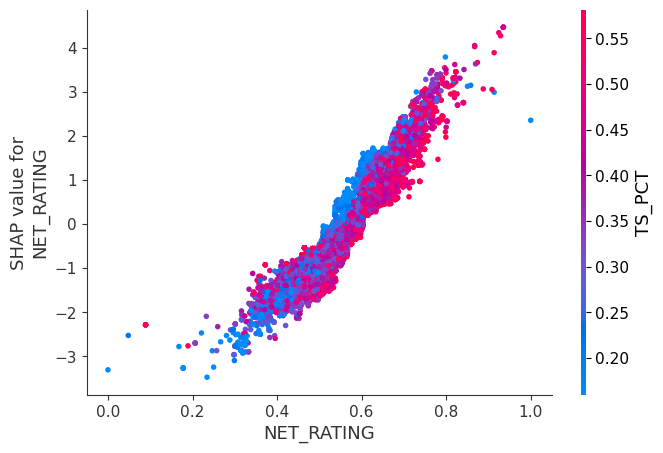

In [251]:
 #SHAP Interaction Plot trials
shap.dependence_plot('NET_RATING', shap_values.values, X, interaction_index='TS_PCT')

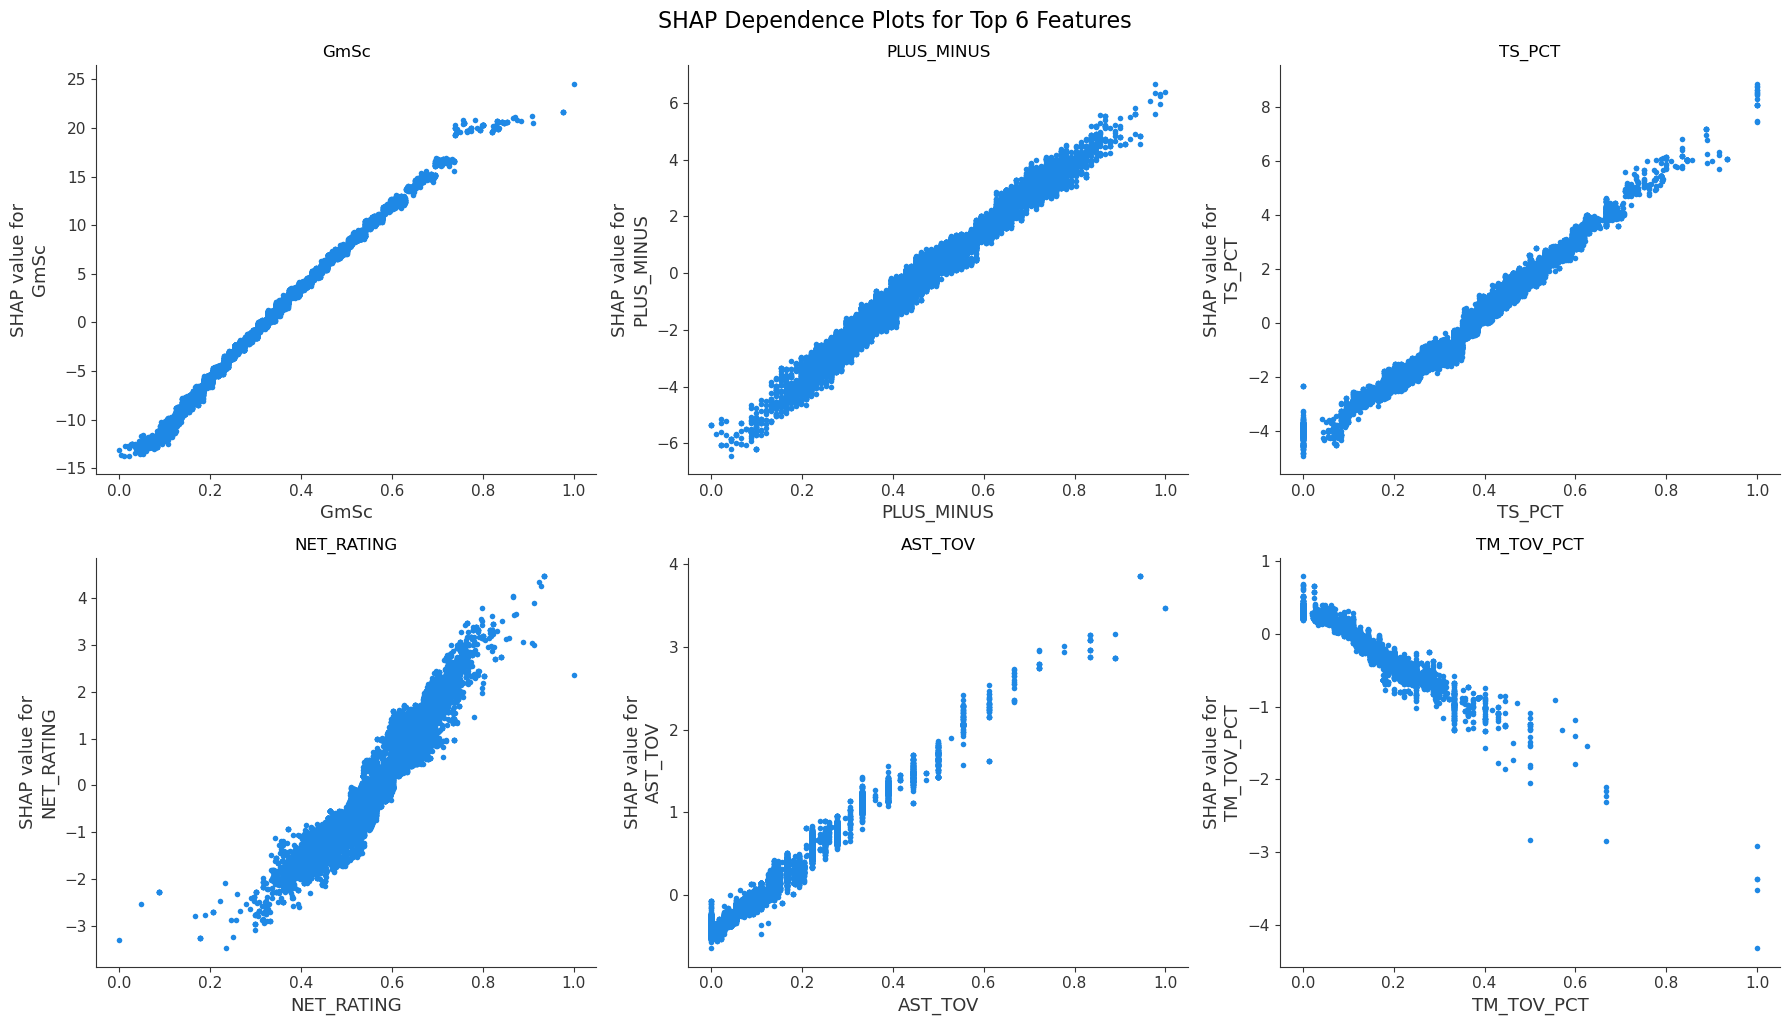

In [250]:
import matplotlib.pyplot as plt

# Step 1: Identify top 6 features by mean absolute SHAP value
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
top_6_indices = np.argsort(shap_abs_mean)[-6:][::-1]
top_6_features = X.columns[top_6_indices]

# Step 2: Create 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Step 3: Flatten axes for easy iteration
axes = axes.flatten()

# Step 4: Plot SHAP dependence for each top feature
for i, feature in enumerate(top_6_features):
    shap.dependence_plot(
        feature,
        shap_values.values,
        X,
        interaction_index=None,
        ax=axes[i],
        show=False
    )
    axes[i].set_title(f"{feature}", fontsize=12)

# Step 5: Final layout adjustments
plt.tight_layout()
plt.suptitle("SHAP Dependence Plots for Top 6 Features", fontsize=16, y=1.02)
plt.show()

### Let's introduce appropriate interaction terms between PLUS_MINUS, NET_RATING and TS_PCT based on SHAP plots

In [285]:
NBA_Analysis_Data.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL',
       ...
       'Cognitive_load', 'Movement_load_normalized', 'Jump_load_normalized',
       'Cognitive_load_normalized', 'Fatigue_index', 'PPI_hybrid',
       'Rest_hrs_normalized', 'FlightDist_km_normalized',
       'ElevationDelta_ft_normalized', 'TSI'],
      dtype='object', length=101)

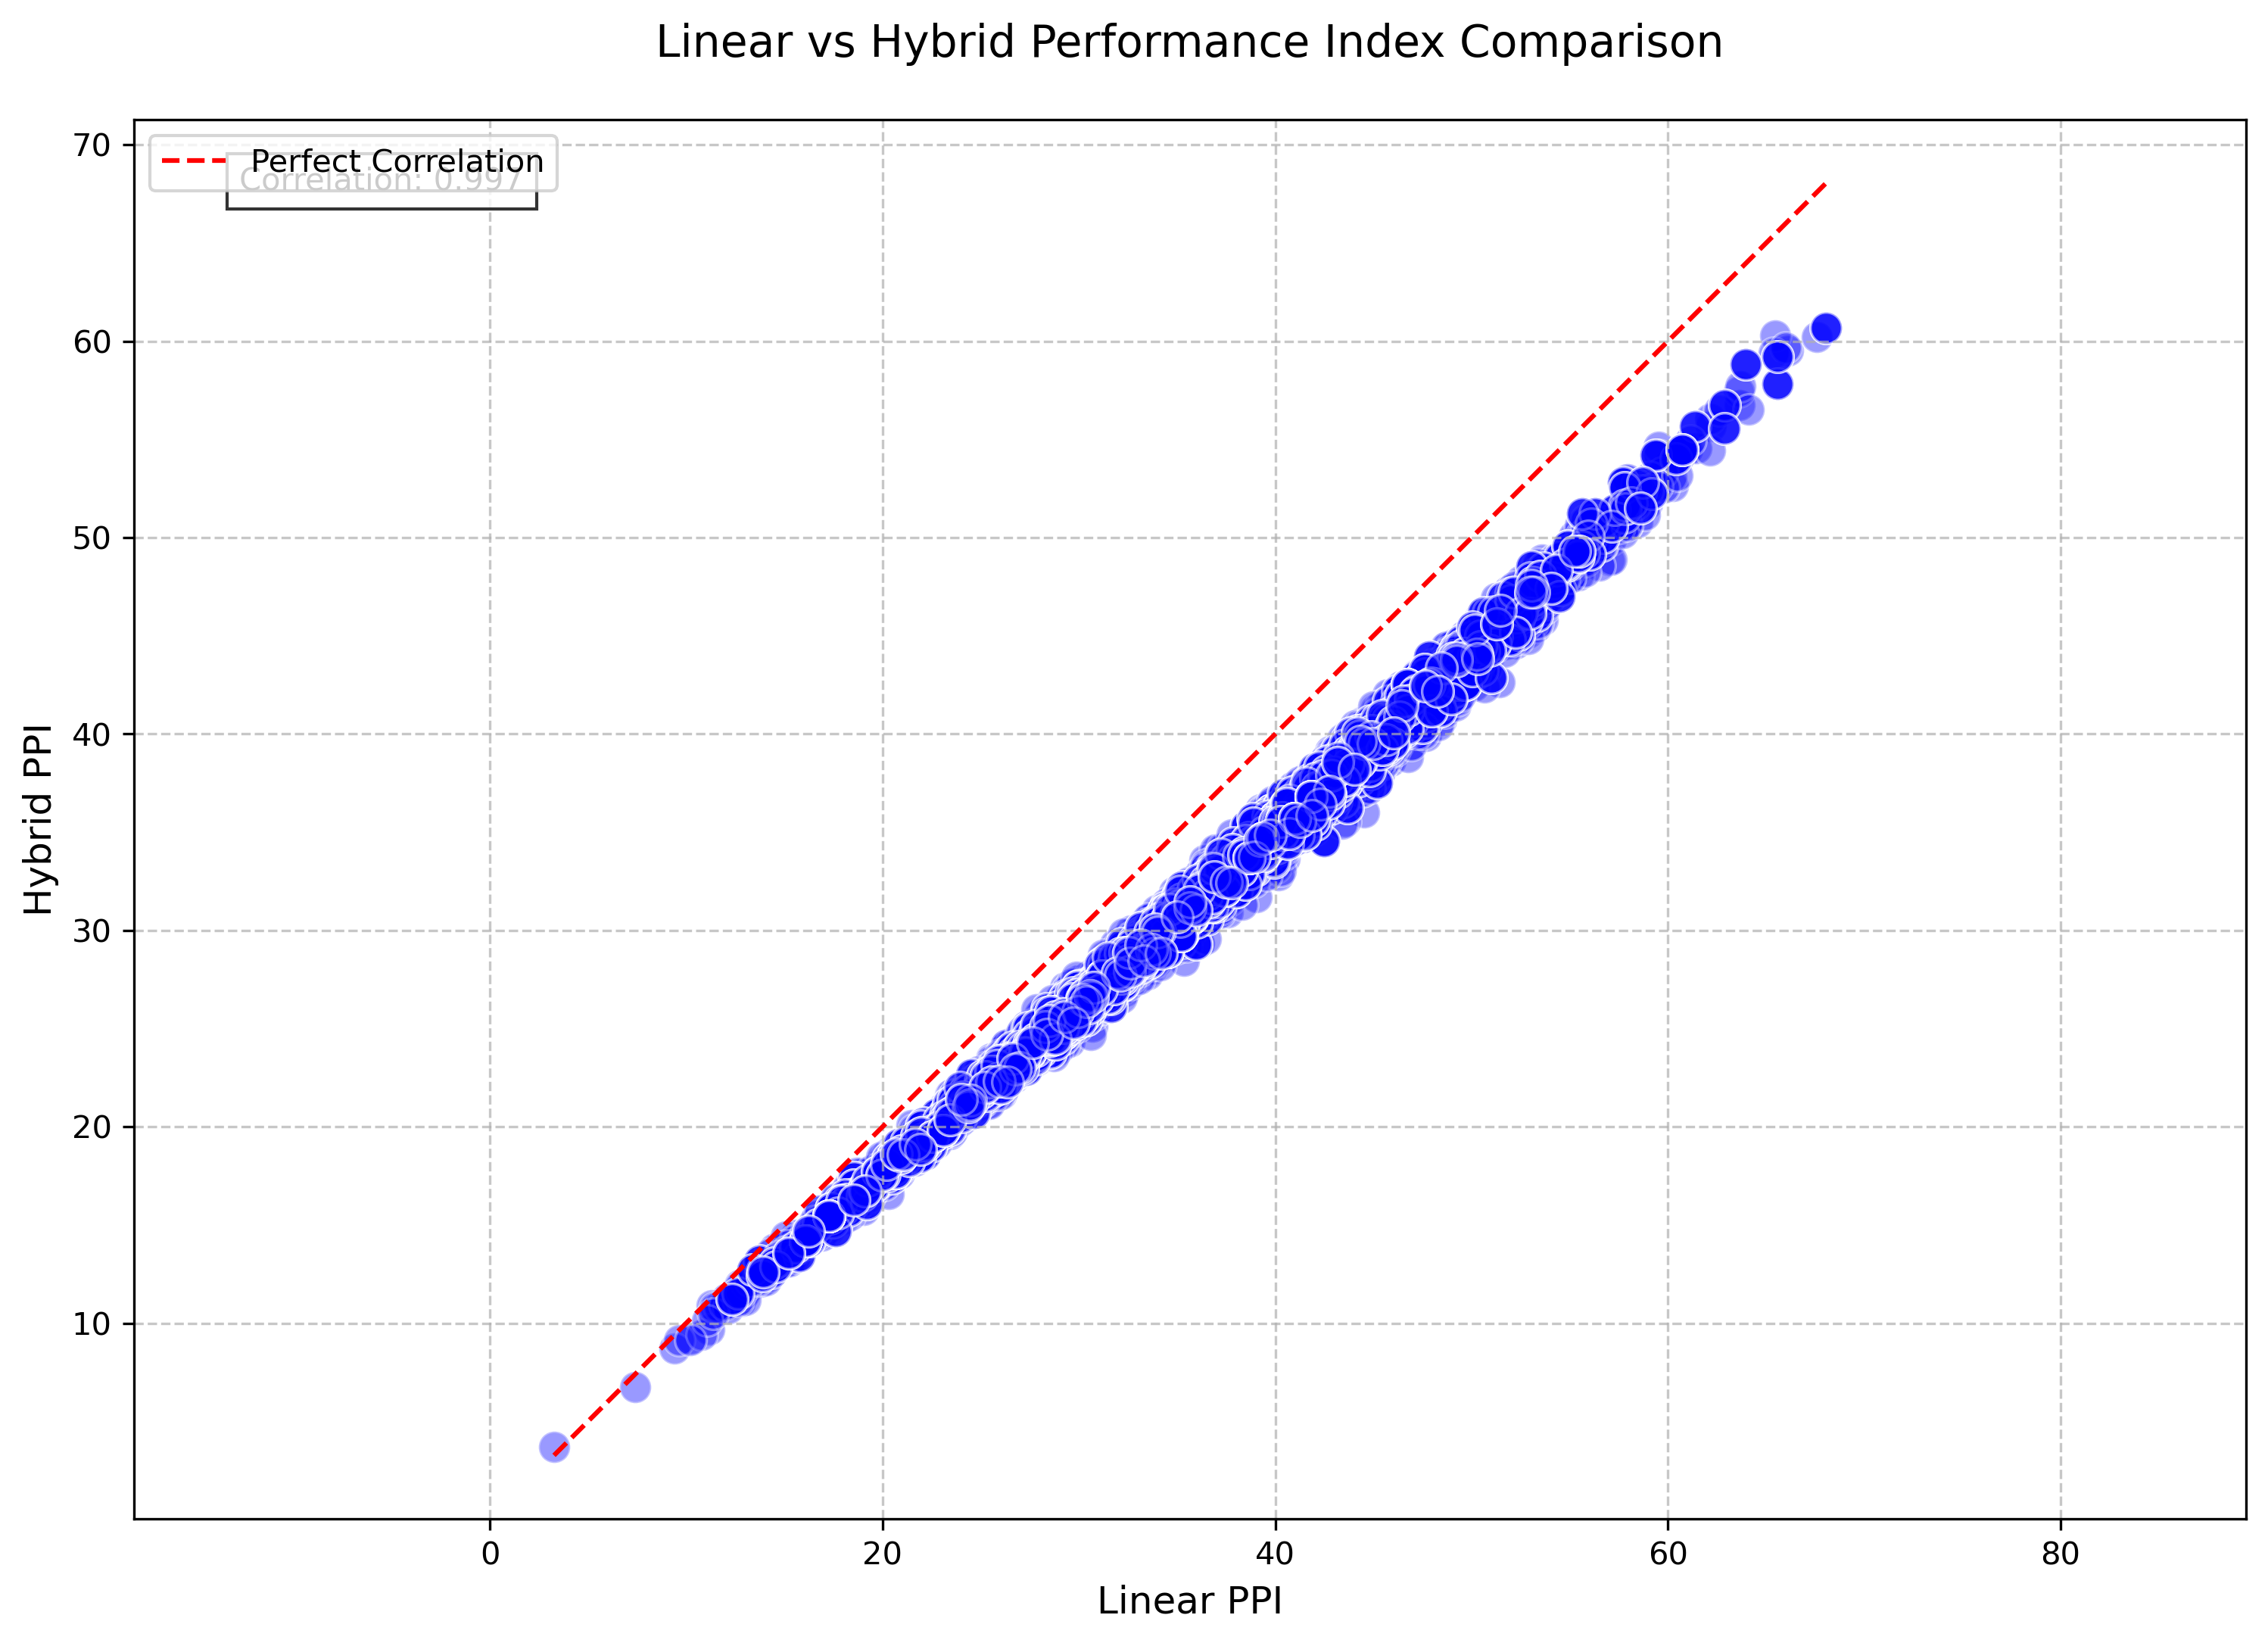

In [259]:
# Enhanced visualization of Hybrid vs Linear PPI comparison
# Updates made:
# 1. Added reference line for perfect correlation
# 2. Enhanced grid and styling
# 3. Added statistical information
# 4. Improved figure size and resolution
# 5. Added more informative labels
try:
    # Create figure with larger size and higher DPI
    plt.figure(figsize=(12, 8), dpi=300)
    
    # Create scatter plot with enhanced styling
    sns.scatterplot(
        x='PPI_linear',
        y='PPI_hybrid',
        data=NBA_PPI_metrics_scaled,
        alpha=0.4,  # Add transparency for better visibility of overlapping points
        s=100,  # Increase point size
        color='blue'  # Use consistent color
    )
    
    # Add reference line for perfect correlation
    min_val = min(NBA_PPI_metrics_scaled['PPI_linear'].min(), NBA_PPI_metrics_scaled['PPI_hybrid'].min())
    max_val = max(NBA_PPI_metrics_scaled['PPI_linear'].max(), NBA_PPI_metrics_scaled['PPI_hybrid'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Correlation')
    
    # Calculate and add correlation coefficient
    correlation = NBA_PPI_metrics_scaled['PPI_linear'].corr(NBA_PPI_metrics_scaled['PPI_hybrid'])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Enhance plot styling
    plt.title('Linear vs Hybrid Performance Index Comparison', pad=20, fontsize=14)
    plt.xlabel('Linear PPI', fontsize=12)
    plt.ylabel('Hybrid PPI', fontsize=12)
    
    # Add grid with improved styling
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(loc='upper left')
    
    # Ensure equal aspect ratio for better comparison
    plt.axis('equal')
    
    # Show the plot
    plt.show()
    
except Exception as e:
    print(f"Error creating visualization: {str(e)}")

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\743316277.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


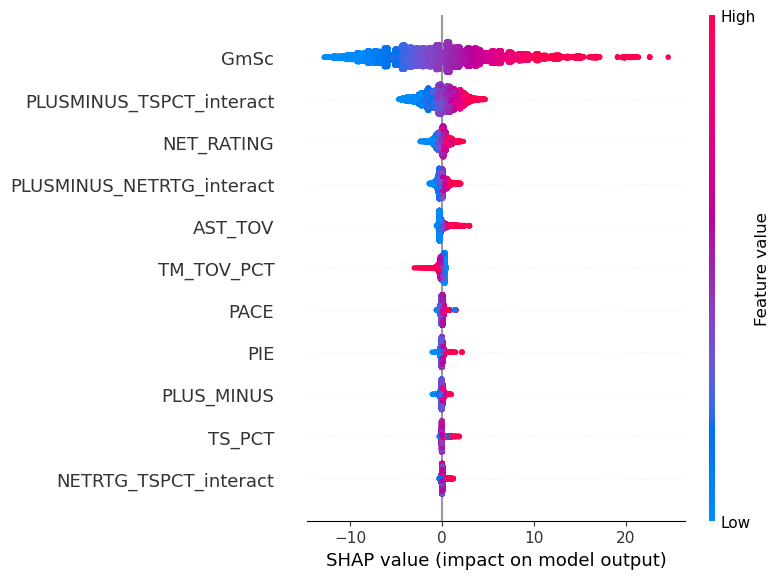

In [263]:
#  Train XGBoost Model to Predict PPI
#
# Select Relevant Metrics
metrics1 = ['GmSc', 'PIE', 'TS_PCT', 'AST_TOV','TM_TOV_PCT', 'PACE', 'NET_RATING',
          'PLUS_MINUS','PLUSMINUS_NETRTG_interact','PLUSMINUS_TSPCT_interact','NETRTG_TSPCT_interact']
X = NBA_PPI_metrics_scaled[metrics1]
y = NBA_PPI_metrics_scaled['PPI_hybrid']

model_hybrid = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
model_hybrid.fit(X, y)

# SHAP Analysis
explainer = shap.Explainer(model_hybrid)
shap_values = explainer(X)

# SHAP Summary Plot
shap.summary_plot(shap_values, X)

### Player Performance Index Calculation

In [356]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select Relevant Metrics
metrics = ['GmSc', 'PIE', 'TS_PCT', 'AST_TOV','TM_TOV_PCT', 'PACE', 'NET_RATING',
          'PLUS_MINUS',]

# Create scaled metrics DataFrame with proper index alignment
NBA_PPI_metrics = NBA_Analysis_Data_1[metrics].copy()
scaler = MinMaxScaler()
NBA_PPI_metrics_scaled = pd.DataFrame(
    scaler.fit_transform(NBA_PPI_metrics),
    columns=metrics,
    index=NBA_PPI_metrics.index  # Preserve original index
)
NBA_PPI_metrics_scaled['PLUSMINUS_NETRTG_interact'] =  NBA_PPI_metrics_scaled['NET_RATING'] *  NBA_PPI_metrics_scaled['PLUS_MINUS']
#
#
NBA_PPI_metrics_scaled['PLUSMINUS_TSPCT_interact'] =  NBA_PPI_metrics_scaled['TS_PCT'] *  NBA_PPI_metrics_scaled['PLUS_MINUS']
#
#
NBA_PPI_metrics_scaled['NETRTG_TSPCT_interact'] =  NBA_PPI_metrics_scaled['TS_PCT'] *  NBA_PPI_metrics_scaled['NET_RATING']
#

# Define Updated Weights based on SHAP impact
weights = {
    'GmSc': 0.5, 'PIE': 0.02, 'TS_PCT': 0.01, 'AST_TOV': 0.05, 'PLUSMINUS_NETRTG_interact':0.04,
    'TM_TOV_PCT': -0.03, 'PACE': 0.02, 'PLUSMINUS_TSPCT_interact':0.14,
    'NET_RATING': 0.09, 'PLUS_MINUS': 0.02,'PLUSMINUS_NETRTG_interact':0.08
}

# Calculate PPI_linear
NBA_PPI_metrics_scaled['PPI_hybrid'] = sum(
    NBA_PPI_metrics_scaled[col] * weights[col] for col in metrics
) * 100

# Add PPI_hybrid to main DataFrame with proper index alignment
NBA_Analysis_Data_1['PPI_hybrid'] = NBA_PPI_metrics_scaled['PPI_hybrid']

# Display results with index information
print("\nUpdated NBA_Analysis_Data with PPI_hybrid:")
print(NBA_Analysis_Data[['Player_ID', 'last_name', 'PPI_hybrid']].head())

# Verify index alignment
print("\nIndex alignment check:")
print("NBA_Analysis_Data index:", NBA_Analysis_Data_1.index[:5].tolist())
print("NBA_PPI_metrics_scaled index:", NBA_PPI_metrics_scaled.index[:5].tolist())


Updated NBA_Analysis_Data with PPI_hybrid:
                Player_ID last_name  PPI_hybrid
Player_ID                                      
2544      6502       2544     James   21.903798
          6501       2544     James   30.287569
          6500       2544     James   37.147776
          6499       2544     James   19.042799
          6498       2544     James   27.046769

Index alignment check:
NBA_Analysis_Data index: [0, 1, 2, 3, 4]
NBA_PPI_metrics_scaled index: [0, 1, 2, 3, 4]


In [546]:
# Add PPI_hybrid to main DataFrame with proper index alignment
NBA_Analysis_Data_1['PPI_hybrid'] = NBA_PPI_metrics_scaled['PPI_hybrid']/100.

In [547]:
NBA_Analysis_Data_1.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,Team,Opp,WL,...,Cognitive_load_normalized,Fatigue_index,PPI_hybrid,Rest_hrs_normalized,FlightDist_km_normalized,ElevationDelta_ft_normalized,TSI,Injured,CAF,FI_normalized
0,2544,James,LeBron,22024,22400062,2024-10-22,LAL vs. MIN,LAL,MIN,W,...,0.299563,9.707735e+05,0.219038,0.031258,0.000000,0.000000,4.0,Healthy,1.214,0.489725
1,2544,James,LeBron,22024,22400085,2024-10-25,LAL vs. PHX,LAL,PHX,W,...,0.284164,1.035611e+06,0.302876,0.028434,0.000000,0.000000,4.0,Healthy,1.232,0.522506
2,2544,James,LeBron,22024,22400096,2024-10-26,LAL vs. SAC,LAL,SAC,W,...,0.469188,1.432209e+06,0.371478,0.005845,0.000000,0.000000,8.0,Healthy,1.308,0.723016
3,2544,James,LeBron,22024,22400111,2024-10-28,LAL @ PHX,LAL,PHX,L,...,0.307406,1.130311e+06,0.190428,0.017629,0.134856,0.160477,6.0,Healthy,1.218,0.570384
4,2544,James,LeBron,22024,22400118,2024-10-30,LAL @ CLE,LAL,CLE,L,...,0.382893,1.054426e+06,0.270468,0.016561,0.157140,0.120121,6.3,Healthy,1.310,0.532018


In [537]:
NBA_Analysis_Data_1['PPI_hybrid'] = NBA_PPI_metrics_scaled['PPI_hybrid']/100.

In [358]:
NBA_Analysis_Data_1.Injury_index.value_counts()

Injury_index
0    11431
3      458
2      434
5      250
1       75
4        8
Name: count, dtype: int64

### Revise the Position to 3 categories - Guard, Forward, Center

In [261]:
# Define the position mapping
position_mapping = {
     'Center-Forward': 'Center',
    'Forward-Center': 'Forward',
     'Forward-Guard': 'Forward',
     'Guard-Forward': 'Guard'
 }
    
    # Update the POSITION column using replace()
NBA_Analysis_Data_1['POSITION'] = NBA_Analysis_Data_1['POSITION'].replace(position_mapping)

Unique positions before update:
['Guard' 'Center' 'Forward']

Unique positions after update:
['Guard' 'Center' 'Forward']


In [359]:
NBA_Analysis_Data_1.POSITION.unique()

array(['Forward', 'Guard', 'Center'], dtype=object)

In [360]:
NBA_Analysis_Data_1.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL',
       ...
       'Movement_load_normalized', 'Jump_load_normalized',
       'Cognitive_load_normalized', 'Fatigue_index', 'PPI_hybrid',
       'Rest_hrs_normalized', 'FlightDist_km_normalized',
       'ElevationDelta_ft_normalized', 'TSI', 'Injured'],
      dtype='object', length=102)

In [270]:
# Updates made:
# 1. Added game time adjustments to NonRest_hr and AdjustedRest_hr
# 2. Created Rest_hrs calculation with timezone consideration
# 3. Added error handling for datetime operations
# 4. Included verification steps
try:
    # First, adjust existing columns for game time
    NBA_Analysis_Data['NonRest_hr'] = NBA_Analysis_Data['NonRest_hr'] + 3
    NBA_Analysis_Data['AdjustedRest_hr'] = NBA_Analysis_Data['AdjustedRest_hr'] - 3
    
    # Sort by Player_ID and GAME_DATE to ensure proper sequential analysis
    NBA_Analysis_Data = NBA_Analysis_Data.sort_values(['Player_ID', 'GAME_DATE'])
    
    # Create Rest_hrs column
    def calculate_rest_hours(group):
        # Convert GAME_DATE to datetime
        group['GAME_DATE'] = pd.to_datetime(group['GAME_DATE'])
        
        # Calculate time difference between consecutive games
        group['Time_Diff'] = group['GAME_DATE'].diff().dt.total_seconds() / 3600
        
        # Account for timezone offset
        group['Time_Diff'] = group['Time_Diff'] + group['TZ_Offset_hr']
        
        # First game for each player should have 0 rest hours
        group.loc[group['Time_Diff'].isna(), 'Time_Diff'] = 0
        
        # Calculate final Rest_hrs by adding to AdjustedRest_hr
        group['Rest_hrs'] = group['AdjustedRest_hr'] + group['Time_Diff']
        
        return group
    
    # Apply the calculation to each player's games
    NBA_Analysis_Data = NBA_Analysis_Data.groupby('Player_ID').apply(calculate_rest_hours)
    
    # Display verification information
    print("\nSample of updated data:")
    print(NBA_Analysis_Data[['Player_ID', 'GAME_DATE', 'NonRest_hr', 'AdjustedRest_hr', 'Rest_hrs', 'TZ_Offset_hr']].head())
    
except Exception as e:
    print(f"Error in rest hours calculation: {str(e)}")


Sample of updated data:
                Player_ID  GAME_DATE  NonRest_hr  AdjustedRest_hr  Rest_hrs  \
Player_ID                                                                     
2544      6502       2544 2024-10-22        6.00            -6.00     -6.00   
          6501       2544 2024-10-25        6.00            -6.00     66.00   
          6500       2544 2024-10-26        6.00            -6.00     18.00   
          6499       2544 2024-10-28        6.96            -5.96     43.04   
          6498       2544 2024-10-30        7.23            -7.23     40.77   

                TZ_Offset_hr  
Player_ID                     
2544      6502             0  
          6501             0  
          6500             0  
          6499             1  
          6498             0  


C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\1103710026.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  NBA_Analysis_Data = NBA_Analysis_Data.groupby('Player_ID').apply(calculate_rest_hours)


## Travel Stress Index Calculation

In [393]:
def compute_tsi(row):
    """
    Compute Travel Stress Index (TSI) based on rest hours, flight distance, and elevation delta
    
    Parameters:
    - row: DataFrame row containing Rest_hrs, FlightDist_km, and ElevationDelta_ft
    
    Returns:
    - TSI: Travel Stress Index score
    """
    # Initialize TSI based on Rest_hrs
    if row['Rest_hrs'] < 23:
        tsi = 8.0
    elif 24 <= row['Rest_hrs'] <= 48:
        tsi = 6.0
    elif 49 <= row['Rest_hrs'] <= 72:
        tsi = 4.0
    else:  # >72 hrs
        tsi = 2.0
    
    # Add flight distance adjustments
    if 600 < row['FlightDist_km'] < 1800:
        tsi += 0.3
    elif 1800 <= row['FlightDist_km'] <= 3600:
        tsi += 0.7
    elif row['FlightDist_km'] > 3600:
        tsi += 1.0
    
    # Add elevation delta adjustments
    if 1000 < row['ElevationDelta_ft'] < 3000:
        tsi += 0.3
    elif row['ElevationDelta_ft'] >= 3000:
        tsi += 1.0
    
    return round(tsi, 2)

# Apply TSI calculation to DataFrame
NBA_Analysis_Data_1['TSI'] = NBA_Analysis_Data_1.apply(compute_tsi, axis=1)

# Display results
print("\nUpdated NBA_Analysis_Data with TSI:")
print(NBA_Analysis_Data_1[['Player_ID', 'last_name', 'Rest_hrs', 'FlightDist_km', 
                         'ElevationDelta_ft', 'TSI']].head(20))


Updated NBA_Analysis_Data with TSI:
    Player_ID last_name  Rest_hrs  FlightDist_km  ElevationDelta_ft  TSI
0        2544     James     72.00            0.0                  0  4.0
1        2544     James     66.00            0.0                  0  4.0
2        2544     James     18.00            0.0                  0  8.0
3        2544     James     43.04          587.0                847  6.0
4        2544     James     40.77          684.0                634  6.3
5        2544     James     41.82          323.4                409  6.0
6        2544     James     64.17          818.4                919  4.3
7        2544     James     38.43          982.8                718  6.3
8        2544     James     33.42         2605.1                 11  6.7
9        2544     James     42.00            0.0                  0  6.0
10       2544     James     66.00            0.0                  0  4.0
11       2544     James     42.99         1945.9                402  6.7
12       2544 

In [394]:
NBA_Analysis_Data_1.TSI.describe()

count    12656.000000
mean         5.927434
std          1.694027
min          2.000000
25%          5.300000
50%          6.000000
75%          6.700000
max          9.700000
Name: TSI, dtype: float64

In [272]:
# Create mask for negative Rest_hrs values
negative_mask = NBA_Analysis_Data['Rest_hrs'] < 0
    
# Update negative values to 72 hours
NBA_Analysis_Data.loc[negative_mask, 'Rest_hrs'] = 72

In [283]:
# Add PPI_hybrid to main DataFrame
NBA_Analysis_Data['PPI_hybrid'] = NBA_PPI_metrics_scaled['PPI_hybrid']

In [289]:
NBA_Analysis_Data.shape

(22344, 101)

In [290]:
NBA_PPI_metrics_scaled.shape

(22344, 13)

In [282]:
NBA_PPI_metrics_scaled.shape

(22344, 13)

## Creating the Fatigue Index feature
### Using running Kinetic Energy, Jumping potential energy with Impact factor, Coginitive Amplification Factor and Travel Stress Factor

In [545]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Map sprint speeds based on position based on Literature search and empirical data (3_qtr_sprint average for athletes by position)
position_sprint_map = {
    'Guard': 17, # Range was 15.8-18.1 mph based on above evaluation
    'Forward': 15, # Range was 14.2-16.3 mph
    'Center': 13 # Range was 11.7-14.4 mph
}
NBA_Analysis_Data_1['Sprint_speed'] = NBA_Analysis_Data_1['POSITION'].map(position_sprint_map)

# Define sprint distance per possession by position
pos_sprint_dist = {
    'Guard': 75,    # feet per transition possession (from 20ft line to basket)
    'Forward': 80,  # feet per transition possession (from 10ft line to 5ft line)
    'Center': 90    # feet per transition possession (almost basket to basket run)
}
NBA_Analysis_Data_1['sprint_dist_per_poss'] = NBA_Analysis_Data_1['POSITION'].map(pos_sprint_dist)

# Calculate movement components - Sprint distance is calcualted based on possessions, transition % and typical sprint distance of a transition play
NBA_Analysis_Data_1['Sprint_dist'] = NBA_Analysis_Data_1['POSS'] * NBA_Analysis_Data_1['Total_Transition_percent'] * NBA_Analysis_Data_1['sprint_dist_per_poss']
NBA_Analysis_Data_1['Sprint_dist_miles'] = NBA_Analysis_Data_1['Sprint_dist'] / 5280  # Convert to miles

# Calculate remaining distances
NBA_Analysis_Data_1['remaining_dist'] = NBA_Analysis_Data_1['DIST'] - NBA_Analysis_Data_1['Sprint_dist_miles']
NBA_Analysis_Data_1['Medium_run_dist'] = 0.14 * NBA_Analysis_Data_1['remaining_dist']
NBA_Analysis_Data_1['Jog_dist'] = 0.29 * NBA_Analysis_Data_1['remaining_dist']
NBA_Analysis_Data_1['Half_court_dist'] = 0.56 * NBA_Analysis_Data_1['remaining_dist']

# Calculate Movement_load based on Kinetic Energy normalized
NBA_Analysis_Data_1['Movement_load'] = (
    (NBA_Analysis_Data_1['WEIGHT'])*0.5*0.447*1609*(
        NBA_Analysis_Data_1['Sprint_dist_miles'] * NBA_Analysis_Data_1['Sprint_speed'] +
        NBA_Analysis_Data_1['Medium_run_dist'] * 10 +
        NBA_Analysis_Data_1['Jog_dist'] * 6 +
        NBA_Analysis_Data_1['Half_court_dist'] * 3
    )
)

# Calculate Jump_load to consider vertical impact loading of floor landing and fatigue on lower body and joints
jump_leap_map = {
    'Guard': 30,    # inches
    'Forward': 35,  # inches
    'Center': 33    # inches
}
NBA_Analysis_Data_1['leap_inches'] = NBA_Analysis_Data_1['POSITION'].map(jump_leap_map)
NBA_Analysis_Data_1['Jump_load'] = NBA_Analysis_Data_1['WEIGHT'] * NBA_Analysis_Data_1['leap_inches'] *0.889*9.81* (
    (NBA_Analysis_Data_1['REB'] + NBA_Analysis_Data_1['BLK']) * 1. +
    NBA_Analysis_Data_1['FGA'] * 0.7 +
    NBA_Analysis_Data_1['DFGA'] * 0.9
)

# Calculate Cognitive_load, Play making, participating in team sets requires attention, focus and speed - adding to physical stress
# We use a factor called Cognitive Amplification Factor which is based on a player's Usage percentage. Higer usage will mean higher cognitive stress
NBA_Analysis_Data_1['CAF'] = 1.0 + NBA_Analysis_Data_1['USG_PCT']

# Calculate Fatigue_index based enegy expended per min
NBA_Analysis_Data_1['Fatigue_index'] = (
    (NBA_Analysis_Data_1['Movement_load']+0.1*
    NBA_Analysis_Data_1['Jump_load']))*NBA_Analysis_Data_1['CAF']
#
NBA_Analysis_Data_1['Fatigue_index']=(1.0+alpha*((NBA_Analysis_Data_1['TSI']-1)/9.))*NBA_Analysis_Data_1['Fatigue_index']
# Initialize scaler
scaler = MinMaxScaler()

# Normalize Rest_hrs (inverted since more rest is better)
NBA_Analysis_Data_1['FI_normalized'] = scaler.fit_transform(
    NBA_Analysis_Data_1[['Fatigue_index']]
).ravel()
#
# Travel Stress Amplified Fatigue Index, with a max 50$ fatigue amplification due to travel stress, lack of sleep etc
alpha = 0.5
#NBA_Analysis_Data_1['FI_n_TSI']=NBA_Analysis_Data_1['FI_normalized']*(1.0+alpha*((NBA_Analysis_Data_1['TSI']-1)/9.))

# Display results
print("\nUpdated NBA_Analysis_Data with new columns:")
result_cols = ['Player_ID', 'last_name', 'POSITION', 'USG_PCT',
               'Movement_load', 'Jump_load', 'CAF',
               'Fatigue_index', 'FI_normalized']
print(NBA_Analysis_Data_1[result_cols].head(20))


Updated NBA_Analysis_Data with new columns:
    Player_ID last_name POSITION  USG_PCT  Movement_load     Jump_load    CAF  \
0        2544     James  Forward    0.214  606839.329059  7.857379e+05  1.214   
1        2544     James  Forward    0.232  668933.813044  5.157487e+05  1.232   
2        2544     James  Forward    0.308  667568.945388  1.208029e+06  1.308   
3        2544     James  Forward    0.218  671921.314676  5.434399e+05  1.218   
4        2544     James  Forward    0.310  566433.126968  5.538241e+05  1.310   
5        2544     James  Forward    0.220  652551.422034  6.507433e+05  1.220   
6        2544     James  Forward    0.207  671084.312503  7.580467e+05  1.207   
7        2544     James  Forward    0.337  696295.054750  9.484238e+05  1.337   
8        2544     James  Forward    0.211  567753.223188  9.518852e+05  1.211   
9        2544     James  Forward    0.229  568649.393354  8.099677e+05  1.229   
10       2544     James  Forward    0.326  668760.312919  1.0730

In [432]:
NBA_Analysis_Data_1.to_excel('NBA_Analysis_Data_2.xlsx', index=False)

In [443]:
NBA_Analysis_Data_1.columns

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL',
       ...
       'Fatigue_index', 'PPI_hybrid', 'Rest_hrs_normalized',
       'FlightDist_km_normalized', 'ElevationDelta_ft_normalized', 'TSI',
       'Injured', 'CAF', 'FI_normalized', 'FI_n_TSI'],
      dtype='object', length=105)

In [440]:
NBA_Analysis_Data_1['FI_n_TSI'].describe()

count    12577.000000
mean        52.263133
std         15.235648
min          0.000000
25%         42.175473
50%         52.217786
75%         62.325859
max        125.322322
Name: FI_n_TSI, dtype: float64

In [535]:
NBA_Analysis_Data_1.head()

,Player_ID,last_name,first_name,SEASON_ID,Game_ID,GAME_DATE,MATCHUP,Team,Opp,WL,...,Cognitive_load_normalized,Fatigue_index,PPI_hybrid,Rest_hrs_normalized,FlightDist_km_normalized,ElevationDelta_ft_normalized,TSI,Injured,CAF,FI_normalized
0,2544,James,LeBron,22024,22400062,2024-10-22,LAL vs. MIN,LAL,MIN,W,...,0.299563,9.707735e+05,21.903798,0.031258,0.000000,0.000000,4.0,Healthy,1.214,0.489725
1,2544,James,LeBron,22024,22400085,2024-10-25,LAL vs. PHX,LAL,PHX,W,...,0.284164,1.035611e+06,30.287569,0.028434,0.000000,0.000000,4.0,Healthy,1.232,0.522506
2,2544,James,LeBron,22024,22400096,2024-10-26,LAL vs. SAC,LAL,SAC,W,...,0.469188,1.432209e+06,37.147776,0.005845,0.000000,0.000000,8.0,Healthy,1.308,0.723016
3,2544,James,LeBron,22024,22400111,2024-10-28,LAL @ PHX,LAL,PHX,L,...,0.307406,1.130311e+06,19.042799,0.017629,0.134856,0.160477,6.0,Healthy,1.218,0.570384
4,2544,James,LeBron,22024,22400118,2024-10-30,LAL @ CLE,LAL,CLE,L,...,0.382893,1.054426e+06,27.046769,0.016561,0.157140,0.120121,6.3,Healthy,1.310,0.532018


In [303]:
print(NBA_Analysis_Data.columns)

Index(['Player_ID', 'last_name', 'first_name', 'SEASON_ID', 'Game_ID',
       'GAME_DATE', 'MATCHUP', 'Team', 'Opp', 'WL',
       ...
       'Cognitive_load', 'Movement_load_normalized', 'Jump_load_normalized',
       'Cognitive_load_normalized', 'Fatigue_index', 'PPI_hybrid',
       'Rest_hrs_normalized', 'FlightDist_km_normalized',
       'ElevationDelta_ft_normalized', 'TSI'],
      dtype='object', length=101)


In [699]:
NBA_Analysis_Data_Final = pd.read_excel("NBA_Analysis_Data_3.xlsx")

## Exploratory Data Analysis

In [315]:
import seaborn as sns

In [325]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Creates a bar plot with labeled values showing either counts or percentages.

    Parameters:
    -----------
    data : DataFrame
        Input DataFrame containing the feature to visualize
    feature : str
        Name of the column to visualize
    perc : bool, optional
        Whether to display percentages instead of counts (default: False)
    n : int, optional
        Number of top categories to display (default: None, shows all)

    Returns:
    --------
    fig : Figure
        The matplotlib figure object
    """
    # Calculate total for percentage calculations
    total = len(data[feature])
    
    # Determine number of categories to display
    if n is None:
        n = data[feature].nunique()
    
    # Create figure with appropriate width
    plt.figure(figsize=(max(n + 1, 8), 6))
    
    # Create bar plot
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().head(n).index,
    )
    
    # Add value labels on top of each bar
    for p in ax.patches:
        if perc:
            # Calculate percentage
            label = f"{100 * p.get_height() / total:.1f}%"
        else:
            # Use count
            label = f"{int(p.get_height())}"
        
        # Position the label above the bar
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_height(),
            label,
            ha='center',
            va='bottom',
            fontsize=10,
            rotation=0
        )
    
    # Customize plot appearance
    plt.title(f'Distribution of {feature}', pad=20, fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Count' if not perc else 'Percentage', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return plt.gcf()

In [714]:
NBA_Analysis_Data_Final.shape

(12577, 167)

In [715]:
NBA_Analysis_Data_Final.head()

,index,GAME_DATE,Player_ID,last_name,first_name,SEASON_ID,Game_ID,MATCHUP,Team,Opp,...,GmSc_rolling_14D,GmSc_season_sum,NET_RATING_rolling_7D,NET_RATING_rolling_14D,EFG_PCT_rolling_7D,EFG_PCT_rolling_14D,TS_PCT_rolling_7D,TS_PCT_rolling_14D,USG_PCT_rolling_7D,USG_PCT_rolling_14D
0,0,2024-10-22,2544,James,LeBron,22024,22400062,LAL vs. MIN,LAL,MIN,...,10.100000,NaN,-8.800,-8.800,0.469000,0.469000,0.487000,0.487000,0.214000,0.214000
1,1,2024-10-25,2544,James,LeBron,22024,22400085,LAL vs. PHX,LAL,PHX,...,14.000000,NaN,4.150,4.150,0.542000,0.542000,0.561500,0.561500,0.223000,0.223000
2,2,2024-10-26,2544,James,LeBron,22024,22400096,LAL vs. SAC,LAL,SAC,...,18.366667,NaN,7.800,7.800,0.573333,0.573333,0.598667,0.598667,0.251333,0.251333
3,3,2024-10-28,2544,James,LeBron,22024,22400111,LAL @ PHX,LAL,PHX,...,15.500000,NaN,-0.675,-0.675,0.501500,0.501500,0.531750,0.531750,0.243000,0.243000
4,4,2024-10-30,2544,James,LeBron,22024,22400118,LAL @ CLE,LAL,CLE,...,16.000000,NaN,-5.125,-5.860,0.567000,0.547400,0.612000,0.587000,0.267000,0.256400


In [713]:
NBA_Analysis_Data_Final.drop(columns=['NET_RATING_season_sum','EFG_PCT_season_sum','TS_PCT_season_sum'],inplace=True)

In [317]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [320]:
# Initialize variables to track previous row
prev_game_date = None
prev_player_id = None
prev_injury_status = None
prev_injury_index = None

# Iterate through rows to update injury status
for idx, row in NBA_Analysis_Data_1.iterrows():
    # Check if current row has high rest hours
    if row['Rest_hrs'] > 200:
        # Only update if we have a previous game AND same player
        if prev_game_date is not None and prev_player_id == row['Player_ID']:
            # Update previous row's injury status
            NBA_Analysis_Data_1.loc[
                (NBA_Analysis_Data_1['GAME_DATE'] == prev_game_date) & 
                (NBA_Analysis_Data_1['Player_ID'] == prev_player_id),
                'Injury_Status'
            ] = 'Out'
            NBA_Analysis_Data_1.loc[
                (NBA_Analysis_Data_1['GAME_DATE'] == prev_game_date) & 
                (NBA_Analysis_Data_1['Player_ID'] == prev_player_id),
                'Injury_index'
            ] = 5
    
    # Store current row's values for next iteration
    prev_game_date = row['GAME_DATE']
    prev_player_id = row['Player_ID']
    prev_injury_status = row['Injury_Status']
    prev_injury_index = row['Injury_index']

# Display verification of changes
print("\nVerification of changes:")
print("Number of rows with Injury_Status 'Out':", 
      (NBA_Analysis_Data_1['Injury_Status'] == 'Out').sum())
print("Number of rows with Injury_index 5:", 
      (NBA_Analysis_Data_1['Injury_index'] == 5).sum())

# Show sample of modified rows
print("\nSample of modified rows:")
modified_rows = NBA_Analysis_Data_1[
    (NBA_Analysis_Data_1['Injury_Status'] == 'Out') |
    (NBA_Analysis_Data_1['Injury_index'] == 5)
]
print(modified_rows[['GAME_DATE', 'Player_ID', 'Injury_Status', 'Injury_index', 'Rest_hrs']].head())


Verification of changes:
Number of rows with Injury_Status 'Out': 250
Number of rows with Injury_index 5: 250

Sample of modified rows:
     GAME_DATE  Player_ID Injury_Status  Injury_index  Rest_hrs
22  2024-12-06       2544           Out             5     42.25
57  2025-03-08       2544           Out             5     42.50
160 2024-11-08     201142           Out             5     42.25
164 2024-12-03     201142           Out             5     66.50
286 2024-11-17     201144           Out             5     41.94


In [322]:
NBA_Analysis_Data_1.Injury_index.value_counts()

Injury_index
0    11431
3      458
2      434
5      250
1       75
4        8
Name: count, dtype: int64

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\2650381876.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


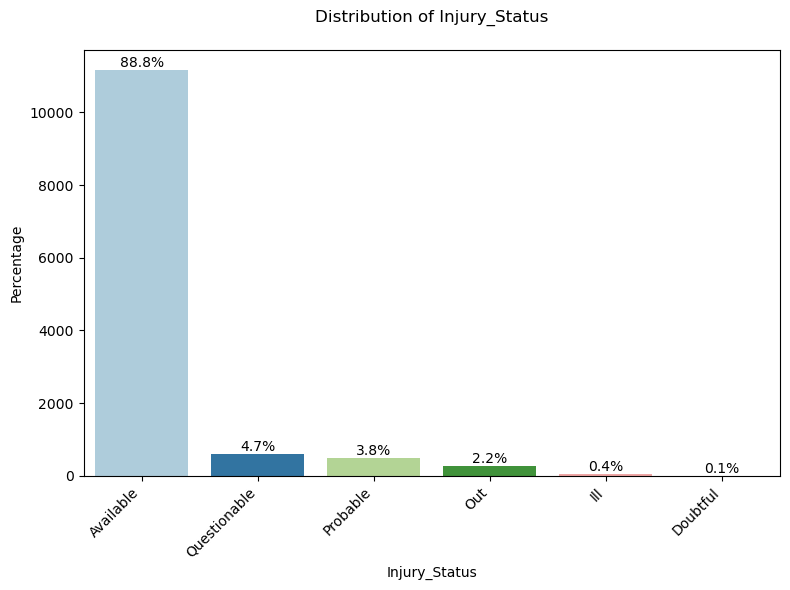

In [716]:
labeled_barplot(NBA_Analysis_Data_Final,'Injury_Status', perc=True)

In [925]:
NBA_Analysis_Data_Final.shape

(12577, 139)

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\2965700555.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


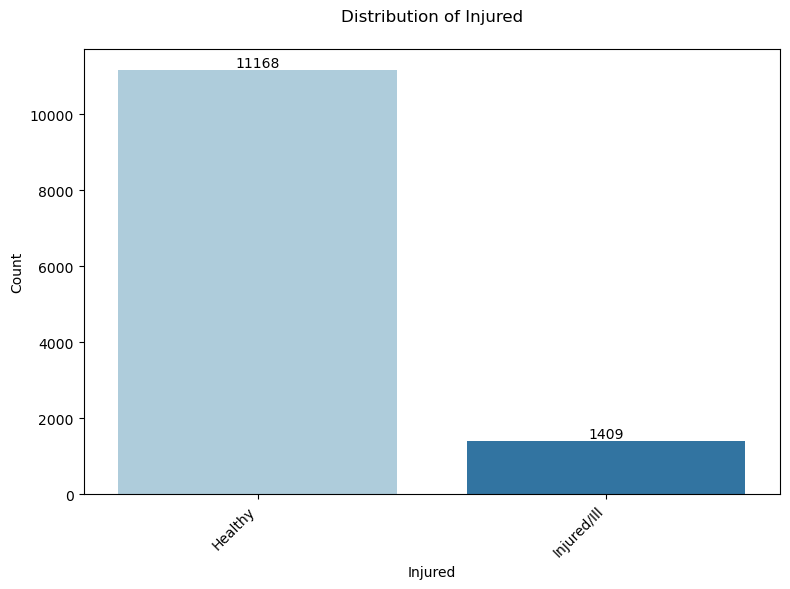

In [926]:
labeled_barplot(NBA_Analysis_Data_Final,'Injured', perc=False)

In [328]:
NBA_Analysis_Data_1.Player_ID.nunique()

204

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\3188613800.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


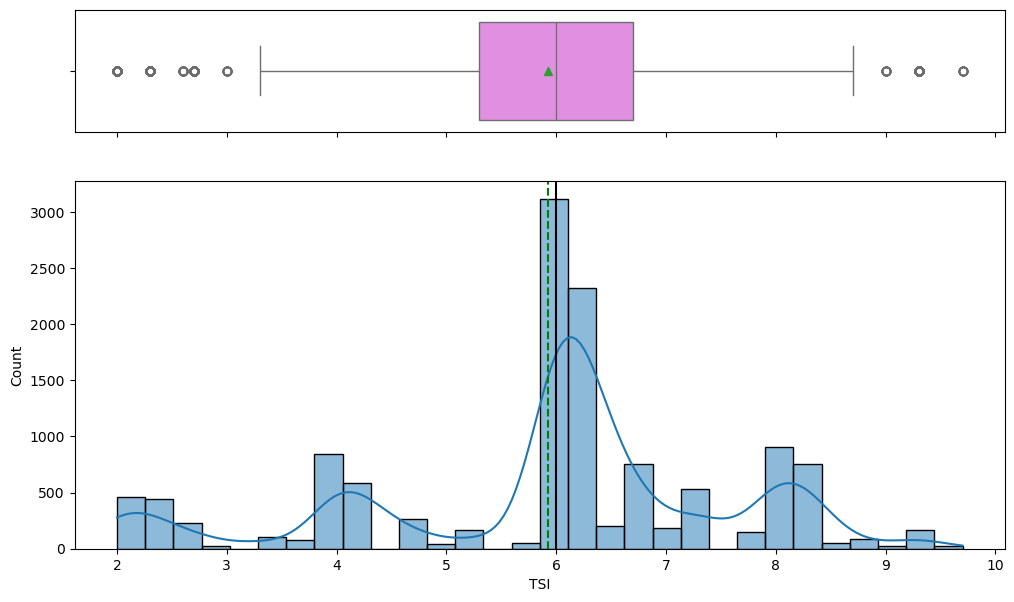

In [719]:
histogram_boxplot(NBA_Analysis_Data_Final, 'TSI', figsize=(12, 7), kde=True, bins=30)
plt.show()


Position Distribution (Unique Players):
POSITION
Guard      104
Forward     74
Center      25
Name: count, dtype: int64


C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\2650381876.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


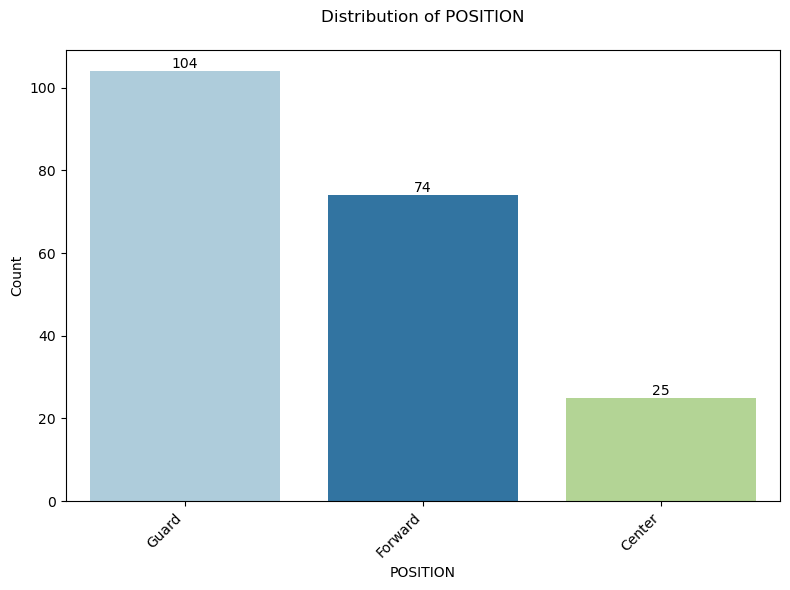

In [720]:
# Get unique players and their positions
unique_players = NBA_Analysis_Data_Final.drop_duplicates(subset=['Player_ID', 'POSITION'])

# Display the distribution
print("\nPosition Distribution (Unique Players):")
position_counts = unique_players['POSITION'].value_counts()
print(position_counts)

# Create visualization
labeled_barplot(unique_players, 'POSITION', perc=False)

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\3188613800.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


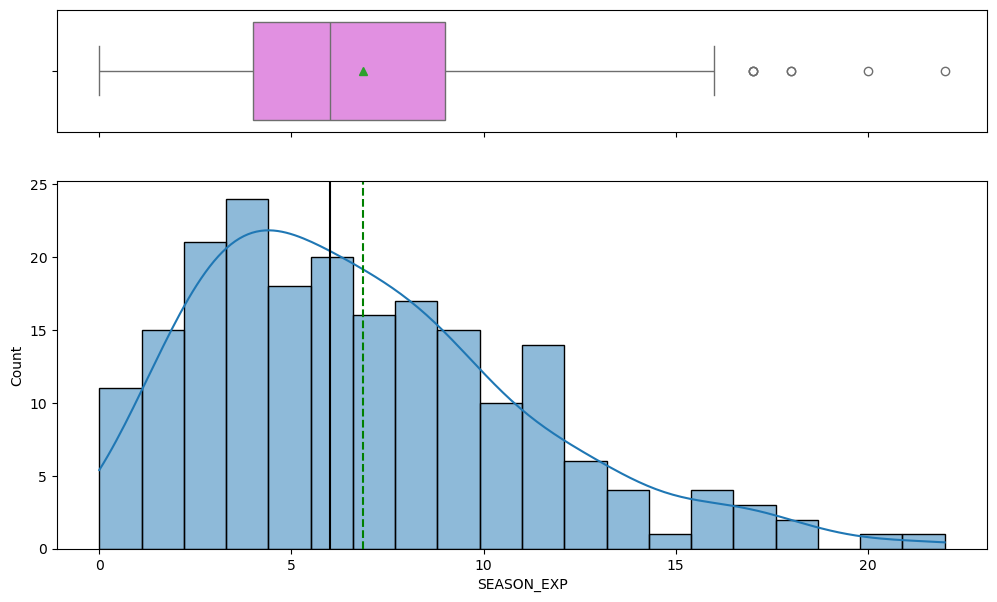

In [722]:
histogram_boxplot(unique_players, 'SEASON_EXP', figsize=(12, 7), kde=True, bins=20)
plt.show()

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\3188613800.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


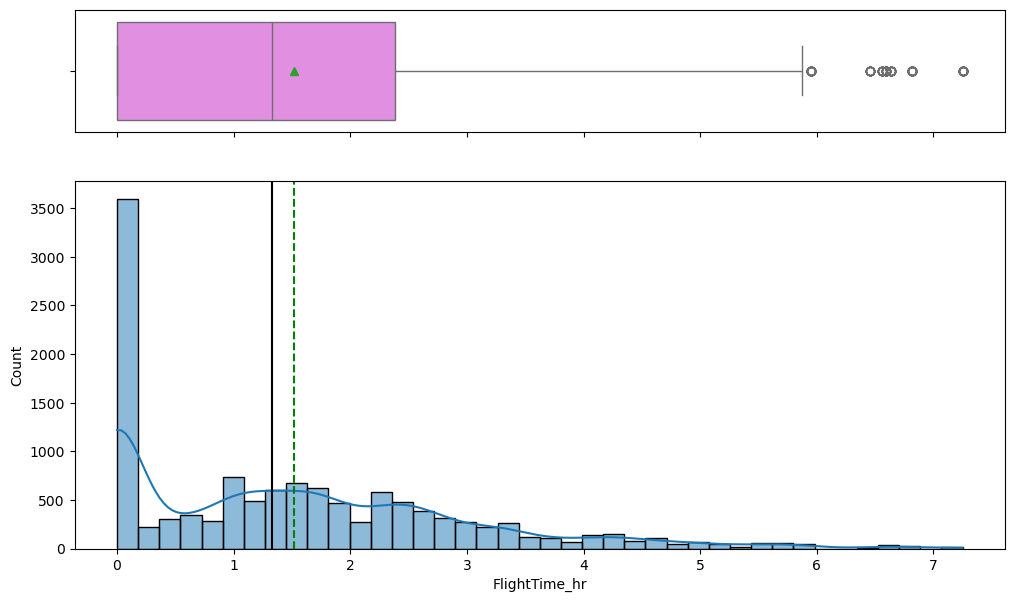

In [724]:
histogram_boxplot(Rest_hrs, 'FlightTime_hr',figsize=(12, 7), kde=True, bins=40)
plt.show()

In [723]:
Rest_hrs = NBA_Analysis_Data_Final[NBA_Analysis_Data_Final['Rest_hrs']<200.]

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\3188613800.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


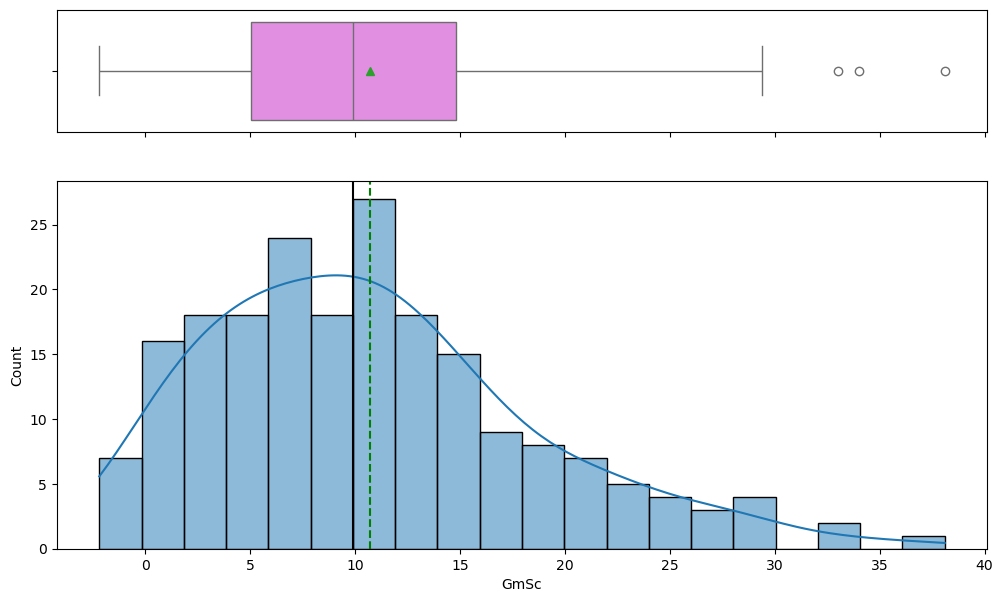

In [353]:
histogram_boxplot(unique_players, 'GmSc', figsize=(12, 7), kde=True, bins=20)
plt.show()

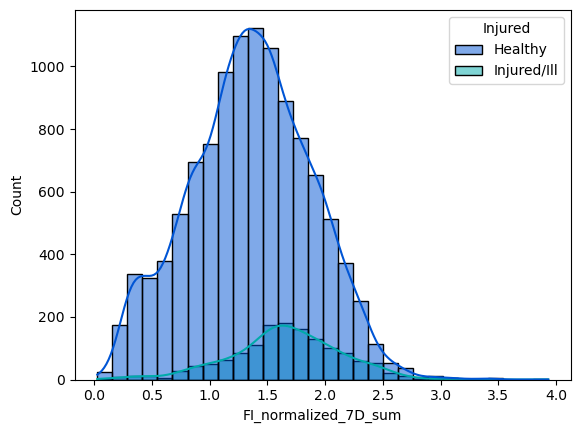

In [737]:
 sns.histplot(
        data=NBA_Analysis_Data_Final, x='FI_normalized_7D_sum', kde=True, bins=30, palette="winter",hue='Injured')
plt.show()

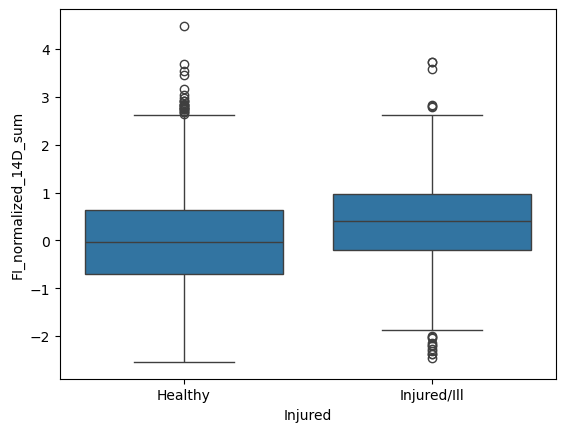

In [16]:
sns.boxplot(data=NBA_Analysis_Data_Final, x='Injured',y='FI_normalized_14D_sum')
plt.show()

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\3188613800.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


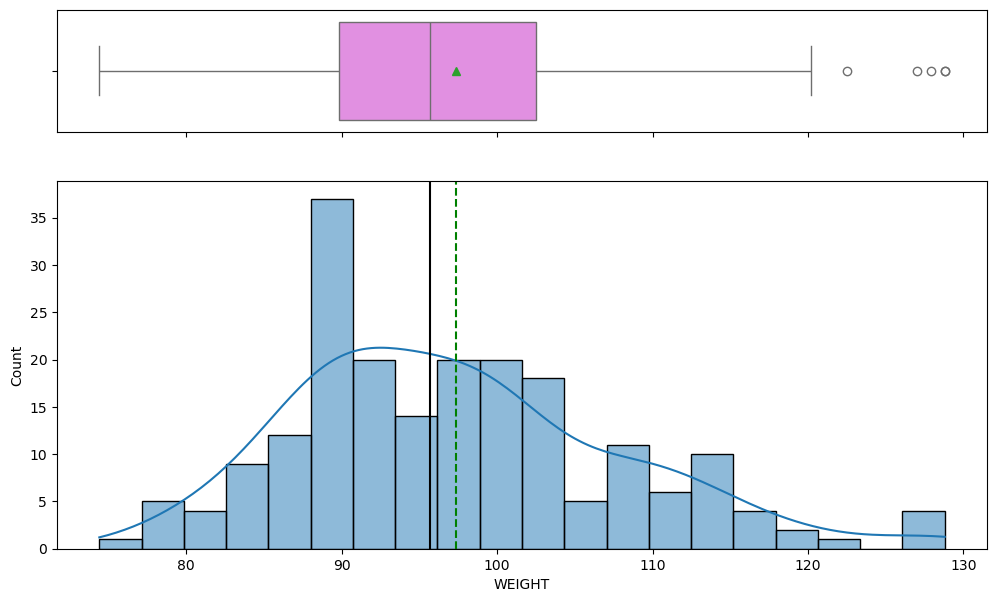

In [337]:
histogram_boxplot(unique_players, 'WEIGHT', figsize=(12, 7), kde=True, bins=20)
plt.show()

In [754]:
# Create new 'Injured' column based on Injury_Status
NBA_Analysis_Data_Final['Injured_index'] = np.where(
    NBA_Analysis_Data_Final['Injury_Status'] == 'Available',
    0,
    1
)

In [757]:
NBA_Analysis_Data_Final.Injured_index.info

<bound method Series.info of 0        0
1        0
2        0
3        0
4        0
        ..
12572    0
12573    0
12574    0
12575    0
12576    0
Name: Injured_index, Length: 12577, dtype: int32>

C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\2965700555.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


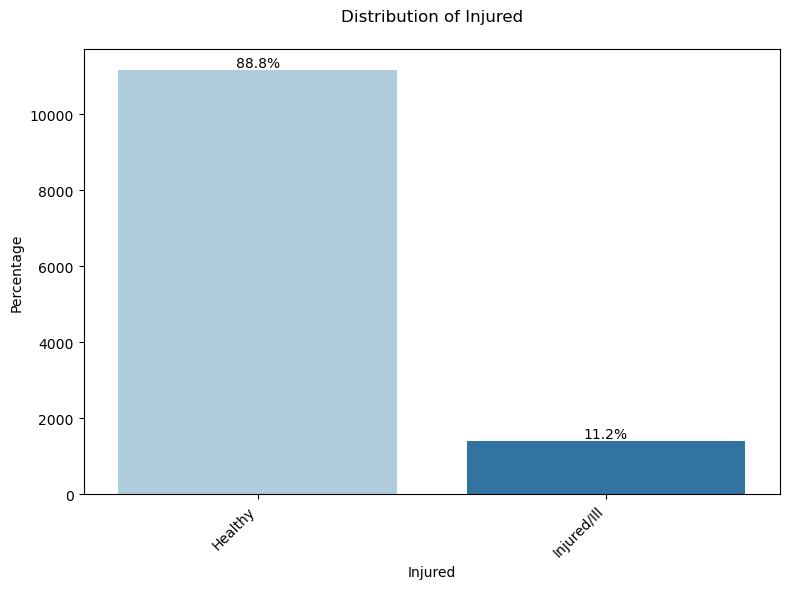

In [742]:
# Create visualization
labeled_barplot(NBA_Analysis_Data_Final, 'Injured', perc=True)

In [9]:
# Convert 'Injured' column to binary
NBA_Analysis_Data_Final['Injured_cat'] = NBA_Analysis_Data_Final['Injured'].map({
    'Healthy': 0,
    'Injured/Ill': 1
})

In [10]:
NBA_correl = NBA_Analysis_Data_Final[['Injured_cat','MIN_7D_sum', 'Rest_hrs_7D_sum', 'POSS_7D_sum','FI_normalized_7D_sum', 'TSI', 'PPI_hybrid_7D_avg']].corr(method='pearson')

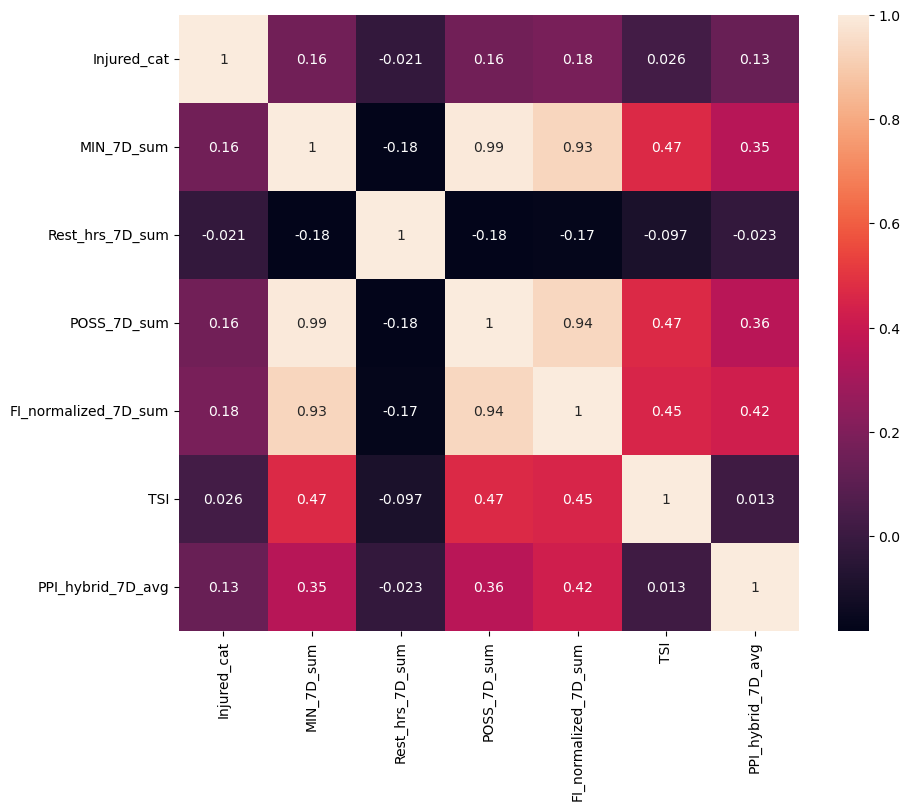

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(NBA_correl,annot=True)
plt.show()

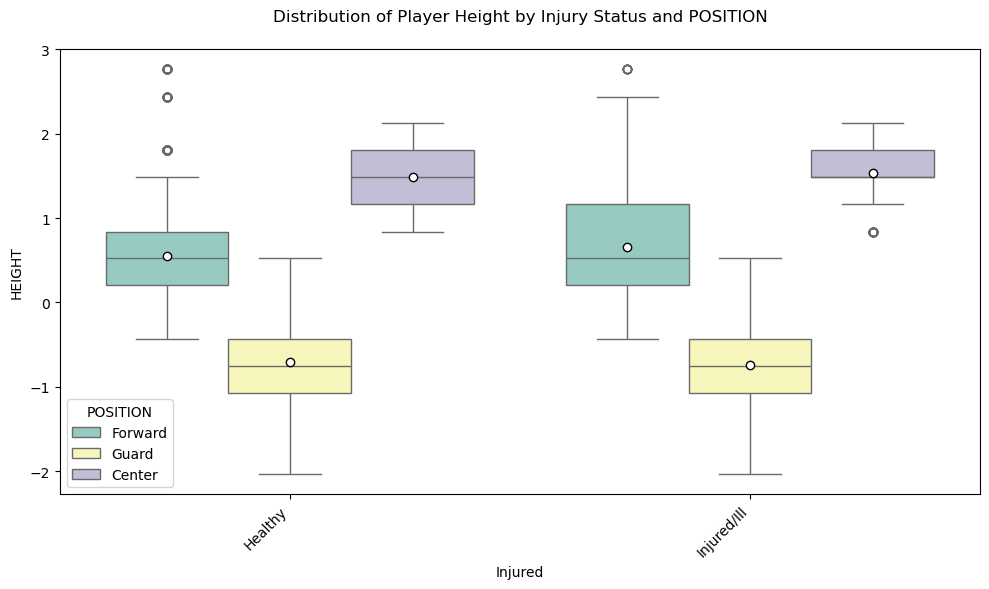


Fatigue index Statistics by Position:
           count      mean       std       min       25%       50%       75%  \
POSITION                                                                       
Center    1629.0  0.299601  1.051138 -2.355837 -0.375679  0.337523  1.016793   
Forward   4217.0  0.112431  1.045557 -2.532543 -0.590069  0.136244  0.839191   
Guard     6731.0 -0.142946  0.930919 -2.566732 -0.777536 -0.117732  0.524983   

               max  
POSITION            
Center    4.794177  
Forward   3.875997  
Guard     3.269931  


In [932]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Creates a bar plot with labeled values showing either counts or percentages.

    Parameters:
    -----------
    data : DataFrame
        Input DataFrame containing the feature to visualize
    feature : str
        Name of the column to visualize
    perc : bool, optional
        Whether to display percentages instead of counts (default: False)
    n : int, optional
        Number of top categories to display (default: None, shows all)

    Returns:
    --------
    fig : Figure
        The matplotlib figure object
    """
    # Calculate total for percentage calculations
    total = len(data[feature])
    
    # Determine number of categories to display
    if n is None:
        n = data[feature].nunique()
    
    # Create figure with appropriate width
    plt.figure(figsize=(max(n + 1, 8), 6))
    
    # Create bar plot
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().head(n).index,
    )
    
    # Add value labels on top of each bar
    for p in ax.patches:
        if perc:
            # Calculate percentage
            label = f"{100 * p.get_height() / total:.1f}%"
        else:
            # Use count
            label = f"{int(p.get_height())}"
        
        # Position the label above the bar
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_height(),
            label,
            ha='center',
            va='bottom',
            fontsize=10,
            rotation=0
        )
    
    # Customize plot appearance
    plt.title(f'Distribution of {feature}', pad=20, fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Count' if not perc else 'Percentage', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    return plt.gcf()

# Create vertical box plot of F1_normalized by POSITION
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=NBA_Analysis_Data_Final,
    x='Injured',
    y='HEIGHT',
    hue='POSITION',
    palette='Set3',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"}
)

# Customize the plot
plt.title('Distribution of Player Height by Injury Status and POSITION', pad=20, fontsize=12)
plt.xlabel('Injured', fontsize=10)
plt.ylabel('HEIGHT', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

# Display summary statistics
print("\nFatigue index Statistics by Position:")
print(NBA_Analysis_Data_Final.groupby('POSITION')['FI_normalized_7D_sum'].describe())

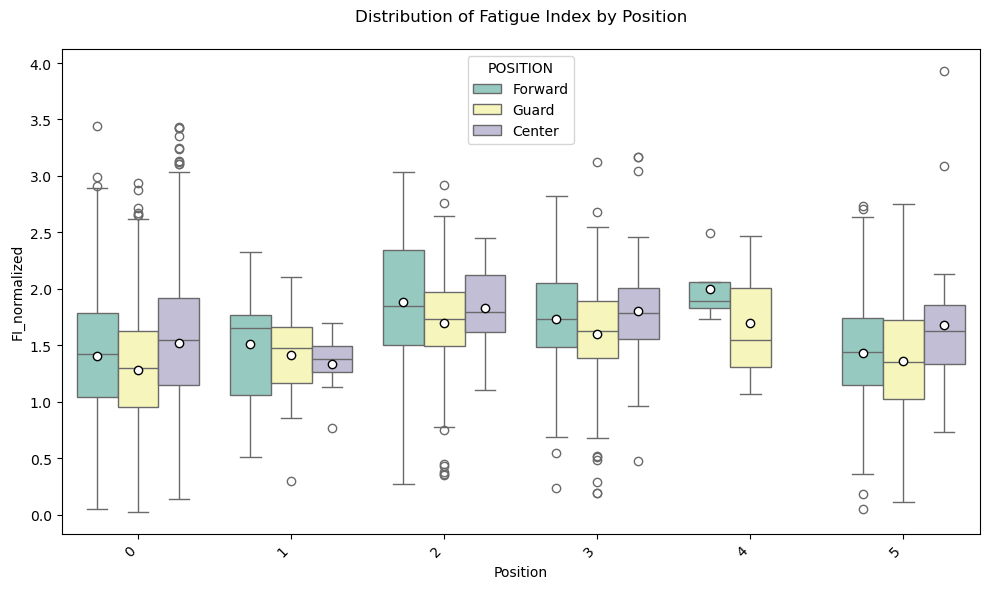

In [728]:
# Create vertical box plot of F1_normalized by POSITION
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=NBA_Analysis_Data_Final,
    x='Injury_index',
    y='FI_normalized_7D_sum',
    hue='POSITION',
    palette='Set3',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"}
)

# Customize the plot
plt.title('Distribution of Fatigue Index by Position', pad=20, fontsize=12)
plt.xlabel('Position', fontsize=10)
plt.ylabel('FI_normalized', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

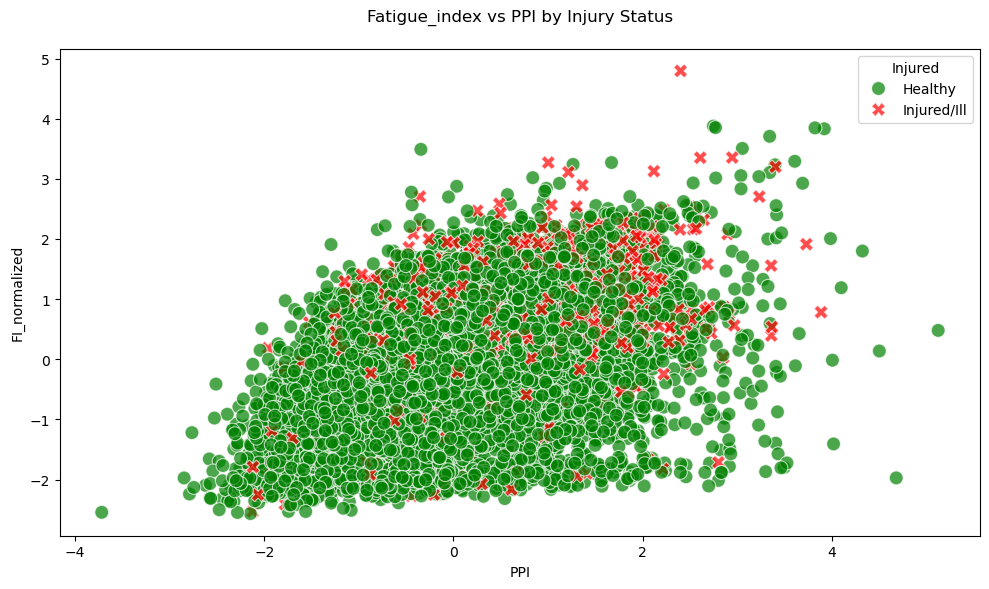

In [90]:
# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=NBA_Analysis_Data_Final,
    x='PPI_hybrid_7D_avg',
    y='FI_normalized_7D_sum',
    hue='Injured',
    style='Injured',  # Different markers for each injury status
    s=100,           # Point size
    alpha=0.7,       # Transparency
    palette=['green', 'red']  # Green for Healthy, Red for Injured/Ill
)

# Customize the plot
plt.title('Fatigue_index vs PPI by Injury Status', pad=20, fontsize=12)
plt.xlabel('PPI', fontsize=10)
plt.ylabel('FI_normalized', fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

### Injured Players show higher Fatigue clearly
### Asso a mild positive correlation is seen between Fatigue and Performance in general - Athletes strain more for performance
### Tableau timeline plots indicate phases during season where hgih fatigue and travel stressed players show performance decline

## Creating Rolling sum (Fatigue and related), Rolling Averages for 7-day (Performance and related), 14-day and season-to-date windows
### This will be used for Injury risk modeling and time-series models

In [731]:
del NBA_Analysis_Data_1

In [605]:
NBA_Analysis_Data.shape

(12656, 104)

In [681]:
#
def calculate_rolling_metrics():
    # Get global NBA_Analysis_Data_1 dataframe
    global NBA_Analysis_Data_1
    
    # Ensure GAME_DATE is datetime and sorted
    NBA_Analysis_Data_1['GAME_DATE'] = pd.to_datetime(NBA_Analysis_Data_1['GAME_DATE'])
    NBA_Analysis_Data_1 = NBA_Analysis_Data_1.sort_values(by=['Player_ID', 'GAME_DATE'])
    
    # Set GAME_DATE as index for time-based rolling
    NBA_Analysis_Data_1.set_index('GAME_DATE', inplace=True)

    # Define metrics groups
    sum_metrics = ['FI_normalized', 'Rest_hrs', 'DIST', 'POSS', 'MIN']
    avg_metrics = ['PPI_hybrid', 'GmSc', 'NET_RATING', 'EFG_PCT', 'TS_PCT', 'USG_PCT']

    windows = ['7D', '14D']
    for metric in sum_metrics:
        for window in windows:
            # Use groupby().transform() for rolling sum
            NBA_Analysis_Data_1[f'{metric}_{window}_sum'] = NBA_Analysis_Data_1.groupby('Player_ID')[metric].transform(
                lambda x: x.rolling(window, min_periods=1).sum()
            )
        # Season-to-date sum using expanding().sum()
        NBA_Analysis_Data_1[f'{metric}_season_sum'] = NBA_Analysis_Data_1.groupby('Player_ID')[metric].transform(
            lambda x: x.expanding(min_periods=1).sum()
        )

    for metric in avg_metrics:
        for window in windows:
            # Use groupby().transform() for rolling mean
            NBA_Analysis_Data_1[f'{metric}_{window}_avg'] = NBA_Analysis_Data_1.groupby('Player_ID')[metric].transform(
                lambda x: x.rolling(window, min_periods=1).mean()
            )
        # Season-to-date average
        NBA_Analysis_Data_1[f'{metric}_season_avg'] = NBA_Analysis_Data_1.groupby('Player_ID')[metric].transform(
            lambda x: x.expanding(min_periods=1).mean()
        )

    # Reset index if needed
    NBA_Analysis_Data_1.reset_index(inplace=True)

    return NBA_Analysis_Data_1

# Usage example
NBA_Analysis_Data_1 = calculate_rolling_metrics()


In [685]:
import pandas as pd

def calculate_custom_date_window():
    global NBA_Analysis_Data_1
    
    # Ensure GAME_DATE is datetime
    NBA_Analysis_Data_1['GAME_DATE'] = pd.to_datetime(NBA_Analysis_Data_1['GAME_DATE'])
    # Sort data by Player and GAME_DATE
    NBA_Analysis_Data_1 = NBA_Analysis_Data_1.sort_values(by=['Player_ID', 'GAME_DATE'])

    # Define metric lists
    sum_metrics = ['FI_normalized', 'Rest_hrs', 'DIST', 'POSS', 'MIN']
    avg_metrics = ['PPI_hybrid', 'GmSc', 'NET_RATING', 'EFG_PCT', 'TS_PCT', 'USG_PCT']
    
    # Initialize new columns
    for metric in sum_metrics + avg_metrics:
        NBA_Analysis_Data_1[f'{metric}_rolling_7D'] = pd.NA
        NBA_Analysis_Data_1[f'{metric}_rolling_14D'] = pd.NA
        NBA_Analysis_Data_1[f'{metric}_season_sum'] = pd.NA
        NBA_Analysis_Data_1[f'{metric}_season_avg'] = pd.NA

    # Function to process each player's data
    def process_player(group):
        group = group.copy()
        group = group.reset_index()  # Keep a reset index for safe assignment
        dates = group['GAME_DATE']
        
        for idx in range(len(group)):
            current_date = dates.iloc[idx]
            # For each row, define the window start dates
            start_7D = current_date - pd.Timedelta(days=7)
            start_14D = current_date - pd.Timedelta(days=14)
            
            # Masks for the date ranges
            mask_7D = (dates >= start_7D) & (dates <= current_date)
            mask_14D = (dates >= start_14D) & (dates <= current_date)
            
            # For all metrics, compute sums and means
            for metric in sum_metrics:
                # If no games in window, result remains NA
                sum_7D = group.loc[mask_7D, metric].sum()
                sum_14D = group.loc[mask_14D, metric].sum()
                # For season sum (cumulative up to current date)
                season_sum = group.loc[:idx, metric].sum()

                group.at[idx, f'{metric}_rolling_7D'] = sum_7D
                group.at[idx, f'{metric}_rolling_14D'] = sum_14D
                group.at[idx, f'{metric}_season_sum'] = season_sum

            for metric in avg_metrics:
                subset_7D = group.loc[mask_7D, metric]
                subset_14D = group.loc[mask_14D, metric]
                season_mean = group.loc[:idx, metric].mean()

                # Handle empty slices
                group.at[idx, f'{metric}_rolling_7D'] = subset_7D.mean() if len(subset_7D) > 0 else pd.NA
                group.at[idx, f'{metric}_rolling_14D'] = subset_14D.mean() if len(subset_14D) > 0 else pd.NA
                group.at[idx, f'{metric}_season_avg'] = season_mean if len(group.loc[:idx, metric]) > 0 else pd.NA

        return group

    # Apply processing for each player
    result = NBA_Analysis_Data_1.groupby('Player_ID').apply(process_player).reset_index(drop=True)

    return result

# Usage:
NBA_Analysis_Data_1 = calculate_custom_date_window()


C:\Users\MuraliSAI\AppData\Local\Temp\ipykernel_32600\96435501.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = NBA_Analysis_Data_1.groupby('Player_ID').apply(process_player).reset_index(drop=True)


### Create column to reflect prior injury existing or not for a player on given game date

In [762]:
import pandas as pd
import numpy as np

def create_injury_prev_column(df):
    """
    Creates Injury_prev column based on injury history per player.
    Updates: Now marks NEXT row as 'Yes' after injury detection, not current row.
    Uses Player_ID and GAME_DATE columns.
    
    Args:
        df (DataFrame): NBA_Analysis_Data_Final dataframe
        
    Returns:
        DataFrame: Updated dataframe with Injury_prev column
    """
    # Initialize empty result list to store values
    injury_prev_values = []
    
    # Group by Player_ID and process each group separately
    for _, player_group in df.groupby('Player_ID'):
        # Sort by GAME_DATE within each player group
        player_data = player_group.sort_values('GAME_DATE')
        
        # Track if we've seen an injury (>1) for this player
        had_injury = False
        
        # Process each row for this player
        for idx, row in player_data.iterrows():
            # First row always gets 'No'
            if len(injury_prev_values) == len(df[df['Player_ID'] == player_group.iloc[0]['Player_ID']]):
                injury_prev_values.append('No')
            else:
                # If we haven't seen an injury yet and current row has injury (>1)
                if not had_injury and row['Injury_index'] > 1:
                    # Mark current row as 'No' but set flag for next row
                    injury_prev_values.append('No')
                    had_injury = True
                elif had_injury:
                    # All subsequent rows after first injury get 'Yes'
                    injury_prev_values.append('Yes')
                else:
                    # No injury yet, mark as 'No'
                    injury_prev_values.append('No')
        
        # Add remaining rows for this player if any
        while len(injury_prev_values) < len(df[df['Player_ID'] == player_group.iloc[0]['Player_ID']]):
            injury_prev_values.append('No')
    
    # Create and add the new column
    df['Injury_prev'] = injury_prev_values
    
    return df

# Apply the function to your dataframe
NBA_Analysis_Data_Final = create_injury_prev_column(NBA_Analysis_Data_Final)

In [764]:
NBA_Analysis_Data_Final.to_excel('NBA_Analysis_Data_final.xlsx', index=False)

In [4]:
NBA_Analysis_Data_Final.shape

(12577, 139)

In [2]:
import pandas as pd
import numpy as np

In [3]:
NBA_Analysis_Data_Final = pd.read_excel('NBA_Analysis_Data_final.xlsx')

In [7]:
NBA_Analysis_Data_Final.Injured.value_counts()

Injured
Healthy        11168
Injured/Ill     1409
Name: count, dtype: int64

# ANALYSIS SECTION

## Analysis 1 - Test of Independence for Injured vs Healthy by position

In [766]:
# Import required statistical analysis tools
from scipy.stats import chi2_contingency
import pandas as pd

def analyze_injuries_by_position(df):
    """
    Analyzes relationship between injuries and player positions using chi-square test.
    
    Args:
        df (DataFrame): NBA_Analysis_Data_Final dataframe
        
    Returns:
        tuple: Contingency table and chi-square test statistics
    """
    # Create contingency table showing injury counts by position
    contingency = pd.crosstab(
        df['Injured'], 
        df['POSITION'],
        margins=True  # Adds row and column totals
    )
    
    # Calculate chi-square test statistics
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    # Display formatted results
    print("\nContingency Table (Injury Counts by Position):")
    print("================================================")
    print(contingency)
    
    print("\nChi-Square Test Results:")
    print("=========================")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    print("\nExpected Frequencies:")
    print("=====================")
    print(expected.round(2))
    
    return contingency, {
        'chi2': chi2,
        'p_value': p_value,
        'degrees_of_freedom': dof,
        'expected_frequencies': expected
    }

# Apply the analysis to NBA data
contingency_table, test_stats = analyze_injuries_by_position(NBA_Analysis_Data_Final)


Contingency Table (Injury Counts by Position):
POSITION     Center  Forward  Guard    All
Injured                                   
Healthy        1459     3657   6052  11168
Injured/Ill     170      560    679   1409
All            1629     4217   6731  12577

Chi-Square Test Results:
Chi-square statistic: 27.6606
P-value: 0.0001
Degrees of freedom: 6

Expected Frequencies:
[[ 1446.5   3744.57  5976.93 11168.  ]
 [  182.5    472.43   754.07  1409.  ]
 [ 1629.    4217.    6731.   12577.  ]]


## Analysis 2: ANOVA F-oneway to compare Fatigue and Playerpoerformance by POSITION

In [907]:
df = pd.read_excel('NBA_Analysis_Data_final.xlsx')

In [917]:
df.FI_normalized_7D_sum.head()

0    0.489725
1    1.012231
2    1.735247
3    2.305631
4    2.347924
Name: FI_normalized_7D_sum, dtype: float64

In [918]:
df.POSITION.unique()

array(['Forward', 'Guard', 'Center'], dtype=object)

In [922]:
from scipy.stats import f_oneway
import pandas as pd
from tabulate import tabulate

# Define groups
groups = ['Guard', 'Forward', 'Center']
group_data = {
    pos: df[df['POSITION'] == pos]['FI_normalized_7D_sum'].dropna()
    for pos in groups
}

# Run ANOVA
anova_result = f_oneway(*group_data.values())

# Build summary data
summary_rows = [
    [pos, group_data[pos].mean(), group_data[pos].std(), len(group_data[pos])]
    for pos in groups
]

# Append ANOVA result
summary_rows.append([
    'ANOVA', '', '', '',
    f"{anova_result.statistic:.3f}", f"{anova_result.pvalue:.4f}"
])

# Define headers
headers = ['Group', 'Mean', 'Std Dev', 'N', 'F-statistic', 'p-value']

# Print formatted table
print(tabulate(summary_rows, headers=headers, tablefmt='grid'))

+---------+--------------------+---------------------+------+---------------+-----------+
| Group   | Mean               | Std Dev             | N    |   F-statistic |   p-value |
+=========+====================+=====================+======+===============+===========+
| Guard   | 1.312460403985773  | 0.49374721120526377 | 6731 |               |           |
+---------+--------------------+---------------------+------+---------------+-----------+
| Forward | 1.4479091865937859 | 0.5545494667475613  | 4217 |               |           |
+---------+--------------------+---------------------+------+---------------+-----------+
| Center  | 1.5471815592296871 | 0.5575095148797883  | 1629 |               |           |
+---------+--------------------+---------------------+------+---------------+-----------+
| ANOVA   |                    |                     |      |       173.132 |         0 |
+---------+--------------------+---------------------+------+---------------+-----------+


In [923]:
from scipy.stats import f_oneway
import pandas as pd
from tabulate import tabulate

# Define groups
groups = ['Guard', 'Forward', 'Center']
group_data = {
    pos: df[df['POSITION'] == pos]['PPI_hybrid_7D_avg'].dropna()
    for pos in groups
}

# Run ANOVA
anova_result = f_oneway(*group_data.values())

# Build summary data
summary_rows = [
    [pos, group_data[pos].mean(), group_data[pos].std(), len(group_data[pos])]
    for pos in groups
]

# Append ANOVA result
summary_rows.append([
    'ANOVA', '', '', '',
    f"{anova_result.statistic:.3f}", f"{anova_result.pvalue:.4f}"
])

# Define headers
headers = ['Group', 'Mean', 'Std Dev', 'N', 'F-statistic', 'p-value']

# Print formatted table
print(tabulate(summary_rows, headers=headers, tablefmt='grid'))

+---------+---------------------+----------------------+------+---------------+-----------+
| Group   | Mean                | Std Dev              | N    |   F-statistic |   p-value |
+=========+=====================+======================+======+===============+===========+
| Guard   | 0.24070712077439704 | 0.05358252862988384  | 6731 |               |           |
+---------+---------------------+----------------------+------+---------------+-----------+
| Forward | 0.2420753501154978  | 0.05455238332718535  | 4217 |               |           |
+---------+---------------------+----------------------+------+---------------+-----------+
| Center  | 0.25835080430151774 | 0.052849336176325194 | 1629 |               |           |
+---------+---------------------+----------------------+------+---------------+-----------+
| ANOVA   |                     |                      |      |        72.562 |         0 |
+---------+---------------------+----------------------+------+---------------+-

In [924]:
from scipy.stats import f_oneway
import pandas as pd
from tabulate import tabulate

# Define groups
groups = ['Guard', 'Forward', 'Center']
group_data = {
    pos: df[df['POSITION'] == pos]['TSI'].dropna()
    for pos in groups
}

# Run ANOVA
anova_result = f_oneway(*group_data.values())

# Build summary data
summary_rows = [
    [pos, group_data[pos].mean(), group_data[pos].std(), len(group_data[pos])]
    for pos in groups
]

# Append ANOVA result
summary_rows.append([
    'ANOVA', '', '', '',
    f"{anova_result.statistic:.3f}", f"{anova_result.pvalue:.4f}"
])

# Define headers
headers = ['Group', 'Mean', 'Std Dev', 'N', 'F-statistic', 'p-value']

# Print formatted table
print(tabulate(summary_rows, headers=headers, tablefmt='grid'))

+---------+-------------------+--------------------+------+---------------+-----------+
| Group   | Mean              | Std Dev            | N    |   F-statistic |   p-value |
+=========+===================+====================+======+===============+===========+
| Guard   | 5.95479126429951  | 1.6971487750327854 | 6731 |               |           |
+---------+-------------------+--------------------+------+---------------+-----------+
| Forward | 5.906900640265592 | 1.6939596612127736 | 4217 |               |           |
+---------+-------------------+--------------------+------+---------------+-----------+
| Center  | 5.860036832412523 | 1.6927596207901634 | 1629 |               |           |
+---------+-------------------+--------------------+------+---------------+-----------+
| ANOVA   |                   |                    |      |          2.47 |    0.0846 |
+---------+-------------------+--------------------+------+---------------+-----------+


In [876]:
NBA_Analysis_Data_Final.shape

(12577, 139)

In [808]:
X_train.head()

,MIN_7D_sum,MIN_14D_sum,PLUS_MINUS,MIN,HEIGHT,WEIGHT,SEASON_EXP,NET_RATING,EFG_PCT,TS_PCT,...,Rest_hrs_14D_sum,DIST_7D_sum,PPI_hybrid_7D_avg,PPI_hybrid_14D_avg,GmSc,WL_W,POSITION_Forward,POSITION_Guard,Home/Away_Home,Injury_prev_Yes
2377,-0.640943,-1.614049,0.553937,-0.301156,-0.427591,0.455792,0.208821,0.588234,1.122484,1.023959,...,0.837163,-0.491694,-0.589715,-0.639240,0.303700,False,False,True,False,True
10973,-1.156327,-1.598118,0.702616,-1.170785,0.523421,0.666228,-0.958112,0.935024,-1.385085,-1.630758,...,1.867575,-1.065529,-1.707372,-1.230090,-1.126553,True,True,False,False,True
10498,-0.519676,-1.550324,0.553937,1.438102,0.523421,0.455792,-0.958112,0.368318,0.029318,0.089986,...,-1.537280,-0.425641,0.493623,0.553628,-0.041533,False,True,False,True,False
8610,0.329193,0.807489,-0.635496,-1.025847,-0.752937,-1.237264,-0.724726,-0.955406,-0.718638,-0.590190,...,-0.123274,0.466073,-0.840547,-0.714848,-0.707341,True,False,True,False,False
605,-0.186191,0.297692,2.338087,-0.011280,-1.378603,-1.285090,2.075914,2.313727,2.210855,2.176198,...,-0.267168,-0.173814,0.874525,1.258287,2.362770,True,False,True,True,True


## Analysis 3 - XGBoost and RF classifier for injury class prediction (binary)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


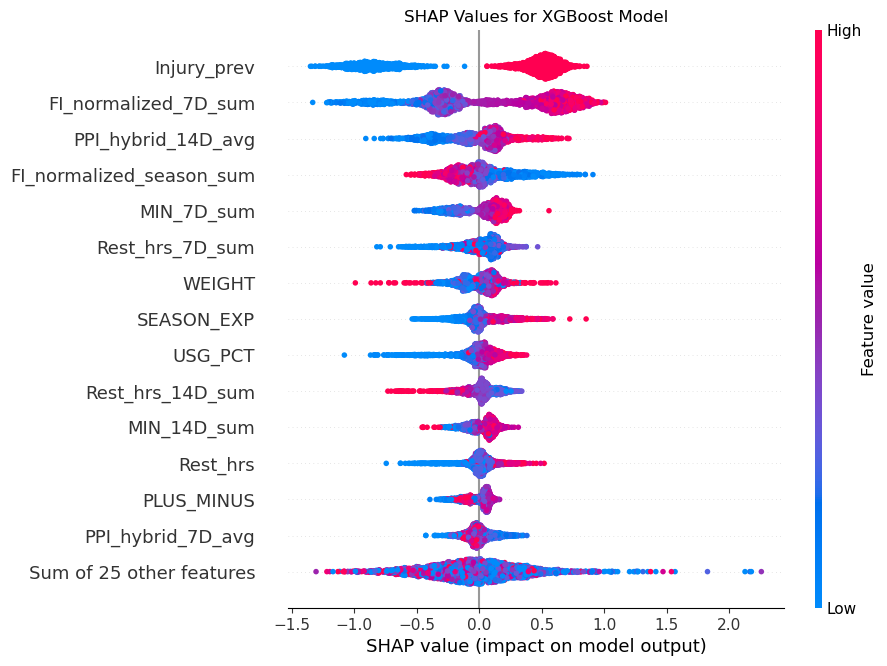


Model Performance Comparison:
                   Model  Accuracy  Precision   Recall  F1-Score
      XGBoost (Weighted)  0.801272   0.297398 0.567376  0.390244
Random Forest (Weighted)  0.891892   0.812500 0.046099  0.087248


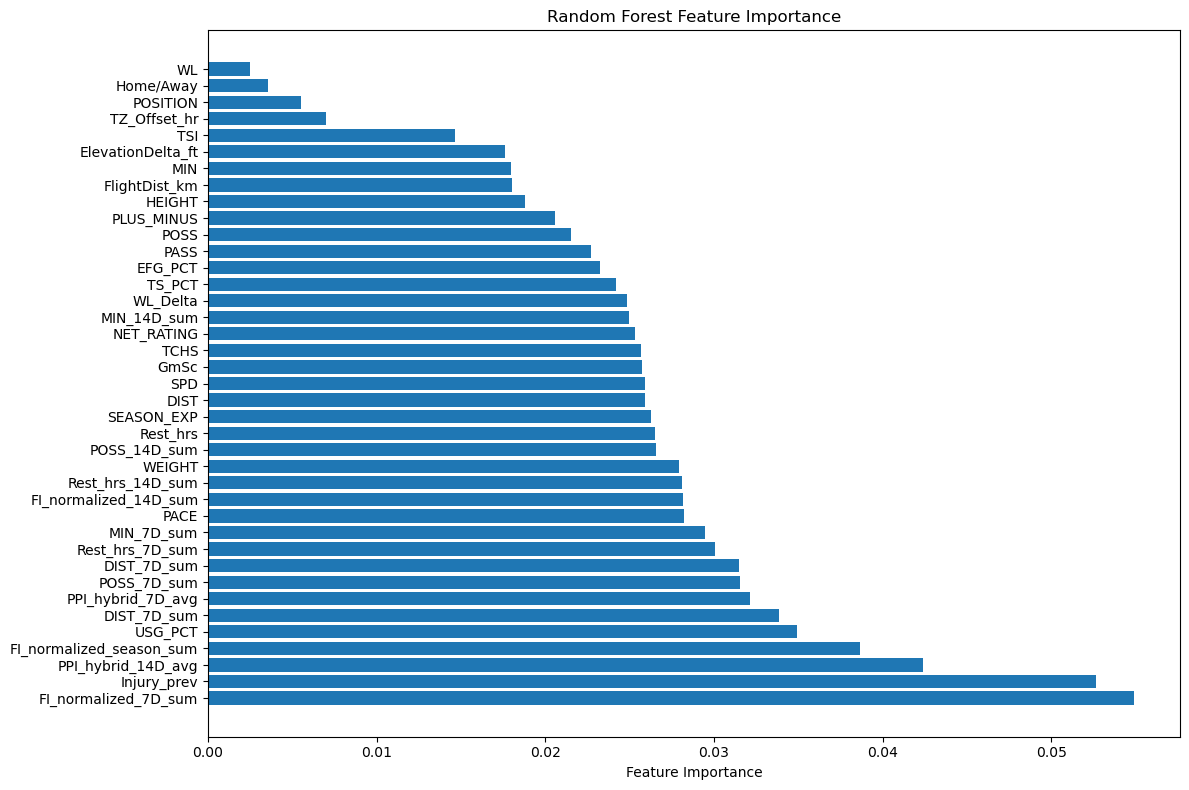

In [826]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from IPython.display import display

# Prepare features and target
X = NBA_Analysis_Data_Final[['MIN_7D_sum', 'MIN_14D_sum', 'PLUS_MINUS', 'MIN', 'HEIGHT', 
                            'WEIGHT', 'SEASON_EXP', 'NET_RATING', 'EFG_PCT', 'TS_PCT', 
                            'USG_PCT', 'PACE', 'POSS_7D_sum', 'POSS', 'POSS_14D_sum', 'SPD', 
                            'DIST', 'DIST_7D_sum', 'TCHS', 'PASS', 'WL_Delta', 'FlightDist_km', 
                            'TZ_Offset_hr', 'ElevationDelta_ft', 'Rest_hrs', 'Rest_hrs_7D_sum', 
                            'TSI', 'FI_normalized_7D_sum', 'FI_normalized_14D_sum', 
                            'FI_normalized_season_sum', 'Rest_hrs_14D_sum', 'DIST_7D_sum', 
                            'PPI_hybrid_7D_avg', 'PPI_hybrid_14D_avg', 'GmSc']]
y = NBA_Analysis_Data_Final['Injured']

# Define feature types
numerical_cols = X.columns.tolist()
categorical_cols = ['WL', 'POSITION', 'Home/Away', 'Injury_prev']

# Use LabelEncoder for categorical variables
le = LabelEncoder()
for col in categorical_cols:
    NBA_Analysis_Data_Final[col] = le.fit_transform(NBA_Analysis_Data_Final[col])

# Prepare X with encoded categorical variables
X = NBA_Analysis_Data_Final[numerical_cols + categorical_cols]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Convert target to binary (0/1)
y_train_binary = (y_train == 'Injured/Ill').astype(int)
y_test_binary = (y_test == 'Injured/Ill').astype(int)

# Method 1: Class Weighting Approach
xgb_model_weighted = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=7.17,  # Adjusted for 89%/11% class distribution
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    enable_categorical=True  # Added to handle categorical features
)

# Method 3: Random Forest with class weighting
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

# Train models
X_train_array = X_train.values  # Convert to numpy array for XGBoost
xgb_model_weighted.fit(X_train_array, y_train_binary)
rf_model.fit(X_train, y_train_binary)

# Make predictions
weighted_predictions = xgb_model_weighted.predict(X_test.values)
rf_predictions = rf_model.predict(X_test.values)

# Create results dictionary
results = {
    'XGBoost (Weighted)': {
        'predictions': weighted_predictions,
        'model': xgb_model_weighted,
        'method': 'Class Weighting'
    },
    'Random Forest (Weighted)': {
        'predictions': rf_predictions,
        'model': rf_model,
        'method': 'Class Weighting'
    }
}

# Create SHAP values for XGBoost model
explainer = shap.Explainer(xgb_model_weighted, X_train.values, feature_names=X_train.columns.tolist())
shap_values = explainer(X_test.values)
#

# Create SHAP plot with proper feature labels
plt.figure(figsize=(12, 8))
plt.title(f'SHAP Values for XGBoost Model')
shap.plots.beeswarm(shap_values, max_display =15)  # Removed feature_names parameter
#
#
#plt.show()

# Create performance comparison table
metrics = []
for model_name, result in results.items():
    y_pred = result['predictions']
    metrics.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test_binary, y_pred),
        'Precision': classification_report(y_test_binary, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test_binary, y_pred, output_dict=True)['1']['recall'],
        'F1-Score': classification_report(y_test_binary, y_pred, output_dict=True)['1']['f1-score']
    })

# Display performance table
print("\nModel Performance Comparison:")
print("============================")
comparison_df = pd.DataFrame(metrics)
print(comparison_df.to_string(index=False))

# Create feature importance plot for Random Forest
plt.figure(figsize=(12, 8))
feature_importances = results['Random Forest (Weighted)']['model'].feature_importances_
feature_names = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.barh(range(len(feature_names)), feature_importances[indices])
plt.yticks(range(len(feature_names)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [829]:
from sklearn.metrics import classification_report
#
y_pred = best_model.predict(X_test.values)
print(classification_report(y_test_binary, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      2234
           1       0.30      0.50      0.37       282

    accuracy                           0.81      2516
   macro avg       0.61      0.67      0.63      2516
weighted avg       0.86      0.81      0.83      2516



              precision    recall  f1-score   support

           0       0.93      0.85      0.89      2234
           1       0.30      0.50      0.37       282

    accuracy                           0.81      2516
   macro avg       0.61      0.67      0.63      2516
weighted avg       0.86      0.81      0.83      2516



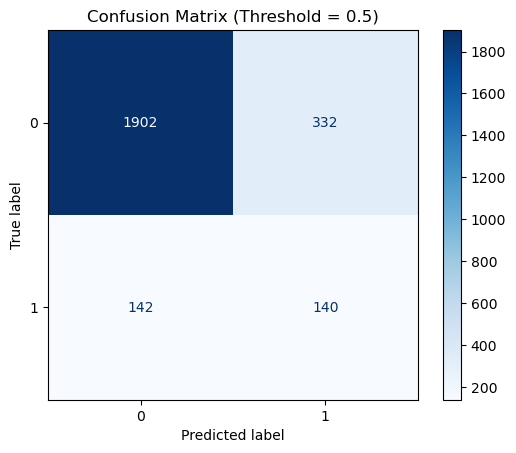

 97%|=================== | 2435/2516 [00:12<00:00]       

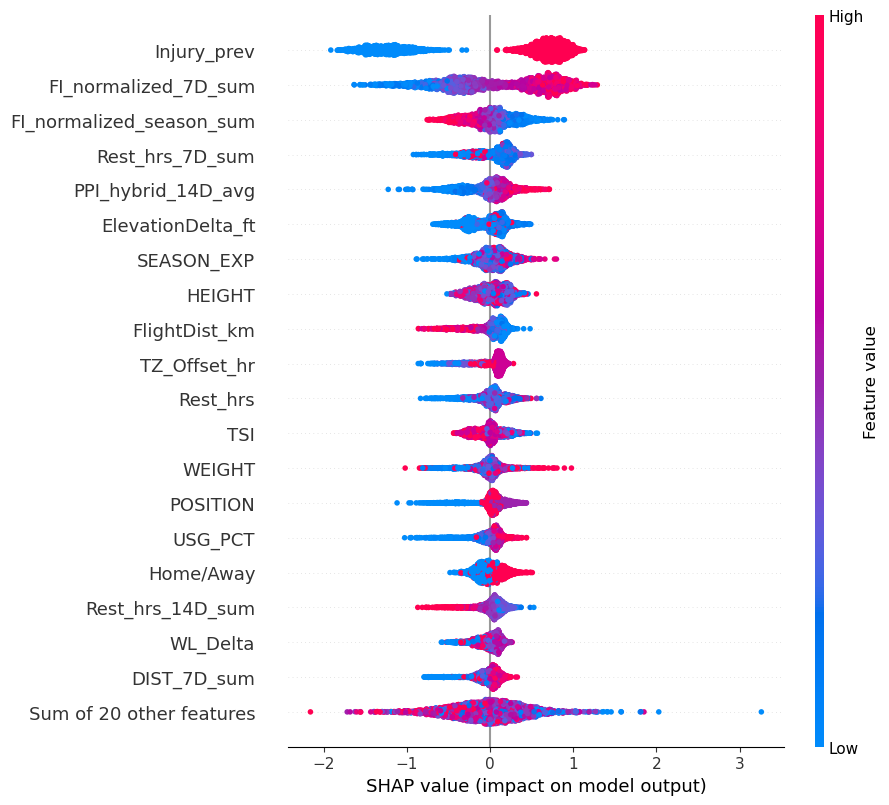

In [843]:
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    f1_score, ConfusionMatrixDisplay
)
#
y_probs = best_model.predict_proba(X_test.values)[:, 1]
#
#  Lower threshold to favor recall
threshold = 0.5  # default is 0.5; lower = more positives
y_pred_thresh = (y_probs >= threshold).astype(int)

#  Classification report
print(classification_report(y_test_binary, y_pred_thresh))

# Confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

#  SHAP interpretability
final_xgb = best_model.named_steps['xgb']
explainer = shap.Explainer(final_xgb, X_train.values, feature_names=X_train.columns.tolist())
shap_values = explainer(X_test.values)

shap.plots.beeswarm(shap_values, max_display=20)


## XGB Model tuned with SMOTE for addressing class imbalance and also RandomsearchCV to optimize hyperparameters

In [827]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

# Step 1: Define SMOTE
smote = SMOTE(random_state=42)

# Step 2: Define XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Step 3: Create pipeline
pipeline = Pipeline([
    ('smote', smote),
    ('xgb', xgb_model)
])

# Step 4: Define hyperparameter grid
param_grid = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__scale_pos_weight': [1, 3, 5, 7]  # still useful with SMOTE
}

# Step 5: Define scoring metric
scorer = make_scorer(f1_score)

# Step 6: Run RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=100,
    scoring=scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_array, y_train_binary)

# Step 7: Best model
best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\MuraliSAI\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [00:51:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 5, 'xgb__n_estimators': 100, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 1.0}


### Confusion matrix for Tuned XGB Model

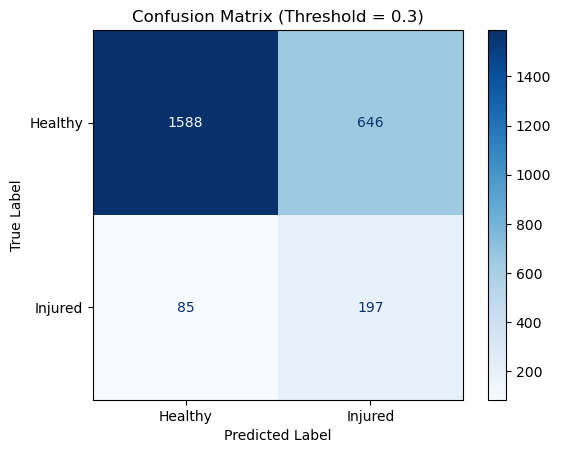

In [842]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Compute confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_thresh)

# Step 2: Define custom class labels
class_labels = ["Healthy", "Injured"]

# Step 3: Display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [894]:
NBA_Analysis_Data_Final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12577 entries, 0 to 12576
Columns: 139 entries, index to Injury_prev
dtypes: datetime64[ns](1), float64(89), int64(34), object(15)
memory usage: 13.3+ MB


In [79]:
NBA = NBA_Analysis_Data_Final.copy()

## Analysis 4: Transformer- Time-Series Regression Model

In [80]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1. Configuration
# -----------------------------
SEQ_LEN = 7
BATCH_SIZE = 64
EPOCHS = 23
LR = 3e-4
TARGETS = ['FI_normalized', 'PPI_hybrid']
#
numerical_features = ['FI_normalized_7D_sum', 'FI_normalized_season_sum', 'Rest_hrs_7D_sum',
    'PPI_hybrid_7D_avg', 'PPI_hybrid_14D_avg', 'ElevationDelta_ft',
    'MIN_7D_sum', 'DIST_7D_sum', 'SEASON_EXP', 'Rest_hrs', 'TSI',
    'Rest_hrs_7D_sum', 'HEIGHT', 'FlightDist_km',
    'WEIGHT', 'USG_PCT', 'Rest_hrs_14D_sum',
    'WL_Delta', 'TZ_Offset_hr', 'FI_normalized_14D_sum', 'PPI_hybrid_season_avg',
    'GmSc', 'GmSc_7D_avg','TS_PCT','TS_PCT_7D_avg','EFG_PCT','EFG_PCT_7D_avg','PLUS_MINUS',
    'NET_RATING','AST_TOV','POSS','SPD','DIST','MIN','TCHS','PASS','TM_TOV_PCT','PACE','PIE']
#
#
categorical_features = ['WL','POSITION','Injured','Home/Away','Injury_prev']
#
#
scaler = StandardScaler()
NBA[numerical_features] = scaler.fit_transform(NBA[numerical_features])
#
NBA_encoded = pd.get_dummies(
    NBA,
    columns=categorical_features,
    drop_first=True  # Optional: avoids multicollinearity
)
#NBA_Analysis_Data_Final_encoded = pd.get_dummies(NBA_Analysis_Data_Final, drop_first=True)

# Force all columns to numeric
NBA_encoded = NBA_encoded.apply(pd.to_numeric, errors='coerce')
#print(NBA_Analysis_Data_Final_encoded.columns.tolist())
#pd.get_dummies(NBA_Analysis_Data_Final, columns=categorical_features, drop_first=True)


In [81]:
for col in NBA_encoded.columns:
    if NBA_encoded[col].dtype == 'bool':
        NBA_encoded[col] = NBA_encoded[col].astype(float)

In [82]:
#
selected_features = [
    'FI_normalized_7D_sum', 'FI_normalized_season_sum', 'Rest_hrs_7D_sum',
    'PPI_hybrid_7D_avg', 'PPI_hybrid_14D_avg', 'ElevationDelta_ft',
    'MIN_7D_sum', 'DIST_7D_sum', 'SEASON_EXP', 'Rest_hrs', 'TSI',
    'HEIGHT', 'FlightDist_km', 'WEIGHT', 'USG_PCT', 'Rest_hrs_14D_sum',
    'TZ_Offset_hr', 'FI_normalized_14D_sum', 'PPI_hybrid_season_avg',
    # One-hot encoded columns
    'WL_W', 'POSITION_Forward', 'POSITION_Guard', 'Injured_Injured/Ill', 'Home/Away_Home', 'Injury_prev_Yes'
]
#
# -----------------------------
# 1. Positional Encoding Module
# -----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# -----------------------------
# 2. Sequence Generator
# -----------------------------
def create_sequences(df, features, targets, seq_len):
    sequences, labels = [], []
    df = df.sort_values(['Player_ID', 'GAME_DATE'])
    grouped = df.groupby('Player_ID')

    for _, group in grouped:
        group = group.reset_index(drop=True)
        for i in range(len(group) - seq_len):
            seq = group.loc[i:i+seq_len-1, features].values
            label = group.loc[i+seq_len, targets].values
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels, dtype=np.float32)

# -----------------------------
# 3. Dataset & DataLoader
# -----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -----------------------------
# 4. Enhanced Transformer Model
# -----------------------------
class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_len, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.2)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.2)
        self.fc_fi = nn.Linear(d_model * seq_len, 1)
        self.fc_ppi = nn.Linear(d_model * seq_len, 1)

    def forward(self, x):
        x = self.embedding(x)  # [batch, seq_len, d_model]
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # [seq_len, batch, d_model]
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # [batch, seq_len, d_model]
        x = self.norm(x)
        x = self.dropout(x)
        x = x.reshape(x.size(0), -1)  # [batch, seq_len * d_model]
        fi_out = self.fc_fi(x)
        ppi_out = self.fc_ppi(x)
        return torch.cat([fi_out, ppi_out], dim=1)

# -----------------------------
# 5. Evaluation Function
# -----------------------------
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            test_loss += loss.item()
    return test_loss / len(dataloader)

# -----------------------------
# 6. Data Preparation
# -----------------------------
X, y = create_sequences(NBA_encoded, selected_features, TARGETS, SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 7. Training Loop
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim=len(selected_features), seq_len=SEQ_LEN).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
criterion = nn.MSELoss()

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_test_loss = evaluate_model(model, test_loader, criterion, device)
    scheduler.step(avg_test_loss)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

# -----------------------------
# 8. Final Evaluation
# -----------------------------
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        preds = model(batch_X).cpu().numpy()
        y_true.append(batch_y.numpy())
        y_pred.append(preds)

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

for i, target in enumerate(TARGETS):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = mean_squared_error(y_true[:, i], y_pred[:, i], squared=False)
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    print(f"\n📊 Evaluation for {target}:")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")

Epoch 1/23 - Train Loss: 0.1112 - Test Loss: 0.0081
Epoch 2/23 - Train Loss: 0.0362 - Test Loss: 0.0079
Epoch 3/23 - Train Loss: 0.0149 - Test Loss: 0.0069
Epoch 4/23 - Train Loss: 0.0114 - Test Loss: 0.0068
Epoch 5/23 - Train Loss: 0.0098 - Test Loss: 0.0069
Epoch 6/23 - Train Loss: 0.0094 - Test Loss: 0.0066
Epoch 7/23 - Train Loss: 0.0091 - Test Loss: 0.0073
Epoch 8/23 - Train Loss: 0.0089 - Test Loss: 0.0067
Epoch 9/23 - Train Loss: 0.0086 - Test Loss: 0.0066
Epoch 10/23 - Train Loss: 0.0083 - Test Loss: 0.0072
Epoch 11/23 - Train Loss: 0.0081 - Test Loss: 0.0068
Epoch 12/23 - Train Loss: 0.0081 - Test Loss: 0.0067
Epoch 13/23 - Train Loss: 0.0079 - Test Loss: 0.0067
Epoch 14/23 - Train Loss: 0.0077 - Test Loss: 0.0066
Epoch 15/23 - Train Loss: 0.0076 - Test Loss: 0.0063
Epoch 16/23 - Train Loss: 0.0076 - Test Loss: 0.0064
Epoch 17/23 - Train Loss: 0.0074 - Test Loss: 0.0067
Epoch 18/23 - Train Loss: 0.0076 - Test Loss: 0.0065
Epoch 19/23 - Train Loss: 0.0074 - Test Loss: 0.0067
Ep

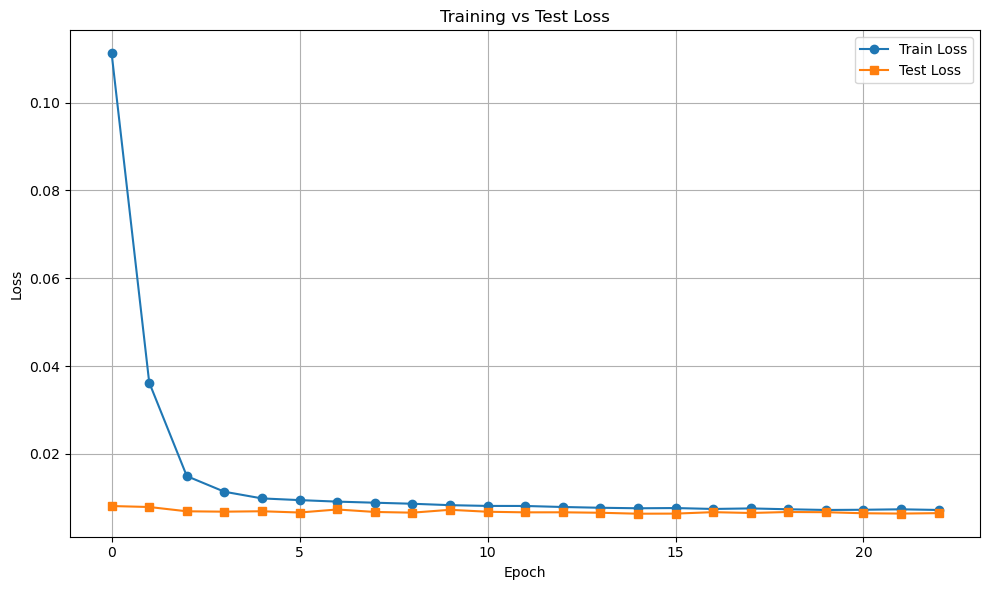

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
results

{7: [], 14: []}

### Time-series Model enhancements

In [87]:
import os
import copy
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# 0. (USER) Load your DataFrame
# -----------------------------
# Ensure NBA DataFrame is loaded in memory with required columns
if 'NBA' not in globals():
    raise RuntimeError("Please load your DataFrame into variable 'NBA' before running (NBA = pd.read_csv(...)).")

NBA = NBA.copy()
if not np.issubdtype(NBA['GAME_DATE'].dtype, np.datetime64):
    NBA['GAME_DATE'] = pd.to_datetime(NBA['GAME_DATE'])

# -----------------------------
# 1. Configuration & Features
# -----------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

SEQ_LEN = 7
BATCH_SIZE = 64
EPOCHS = 50
LR = 3e-4
TARGETS = ['FI_normalized', 'PPI_hybrid']

numerical_features = ['FI_normalized_7D_sum', 'FI_normalized_season_sum', 'Rest_hrs_7D_sum',
    'PPI_hybrid_7D_avg', 'PPI_hybrid_14D_avg', 'ElevationDelta_ft',
    'MIN_7D_sum', 'DIST_7D_sum', 'SEASON_EXP', 'Rest_hrs', 'TSI',
    'HEIGHT', 'FlightDist_km',
    'WEIGHT', 'USG_PCT', 'Rest_hrs_14D_sum',
    'WL_Delta', 'TZ_Offset_hr', 'FI_normalized_14D_sum', 'PPI_hybrid_season_avg',
    'GmSc', 'GmSc_7D_avg','TS_PCT','TS_PCT_7D_avg','EFG_PCT','EFG_PCT_7D_avg','PLUS_MINUS',
    'NET_RATING','AST_TOV','POSS','SPD','DIST','MIN','TCHS','PASS','TM_TOV_PCT','PACE','PIE'
]

categorical_features = ['WL','POSITION','Injured','Home/Away','Injury_prev']

# Minimal check for required columns
missing = [c for c in numerical_features + categorical_features + TARGETS + ['Player_ID', 'GAME_DATE'] if c not in NBA.columns]
if missing:
    raise RuntimeError(f"Missing columns in NBA DataFrame: {missing}")

# -----------------------------
# 2. Train / Val / Test splits (grouped by Player_ID)
# -----------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
train_idx, temp_idx = next(gss.split(NBA, groups=NBA['Player_ID']))
train_df = NBA.iloc[train_idx].copy()
temp_df = NBA.iloc[temp_idx].copy()

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_idx_rel, test_idx_rel = next(gss2.split(temp_df, groups=temp_df['Player_ID']))
val_df = temp_df.iloc[val_idx_rel].copy()
test_df = temp_df.iloc[test_idx_rel].copy()

print(f"Train players: {train_df['Player_ID'].nunique()}, Val players: {val_df['Player_ID'].nunique()}, Test players: {test_df['Player_ID'].nunique()}")

# -----------------------------
# 3. Fit Scalers & Encoders ON TRAIN ONLY, transform sets
# -----------------------------
num_scaler = StandardScaler()
train_df[numerical_features] = num_scaler.fit_transform(train_df[numerical_features])
val_df[numerical_features] = num_scaler.transform(val_df[numerical_features])
test_df[numerical_features] = num_scaler.transform(test_df[numerical_features])

# OneHotEncoder compatibility: new sklearn uses 'sparse_output', older uses 'sparse'
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit on training categorical columns
ohe_train = ohe.fit_transform(train_df[categorical_features])
ohe_cols = list(ohe.get_feature_names_out(categorical_features))

ohe_train_df = pd.DataFrame(ohe_train, index=train_df.index, columns=ohe_cols)
train_df = pd.concat([train_df.drop(columns=categorical_features), ohe_train_df], axis=1)

ohe_val = ohe.transform(val_df[categorical_features])
ohe_val_df = pd.DataFrame(ohe_val, index=val_df.index, columns=ohe_cols)
val_df = pd.concat([val_df.drop(columns=categorical_features), ohe_val_df], axis=1)

ohe_test = ohe.transform(test_df[categorical_features])
ohe_test_df = pd.DataFrame(ohe_test, index=test_df.index, columns=ohe_cols)
test_df = pd.concat([test_df.drop(columns=categorical_features), ohe_test_df], axis=1)

# -----------------------------
# 4. Final feature list
# -----------------------------
exclude_cols = set(['Player_ID', 'GAME_DATE'] + TARGETS)
features = [c for c in (numerical_features + ohe_cols) if c in train_df.columns and c not in exclude_cols]
input_dim = len(features)
print("Input dimension (features):", input_dim)

# -----------------------------
# 5. Sequence creation function
# -----------------------------
def create_sequences(df, features, targets, seq_len):
    sequences = []
    labels = []
    df_sorted = df.sort_values(['Player_ID', 'GAME_DATE'])
    grouped = df_sorted.groupby('Player_ID', sort=False)
    for _, group in grouped:
        group = group.reset_index(drop=True)
        if len(group) <= seq_len:
            continue
        for i in range(len(group) - seq_len):
            seq = group.loc[i:i+seq_len-1, features].values.astype(np.float32)
            label = group.loc[i+seq_len, targets].values.astype(np.float32)
            sequences.append(seq)
            labels.append(label)
    if len(sequences) == 0:
        return np.empty((0, seq_len, len(features)), dtype=np.float32), np.empty((0, len(targets)), dtype=np.float32)
    return np.stack(sequences), np.stack(labels)

X_train, y_train = create_sequences(train_df, features, TARGETS, SEQ_LEN)
X_val, y_val = create_sequences(val_df, features, TARGETS, SEQ_LEN)
X_test, y_test = create_sequences(test_df, features, TARGETS, SEQ_LEN)

print("Seq counts: train", len(X_train), "val", len(X_val), "test", len(X_test))

# -----------------------------
# 6. Scale targets (y) using train scaler
# -----------------------------
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

# -----------------------------
# 7. Dataset / DataLoader
# -----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train_scaled), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(TimeSeriesDataset(X_val, y_val_scaled), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test, y_test_scaled), batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 8. Model (positional encoding -> transformer -> pooling -> heads)
# -----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerModel(nn.Module):
    def __init__(self, input_dim, seq_len, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        # Use batch_first=True if available in your torch version (1.9+)
        try:
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self._batch_first = True
        except TypeError:
            # older torch versions: no batch_first parameter; use permute accordingly
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self._batch_first = False
        self.norm = nn.LayerNorm(d_model)
        self.pool = nn.AdaptiveAvgPool1d(1)
        hidden = max(d_model // 2, 16)
        self.head_fi = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden, 1))
        self.head_ppi = nn.Sequential(nn.Linear(d_model, hidden), nn.ReLU(), nn.Dropout(dropout), nn.Linear(hidden, 1))

    def forward(self, x):
        # x: [batch, seq_len, input_dim]
        x = self.embedding(x)  # [batch, seq_len, d_model]
        x = self.pos_encoder(x)
        if self._batch_first:
            x = self.transformer(x)  # [batch, seq_len, d_model]
        else:
            x = x.permute(1, 0, 2)           # [seq_len, batch, d_model]
            x = self.transformer(x)         # [seq_len, batch, d_model]
            x = x.permute(1, 0, 2)          # [batch, seq_len, d_model]
        x = self.norm(x)
        x = x.permute(0, 2, 1)  # [batch, d_model, seq_len]
        x_pool = self.pool(x).squeeze(-1)  # [batch, d_model]
        fi = self.head_fi(x_pool)
        ppi = self.head_ppi(x_pool)
        return torch.cat([fi, ppi], dim=1)

# -----------------------------
# 9. Training setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim=input_dim, seq_len=SEQ_LEN, d_model=128, nhead=8, num_layers=2, dropout=0.2).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.MSELoss()  # on scaled targets
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
scaler_amp = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

def evaluate(model, dataloader, device, criterion):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

# Early stopping
best_val = float('inf')
best_model_state = None
patience = 7
stale = 0
best_epoch = 0

# -----------------------------
# 10. Training loop
# -----------------------------
for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        if scaler_amp is not None:
            with torch.cuda.amp.autocast():
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
            scaler_amp.scale(loss).backward()
            scaler_amp.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler_amp.step(optimizer)
            scaler_amp.update()
        else:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / max(1, len(train_loader))
    val_loss = evaluate(model, val_loader, device, criterion)
    scheduler.step(val_loss)

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        stale = 0
        best_epoch = epoch
    else:
        stale += 1

    print(f"Epoch {epoch}/{EPOCHS}  Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}  Best Val: {best_val:.6f} (epoch {best_epoch})")

    if stale >= patience:
        print("Early stopping triggered.")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# -----------------------------
# 11. Final evaluation on TEST set (inverse transform predictions)
# -----------------------------
model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds_scaled = model(X_batch).cpu().numpy()
        y_pred_list.append(preds_scaled)
        y_true_list.append(y_batch.numpy())

y_pred_scaled = np.vstack(y_pred_list)
y_true_scaled = np.vstack(y_true_list)

# invert scaling
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

for i, target in enumerate(TARGETS):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = mean_squared_error(y_true[:, i], y_pred[:, i], squared=False)
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    print(f"\nEvaluation for {target}:")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")

# Baseline: predict last-observed value for each sequence (naive) to compare -- uses unscaled features & real y
def baseline_last_value(df, features, targets, seq_len):
    seqs_y = []
    preds = []
    df_sorted = df.sort_values(['Player_ID', 'GAME_DATE'])
    grouped = df_sorted.groupby('Player_ID', sort=False)
    for _, group in grouped:
        group = group.reset_index(drop=True)
        if len(group) <= seq_len:
            continue
        for i in range(len(group) - seq_len):
            true = group.loc[i+seq_len, targets].values.astype(np.float32)
            last_obs = group.loc[i+seq_len-1, targets].values.astype(np.float32)
            seqs_y.append(true)
            preds.append(last_obs)
    if len(seqs_y) == 0:
        return np.empty((0, len(targets))), np.empty((0, len(targets)))
    return np.stack(seqs_y), np.stack(preds)

y_true_base, y_pred_base = baseline_last_value(test_df, features, TARGETS, SEQ_LEN)
if len(y_true_base) > 0:
    for i, target in enumerate(TARGETS):
        mae_b = mean_absolute_error(y_true_base[:, i], y_pred_base[:, i])
        rmse_b = mean_squared_error(y_true_base[:, i], y_pred_base[:, i], squared=False)
        r2_b = r2_score(y_true_base[:, i], y_pred_base[:, i])
        print(f"\nBaseline (last-value) for {target}: MAE={mae_b:.4f}, RMSE={rmse_b:.4f}, R2={r2_b:.4f}")
else:
    print("No baseline sequences available for test set (too short).")


Train players: 142, Val players: 30, Test players: 31
Input dimension (features): 49
Seq counts: train 7860 val 1590 test 1711
Epoch 1/50  Train Loss: 0.721036  Val Loss: 0.698525  Best Val: 0.698525 (epoch 1)
Epoch 2/50  Train Loss: 0.680898  Val Loss: 0.667280  Best Val: 0.667280 (epoch 2)
Epoch 3/50  Train Loss: 0.671862  Val Loss: 0.668351  Best Val: 0.667280 (epoch 2)
Epoch 4/50  Train Loss: 0.665810  Val Loss: 0.672991  Best Val: 0.667280 (epoch 2)
Epoch 5/50  Train Loss: 0.661796  Val Loss: 0.678026  Best Val: 0.667280 (epoch 2)
Epoch 6/50  Train Loss: 0.654858  Val Loss: 0.695182  Best Val: 0.667280 (epoch 2)
Epoch 7/50  Train Loss: 0.637817  Val Loss: 0.674103  Best Val: 0.667280 (epoch 2)
Epoch 8/50  Train Loss: 0.629092  Val Loss: 0.679063  Best Val: 0.667280 (epoch 2)
Epoch 9/50  Train Loss: 0.620420  Val Loss: 0.682736  Best Val: 0.667280 (epoch 2)
Early stopping triggered.

Evaluation for FI_normalized:
MAE  = 0.0732
RMSE = 0.0970
R²   = 0.4042

Evaluation for PPI_hybrid:

In [89]:
import copy
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# 0. Load your DataFrame into variable NBA before running
# -----------------------------
if 'NBA' not in globals():
    raise RuntimeError("Please load your DataFrame into variable 'NBA' (e.g. NBA = pd.read_csv(...))")

NBA = NBA.copy()
if 'GAME_DATE' not in NBA.columns:
    raise RuntimeError("NBA must contain column 'GAME_DATE' (datetime-like).")
if not np.issubdtype(NBA['GAME_DATE'].dtype, np.datetime64):
    NBA['GAME_DATE'] = pd.to_datetime(NBA['GAME_DATE'])

# -----------------------------
# 1. Config & feature lists
# -----------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

SEQ_LEN = 7
BATCH_SIZE = 64
EPOCHS = 50
LR = 3e-4
TARGETS = ['FI_normalized', 'PPI_hybrid']

numerical_features = [
    'FI_normalized_7D_sum', 'FI_normalized_season_sum', 'Rest_hrs_7D_sum',
    'PPI_hybrid_7D_avg', 'PPI_hybrid_14D_avg', 'ElevationDelta_ft',
    'MIN_7D_sum', 'DIST_7D_sum', 'SEASON_EXP', 'Rest_hrs', 'TSI',
    'HEIGHT', 'FlightDist_km', 'WEIGHT', 'USG_PCT', 'Rest_hrs_14D_sum',
    'WL_Delta', 'TZ_Offset_hr', 'FI_normalized_14D_sum', 'PPI_hybrid_season_avg',
    'GmSc', 'GmSc_7D_avg', 'TS_PCT', 'TS_PCT_7D_avg', 'EFG_PCT', 'EFG_PCT_7D_avg',
    'PLUS_MINUS', 'NET_RATING', 'AST_TOV', 'POSS', 'SPD', 'DIST', 'MIN', 'TCHS',
    'PASS', 'TM_TOV_PCT', 'PACE', 'PIE'
]

# We'll embed POSITION; other categorical columns keep for OHE
categorical_ohe = ['WL', 'Injured', 'Home/Away', 'Injury_prev']
# POSITION will be embedded
cat_position = 'POSITION'

# static features to feed separately (example: HEIGHT, WEIGHT)
static_features = ['HEIGHT', 'WEIGHT']

required_cols = set(numerical_features + categorical_ohe + [cat_position] + TARGETS + ['Player_ID', 'GAME_DATE'])
missing = [c for c in required_cols if c not in NBA.columns]
if missing:
    raise RuntimeError(f"Missing columns in NBA: {missing}")

# -----------------------------
# 2. Grouped splits by Player_ID (train / val / test)
# -----------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=SEED)
train_idx, temp_idx = next(gss.split(NBA, groups=NBA['Player_ID']))
train_df = NBA.iloc[train_idx].copy()
temp_df = NBA.iloc[temp_idx].copy()

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_idx_rel, test_idx_rel = next(gss2.split(temp_df, groups=temp_df['Player_ID']))
val_df = temp_df.iloc[val_idx_rel].copy()
test_df = temp_df.iloc[test_idx_rel].copy()

print(f"Train players: {train_df['Player_ID'].nunique()}, Val players: {val_df['Player_ID'].nunique()}, Test players: {test_df['Player_ID'].nunique()}")

# -----------------------------
# 3. Fit numeric scaler on TRAIN only and transform sets
# -----------------------------
num_scaler = StandardScaler()
train_df[numerical_features] = num_scaler.fit_transform(train_df[numerical_features])
val_df[numerical_features] = num_scaler.transform(val_df[numerical_features])
test_df[numerical_features] = num_scaler.transform(test_df[numerical_features])

# -----------------------------
# 4. POSITION and Player mappings (embeddings)
# -----------------------------
# Player mapping: assign unknown index for players not in train
train_players = train_df['Player_ID'].unique().tolist()
player2idx = {pid: i for i, pid in enumerate(train_players)}
unknown_player_idx = len(player2idx)
n_player_emb = unknown_player_idx + 1

def map_player(pid):
    return player2idx.get(pid, unknown_player_idx)

# Position mapping: build from train positions
train_positions = train_df[cat_position].fillna('UNK').unique().tolist()
pos2idx = {p: i for i, p in enumerate(train_positions)}
unknown_pos_idx = len(pos2idx)
n_pos_emb = unknown_pos_idx + 1

def map_position(pos):
    pos = pos if pd.notna(pos) else 'UNK'
    return pos2idx.get(pos, unknown_pos_idx)

# Add helper columns for indexing (we'll use these when creating sequences)
train_df['player_idx'] = train_df['Player_ID'].map(map_player)
val_df['player_idx'] = val_df['Player_ID'].map(map_player)
test_df['player_idx'] = test_df['Player_ID'].map(map_player)

train_df['pos_idx'] = train_df[cat_position].fillna('UNK').map(lambda x: pos2idx.get(x, unknown_pos_idx))
val_df['pos_idx'] = val_df[cat_position].fillna('UNK').map(lambda x: pos2idx.get(x, unknown_pos_idx))
test_df['pos_idx'] = test_df[cat_position].fillna('UNK').map(lambda x: pos2idx.get(x, unknown_pos_idx))

# -----------------------------
# 5. OneHotEncode remaining categorical features (fit on train only)
# -----------------------------
try:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

if len(categorical_ohe) > 0:
    ohe_train = ohe.fit_transform(train_df[categorical_ohe])
    ohe_cols = list(ohe.get_feature_names_out(categorical_ohe))
    ohe_train_df = pd.DataFrame(ohe_train, index=train_df.index, columns=ohe_cols)
    train_df = pd.concat([train_df.drop(columns=categorical_ohe), ohe_train_df], axis=1)

    ohe_val = ohe.transform(val_df[categorical_ohe])
    ohe_val_df = pd.DataFrame(ohe_val, index=val_df.index, columns=ohe_cols)
    val_df = pd.concat([val_df.drop(columns=categorical_ohe), ohe_val_df], axis=1)

    ohe_test = ohe.transform(test_df[categorical_ohe])
    ohe_test_df = pd.DataFrame(ohe_test, index=test_df.index, columns=ohe_cols)
    test_df = pd.concat([test_df.drop(columns=categorical_ohe), ohe_test_df], axis=1)
else:
    ohe_cols = []

# -----------------------------
# 6. Final feature list used as sequence inputs (exclude Player_ID, GAME_DATE, targets, pos, player_idx etc)
# -----------------------------
exclude_cols = set(['Player_ID', 'GAME_DATE', cat_position, 'player_idx', 'pos_idx'] + TARGETS)
features = [c for c in (numerical_features + ohe_cols) if c in train_df.columns and c not in exclude_cols]
input_dim = len(features)
print("Input dim:", input_dim, "Static dim:", len(static_features))

# -----------------------------
# 7. Sequence creation (returns X_seq, player_idx, pos_idx, static_feats, y)
# -----------------------------
def create_sequences_with_meta(df, features, static_feats, targets, seq_len):
    seqs = []
    player_idxs = []
    pos_idxs = []
    static_arr = []
    labels = []

    df_sorted = df.sort_values(['Player_ID', 'GAME_DATE'])
    grouped = df_sorted.groupby('Player_ID', sort=False)
    for _, group in grouped:
        group = group.reset_index(drop=True)
        if len(group) <= seq_len:
            continue
        for i in range(len(group) - seq_len):
            seq = group.loc[i:i+seq_len-1, features].values.astype(np.float32)  # input sequence
            target_row = group.loc[i+seq_len]
            label = target_row[targets].values.astype(np.float32)
            pid_idx = int(target_row['player_idx']) if 'player_idx' in target_row else map_player(target_row['Player_ID'])
            pos_idx = int(target_row['pos_idx']) if 'pos_idx' in target_row else map_position(target_row[cat_position])
            stat = target_row[static_feats].values.astype(np.float32) if len(static_feats) > 0 else np.empty((0,), dtype=np.float32)

            seqs.append(seq)
            player_idxs.append(pid_idx)
            pos_idxs.append(pos_idx)
            static_arr.append(stat)
            labels.append(label)

    if len(seqs) == 0:
        return (np.empty((0, seq_len, len(features)), dtype=np.float32),
                np.empty((0,), dtype=np.int64),
                np.empty((0,), dtype=np.int64),
                np.empty((0, len(static_feats)), dtype=np.float32),
                np.empty((0, len(targets)), dtype=np.float32))
    return (np.stack(seqs), np.array(player_idxs, dtype=np.int64),
            np.array(pos_idxs, dtype=np.int64), np.stack(static_arr), np.stack(labels))

X_train, pidx_train, posidx_train, static_train, y_train = create_sequences_with_meta(train_df, features, static_features, TARGETS, SEQ_LEN)
X_val, pidx_val, posidx_val, static_val, y_val = create_sequences_with_meta(val_df, features, static_features, TARGETS, SEQ_LEN)
X_test, pidx_test, posidx_test, static_test, y_test = create_sequences_with_meta(test_df, features, static_features, TARGETS, SEQ_LEN)

print("Seq counts: train", len(X_train), "val", len(X_val), "test", len(X_test))

# -----------------------------
# 8. Scale targets with train scaler
# -----------------------------
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

# -----------------------------
# 9. Dataset & DataLoader
# -----------------------------
class MetaTimeSeriesDataset(Dataset):
    def __init__(self, X, pidx, posidx, static, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.pidx = torch.tensor(pidx, dtype=torch.long)
        self.posidx = torch.tensor(posidx, dtype=torch.long)
        self.static = torch.tensor(static, dtype=torch.float32) if static.size else torch.empty((len(X), 0), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.pidx[idx], self.posidx[idx], self.static[idx], self.y[idx]

train_loader = DataLoader(MetaTimeSeriesDataset(X_train, pidx_train, posidx_train, static_train, y_train_scaled),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(MetaTimeSeriesDataset(X_val, pidx_val, posidx_val, static_val, y_val_scaled),
                        batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(MetaTimeSeriesDataset(X_test, pidx_test, posidx_test, static_test, y_test_scaled),
                         batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 10. Model: PosEncoding, AttentionPooling, player & position embeddings, shared MLP + heads
# -----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class AttentionPooling(nn.Module):
    def __init__(self, d_model, attn_dim=64):
        super().__init__()
        self.lin_k = nn.Linear(d_model, attn_dim)
        self.v = nn.Linear(d_model, d_model)
        self.q = nn.Parameter(torch.randn(attn_dim))
    def forward(self, x):  # x: [batch, seq_len, d_model]
        k = self.lin_k(x)  # [batch, seq_len, attn_dim]
        v = self.v(x)      # [batch, seq_len, d_model]
        q = self.q.unsqueeze(0).unsqueeze(0)  # [1,1,attn_dim]
        scores = (k * q).sum(-1)  # [batch, seq_len]
        attn = torch.softmax(scores, dim=-1).unsqueeze(-1)  # [batch, seq_len, 1]
        pooled = (v * attn).sum(dim=1)  # [batch, d_model]
        return pooled

class TransformerModelWithEmbeddings(nn.Module):
    def __init__(self, input_dim, seq_len, d_model=128, nhead=8, num_layers=2,
                 player_emb_dim=32, pos_emb_dim=8, static_dim=2, dropout=0.15,
                 n_players=None, n_positions=None):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)
        # try batch_first support; fallback if not available
        try:
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self._batch_first = True
        except TypeError:
            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            self._batch_first = False

        self.norm = nn.LayerNorm(d_model)
        self.pool = AttentionPooling(d_model, attn_dim=max(32, d_model//4))

        # embeddings
        self.player_emb = nn.Embedding(n_players, player_emb_dim)
        self.pos_emb = nn.Embedding(n_positions, pos_emb_dim)

        fused_dim = d_model + player_emb_dim + pos_emb_dim + static_dim
        hidden = max(fused_dim // 2, 32)
        self.shared = nn.Sequential(nn.Linear(fused_dim, hidden), nn.ReLU(), nn.Dropout(dropout))
        # per-target heads
        self.head_fi = nn.Linear(hidden, 1)
        self.head_ppi = nn.Linear(hidden, 1)

        # optional learnt task uncertainty weighting (Kendall)
        self.log_var_fi = nn.Parameter(torch.zeros(1))
        self.log_var_ppi = nn.Parameter(torch.zeros(1))

    def forward(self, x_seq, player_idx, pos_idx, static_feats):
        # x_seq: [batch, seq_len, input_dim]
        x = self.embedding(x_seq)
        x = self.pos_encoder(x)
        if self._batch_first:
            x = self.transformer(x)  # [batch, seq_len, d_model]
        else:
            x = x.permute(1,0,2)
            x = self.transformer(x)
            x = x.permute(1,0,2)
        x = self.norm(x)
        x_pool = self.pool(x)  # [batch, d_model]

        p_emb = self.player_emb(player_idx)  # [batch, player_emb_dim]
        pos_emb = self.pos_emb(pos_idx)      # [batch, pos_emb_dim]
        x_cat = torch.cat([x_pool, p_emb, pos_emb, static_feats], dim=1)  # [batch, fused_dim]
        shared = self.shared(x_cat)
        fi = self.head_fi(shared)
        ppi = self.head_ppi(shared)
        return torch.cat([fi, ppi], dim=1)
#
#
    def multitask_loss(self, y_pred, y_true):
        """
        Learned-uncertainty multitask loss (Kendall et al.):
        Loss = exp(-s1) * MSE1 + s1 + exp(-s2) * MSE2 + s2
        where s1/s2 are learned log-variances.
        Inputs are expected to be scaled targets (same scaling used during training).
        """
        # y_pred, y_true: [batch, 2] (FI, PPI)
        pred_fi = y_pred[:, 0]
        pred_ppi = y_pred[:, 1]
        true_fi = y_true[:, 0]
        true_ppi = y_true[:, 1]

        mse_fi = nn.functional.mse_loss(pred_fi, true_fi, reduction='mean')
        mse_ppi = nn.functional.mse_loss(pred_ppi, true_ppi, reduction='mean')

        loss_fi = torch.exp(-self.log_var_fi) * mse_fi + self.log_var_fi
        loss_ppi = torch.exp(-self.log_var_ppi) * mse_ppi + self.log_var_ppi

        return (loss_fi + loss_ppi).squeeze()

# -----------------------------
# 11. Instantiate model, optimizer, scheduler, utils
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerModelWithEmbeddings(
    input_dim=input_dim,
    seq_len=SEQ_LEN,
    d_model=128,
    nhead=8,
    num_layers=2,
    player_emb_dim=32,
    pos_emb_dim=8,
    static_dim=len(static_features),
    dropout=0.15,
    n_players=n_player_emb,
    n_positions=n_pos_emb
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# Use OneCycleLR for potentially better convergence (optional)
use_onecycle = True
if use_onecycle:
    steps_per_epoch = max(1, len(train_loader))
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=1e-3, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, pct_start=0.3, div_factor=10.0
    )
else:
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

scaler_amp = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

def evaluate_loss(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for X_batch, pidx, posidx, static_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            pidx = pidx.to(device)
            posidx = posidx.to(device)
            static_batch = static_batch.to(device) if static_batch.numel() > 0 else torch.zeros((X_batch.size(0), 0), device=device)
            y_batch = y_batch.to(device)
            preds = model(X_batch, pidx, posidx, static_batch)
            loss = model.multitask_loss(preds, y_batch)
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

# Early stopping
best_val = float('inf')
best_model_state = None
patience = 8
stale = 0

# -----------------------------
# 12. Training loop
# -----------------------------
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for X_batch, pidx, posidx, static_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        pidx = pidx.to(device)
        posidx = posidx.to(device)
        static_batch = static_batch.to(device) if static_batch.numel() > 0 else torch.zeros((X_batch.size(0), 0), device=device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        if scaler_amp is not None:
            with torch.cuda.amp.autocast():
                preds = model(X_batch, pidx, posidx, static_batch)
                loss = model.multitask_loss(preds, y_batch)
            scaler_amp.scale(loss).backward()
            scaler_amp.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler_amp.step(optimizer)
            scaler_amp.update()
        else:
            preds = model(X_batch, pidx, posidx, static_batch)
            loss = model.multitask_loss(preds, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        running_loss += loss.item()
        n_batches += 1

        # step OneCycleLR per batch
        if use_onecycle:
            scheduler.step()

    train_loss = running_loss / max(1, n_batches)
    val_loss = evaluate_loss(model, val_loader, device)

    if not use_onecycle:
        scheduler.step(val_loss)

    # Early stopping logic
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        stale = 0
        best_epoch = epoch
    else:
        stale += 1

    print(f"Epoch {epoch}/{EPOCHS}  Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}  Best Val: {best_val:.6f} (epoch {best_epoch if best_model_state is not None else 'N/A'})")

    if stale >= patience:
        print("Early stopping triggered.")
        break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# -----------------------------
# 13. Final evaluation on test (inverse transform predictions)
# -----------------------------
model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for X_batch, pidx, posidx, static_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pidx = pidx.to(device)
        posidx = posidx.to(device)
        static_batch = static_batch.to(device) if static_batch.numel() > 0 else torch.zeros((X_batch.size(0), 0), device=device)
        preds_scaled = model(X_batch, pidx, posidx, static_batch).cpu().numpy()
        y_pred_list.append(preds_scaled)
        y_true_list.append(y_batch.numpy())

y_pred_scaled = np.vstack(y_pred_list)
y_true_scaled = np.vstack(y_true_list)

# Inverse-transform targets to original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

for i, target in enumerate(TARGETS):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = mean_squared_error(y_true[:, i], y_pred[:, i], squared=False)
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    print(f"\nEvaluation for {target}:")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")

# -----------------------------
# 14. Baseline (last observed value) for comparison
# -----------------------------
def baseline_last_value(df, features, static_feats, targets, seq_len):
    y_true = []
    y_pred = []
    df_sorted = df.sort_values(['Player_ID', 'GAME_DATE'])
    grouped = df_sorted.groupby('Player_ID', sort=False)
    for _, group in grouped:
        group = group.reset_index(drop=True)
        if len(group) <= seq_len:
            continue
        for i in range(len(group) - seq_len):
            true = group.loc[i+seq_len, targets].values.astype(np.float32)
            last = group.loc[i+seq_len-1, targets].values.astype(np.float32)
            y_true.append(true)
            y_pred.append(last)
    if len(y_true) == 0:
        return np.empty((0, len(targets))), np.empty((0, len(targets)))
    return np.stack(y_true), np.stack(y_pred)

y_true_base, y_pred_base = baseline_last_value(test_df, features, static_features, TARGETS, SEQ_LEN)
if len(y_true_base) > 0:
    for i, target in enumerate(TARGETS):
        mae_b = mean_absolute_error(y_true_base[:, i], y_pred_base[:, i])
        rmse_b = mean_squared_error(y_true_base[:, i], y_pred_base[:, i], squared=False)
        r2_b = r2_score(y_true_base[:, i], y_pred_base[:, i])
        print(f"\nBaseline (last-value) for {target}: MAE={mae_b:.4f}, RMSE={rmse_b:.4f}, R2={r2_b:.4f}")
else:
    print("No baseline sequences available for test set (too short).")
#

Train players: 142, Val players: 30, Test players: 31
Input dim: 46 Static dim: 2
Seq counts: train 7860 val 1590 test 1711
Epoch 1/50  Train Loss: 1.484179  Val Loss: 1.369333  Best Val: 1.369333 (epoch 1)
Epoch 2/50  Train Loss: 1.373375  Val Loss: 1.367466  Best Val: 1.367466 (epoch 2)
Epoch 3/50  Train Loss: 1.330542  Val Loss: 1.378213  Best Val: 1.367466 (epoch 2)
Epoch 4/50  Train Loss: 1.309124  Val Loss: 1.339584  Best Val: 1.339584 (epoch 4)
Epoch 5/50  Train Loss: 1.285915  Val Loss: 1.385680  Best Val: 1.339584 (epoch 4)
Epoch 6/50  Train Loss: 1.261429  Val Loss: 1.302777  Best Val: 1.302777 (epoch 6)
Epoch 7/50  Train Loss: 1.237345  Val Loss: 1.319675  Best Val: 1.302777 (epoch 6)
Epoch 8/50  Train Loss: 1.217777  Val Loss: 1.273240  Best Val: 1.273240 (epoch 8)
Epoch 9/50  Train Loss: 1.190183  Val Loss: 1.224147  Best Val: 1.224147 (epoch 9)
Epoch 10/50  Train Loss: 1.151654  Val Loss: 1.316597  Best Val: 1.224147 (epoch 9)
Epoch 11/50  Train Loss: 1.124833  Val Loss: 

### END OF ANALYSIS SECTION

# NOTEBOOK END